# 0. Imports & define

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from geopy.geocoders import Nominatim
from kgcpy import lookupCZ
import matplotlib.patches as mpatches

# define the path to the data folder
ResultsFolder = r'C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results'

# define the path to the site summary file
site_summary_path = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Data\25_05_01_Newsites_summary.xlsx"

# define the path to the file to add climate zone data
site_summary_path_to_add = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_01_Results\25_05_07_old_and_new_summary.xlsx"

# define the plot template
axis_label_size = 20
axis_num_size = 20
text_size = 20
title_size = 22

# define the figure size for single plot
figure_size = (6, 6)
subplot_size_1_2 = (6, 6)
long_hoz_figsize = (12, 6)
two_by_two_figsize = (12, 12)

# 1. Read the results

## 1.1. Read the results from folders

In [2]:
# Initialize an empty DataFrame
results_df = pd.DataFrame(
    columns=[
        'Site ID', 'Season', 'File',
        'Mean Frequency (Hz)', 'Mean Period (h)', 'Mismatch Loss (%)'
    ]
)

for folder in os.listdir(ResultsFolder):
    folder_path = os.path.join(ResultsFolder, folder)
    if not os.path.isdir(folder_path):
        continue

    site_id, season = folder.split('_')[:2]

    for file in os.listdir(folder_path):
        if not (file.endswith('.csv') or file.endswith('.xlsx')) or 'combined' not in file:
            continue

        # --- load data ---
        path = os.path.join(folder_path, file)
        df = pd.read_csv(path) if file.endswith('.csv') else pd.read_excel(path)

        # --- compute centroid frequency & period in hours ---
        timestamps = pd.to_datetime(df['Timestamp'])
        dt = (timestamps.iloc[1] - timestamps.iloc[0]).total_seconds()
        y  = df['Sum of I*V (W)'].values
        N  = len(y)

        y_centered = y - np.mean(y)
        y_fft      = np.fft.fft(y_centered)
        freqs      = np.fft.fftfreq(N, d=dt)

        # Only non-negative frequencies
        mask    = freqs >= 0
        freqs_p = freqs[mask]
        amp_p   = np.abs(y_fft[mask])
        power   = amp_p**2

        # centroid freq & period
        f_centroid   = np.sum(freqs_p * power) / np.sum(power)
        T_centroid_s = 1.0 / f_centroid if f_centroid > 0 else np.inf
        T_centroid_h = T_centroid_s / 3600.0 * 2

        # --- plot FFT amplitude spectrum ---
        # plt.figure(figsize=(10,5))
        # plt.plot(freqs_p, amp_p, lw=1)
        # plt.xlim(0, freqs_p.max())
        # plt.yscale('log')
        # plt.xlabel('Frequency (Hz)')
        # plt.ylabel('Amplitude')
        # plt.title(f'FFT of Sum of I*V — Site {site_id}, {season}')
        # plt.grid(True, which='both', ls='--', alpha=0.4)
        # plt.show()

        # print the results
        print(f"Site ID: {site_id}, Season: {season}, File: {file}")
        print(f"Mean Period (h): {T_centroid_h:.3f}")

        # calculate the Mismatch Loss (%) by taking the percentage diff between the sum of I*V and Pmax
        E_series = np.sum(df['Pmppt (W)'].values)
        E_mpp = np.sum(df['Sum of I*V (W)'].values)
        E_mismatch = E_mpp - E_series
        E_mismatch_loss = E_mismatch / E_mpp * 100.
        print(f"Mismatch Loss (%): {E_mismatch_loss:.3f}")

        # --- append a new row to the DataFrame ---
        results_df.loc[len(results_df)] = [
            site_id, season, file,
            f_centroid, T_centroid_h, E_mismatch_loss
        ]

# --- identify the row with the largest mean period (h) ---
if not results_df.empty:
    idx = results_df['Mean Period (h)'].idxmax()
    max_row = results_df.loc[idx]
    print(">>> Largest mean period:")
    print(max_row.to_frame().T)


if not results_df.empty:
    idx_mismatch = results_df['Mismatch Loss (%)'].idxmax()
    max_mismatch_row = results_df.loc[idx_mismatch]
    print(">>> Largest mismatch loss:")
    print(max_mismatch_row.to_frame().T)

# export the results to an Excel file in the Results folder
results_df.to_excel(os.path.join(ResultsFolder, 'combined_results.xlsx'), index=False)

Site ID: 3455043, Season: autumn, File: combined_data_autumn_3455043.xlsx
Mean Period (h): 6.793
Mismatch Loss (%): 14.935
Site ID: 3455043, Season: autumn, File: combined_data_autumn_3455043_no_diode_activation.xlsx
Mean Period (h): 6.777
Mismatch Loss (%): 14.943
Site ID: 3455043, Season: spring, File: combined_data_spring_3455043.xlsx
Mean Period (h): 11.808
Mismatch Loss (%): 16.680
Site ID: 3455043, Season: spring, File: combined_data_spring_3455043_no_diode_activation.xlsx
Mean Period (h): 11.724
Mismatch Loss (%): 16.757
Site ID: 3455043, Season: summer, File: combined_data_summer_3455043.xlsx
Mean Period (h): 9.105
Mismatch Loss (%): 13.015
Site ID: 3455043, Season: summer, File: combined_data_summer_3455043_no_diode_activation.xlsx
Mean Period (h): 8.744
Mismatch Loss (%): 13.053
Site ID: 3455043, Season: winter, File: combined_data_winter_3455043.xlsx
Mean Period (h): 14.541
Mismatch Loss (%): 21.204
Site ID: 3455043, Season: winter, File: combined_data_winter_3455043_no_diod

## 1.2. Add the summary information to the combined df

In [3]:
# 1.2. Add the summary information to the combined df

# Read the site summary Excel file
site_summary_df = pd.read_excel(site_summary_path, sheet_name='Sheet1')

# Ensure 'Site ID' columns are the same type (string is safest)
results_df['Site ID'] = results_df['Site ID'].astype(str)
site_summary_df['Site ID'] = site_summary_df['Site ID'].astype(str)

# Merge the results DataFrame with the site summary DataFrame on 'Site ID'
combined_df = pd.merge(results_df, site_summary_df, on='Site ID', how='left')

# remove the line with mismatch loss >= 100%
print(combined_df)
combined_df = combined_df[combined_df['Mismatch Loss (%)'] < 100]

# Export the merged DataFrame to an Excel file in the Results folder
combined_df.to_excel(os.path.join(ResultsFolder, 'combined_results_with_summary.xlsx'), index=False)

     Site ID  Season                                               File  \
0    3455043  autumn                  combined_data_autumn_3455043.xlsx   
1    3455043  autumn  combined_data_autumn_3455043_no_diode_activati...   
2    3455043  spring                  combined_data_spring_3455043.xlsx   
3    3455043  spring  combined_data_spring_3455043_no_diode_activati...   
4    3455043  summer                  combined_data_summer_3455043.xlsx   
..       ...     ...                                                ...   
157  4186157  summer  combined_data_summer_4186157_no_diode_activati...   
158  4186157  winter                  combined_data_winter_4186157.xlsx   
159  4186157  winter  combined_data_winter_4186157_no_diode_activati...   
160  4197100  winter                  combined_data_winter_4197100.xlsx   
161  4197100  winter  combined_data_winter_4197100_no_diode_activati...   

     Mean Frequency (Hz)  Mean Period (h)  Mismatch Loss (%)  No  \
0               0.000082       

## 1.3. Add the results into summary

In [4]:
# read the combined_df, and also read the new sites summary data
combined_df = pd.read_excel(os.path.join(ResultsFolder, 'combined_results_with_summary.xlsx'))
site_summary_df = pd.read_excel(site_summary_path, sheet_name='Sheet1')

# loop through each row of the site summary df
for i, row in site_summary_df.iterrows():
    # get the site ID and season
    site_id = row['Site ID']
    
    # print(f"Processing site {site_id}")

    # look up the site ID in the combined df
    site_rows = combined_df[combined_df['Site ID'] == site_id]

    # loop through the rows of the site_rows df
    for j, site_row in site_rows.iterrows():
        # read the mismatch loss
        mismatch_loss = site_row['Mismatch Loss (%)']
        # read the season
        season = site_row['Season']
        # overwrite the the row in the site_summary df with the new column
        site_summary_df.loc[i, season + ' Mismatch Loss (%)'] = mismatch_loss

# add an extra colunn of the site summary df with the mean of the four seasons
site_summary_df['Mean Mismatch Loss (%)'] = site_summary_df[['summer Mismatch Loss (%)', 'autumn Mismatch Loss (%)', 'winter Mismatch Loss (%)', 'spring Mismatch Loss (%)']].mean(axis=1)

# export the results
site_summary_df.to_excel(os.path.join(ResultsFolder, 'site_summary_with_mismatch_loss.xlsx'), index=False)

## 1.4. Add climate zone

In [5]:
# read the site summary file to add climate zone data
site_summary_df = pd.read_excel(site_summary_path_to_add, sheet_name='Sheet1')

# Add climate zone column if not present
if 'Climate Zone' not in site_summary_df.columns:
    site_summary_df['Climate Zone'] = None

# Mapping from Köppen–Geiger code to full name
kg_full_names = {
    "Af": "Tropical rainforest",
    "Am": "Tropical monsoon",
    "Aw": "Tropical savanna",
    "As": "Tropical dry savanna",
    "BWk": "Cold desert",
    "BWh": "Hot desert",
    "BSk": "Cold semi-arid",
    "BSh": "Hot semi-arid",
    "Csa": "Hot-summer Mediterranean",
    "Csb": "Warm-summer Mediterranean",
    "Csc": "Cold-summer Mediterranean",
    "Cwa": "Monsoon-influenced humid subtropical",
    "Cwb": "Subtropical highland oceanic",
    "Cwc": "Cold subtropical highland",
    "Cfa": "Humid subtropical",
    "Cfb": "Oceanic",
    "Cfc": "Subpolar oceanic",
    "Dsa": "Hot-summer humid continental",
    "Dsb": "Warm-summer humid continental",
    "Dsc": "Subarctic",
    "Dsd": "Extremely cold subarctic",
    "Dwa": "Monsoon-influenced hot-summer humid continental",
    "Dwb": "Monsoon-influenced warm-summer humid continental",
    "Dwc": "Monsoon-influenced subarctic",
    "Dwd": "Monsoon-influenced extremely cold subarctic",
    "Dfa": "Hot-summer humid continental",
    "Dfb": "Warm-summer humid continental",
    "Dfc": "Subarctic",
    "Dfd": "Extremely cold subarctic",
    "ET": "Tundra",
    "EF": "Ice cap"
}

geolocator = Nominatim(user_agent="climate-zone-app")

for i, row in site_summary_df.iterrows():
    address = row['Address']
    try:
        loc = geolocator.geocode(address, timeout=10)
        if loc is not None:
            kg_code = lookupCZ(loc.latitude, loc.longitude)
            kg_full = kg_full_names.get(kg_code, kg_code)
            site_summary_df.at[i, 'Climate Zone'] = kg_full
        else:
            site_summary_df.at[i, 'Climate Zone'] = 'Not found'
    except Exception as e:
        print(f"Error for address '{address}': {e}")
        site_summary_df.at[i, 'Climate Zone'] = 'Error'

# Save with climate zone
site_summary_df.to_excel(os.path.join(ResultsFolder, 'new_and_old_with_climate_zone.xlsx'), index=False)

# 2. Visualise the mismatch losses

## 2.1. Using the data where season are same row

### 2.1.1. Pre processing

In [6]:
# read the file with climate zone data
site_summary_df = site_summary_df.copy()

# define hte values vars
value_vars = ['summer Mismatch Loss (%)', 'autumn Mismatch Loss (%)', 
              'winter Mismatch Loss (%)', 'spring Mismatch Loss (%)']

# define the id vars
id_vars = [col for col in site_summary_df.columns 
           if col not in value_vars and col != 'Mean Mismatch Loss']

# restructure the data to have one row per site and season
site_summary_df = site_summary_df.melt(id_vars=id_vars, 
                                         value_vars=['summer Mismatch Loss (%)', 'autumn Mismatch Loss (%)', 
                                                     'winter Mismatch Loss (%)', 'spring Mismatch Loss (%)'],
                                         var_name='Season', value_name='Mismatch Loss')


# export the results to an Excel file in the Results folder
site_summary_df.to_excel(os.path.join(ResultsFolder, 'new_and_old_with_climate_zone_melted.xlsx'), index=False)

### 2.1.2. Group by climate zone

#### 2.1.2.1. Seperate by shaded and not shaded

In [7]:
# --- 2.1.2.1. Climate Zone vs. Mismatch Loss, separated by Shade ---

# compute mean & std of mismatch loss by Climate Zone and Shade
stats = site_summary_df.groupby(['Climate Zone', 'Shade'])['Mismatch Loss'].agg(['mean', 'std'])
pivot_mean = stats['mean'].unstack('Shade')
pivot_std  = stats['std'].unstack('Shade')

# plot grouped bar chart
plt.figure(figsize=long_hoz_figsize)
bar_width = 0.35
x = np.arange(len(pivot_mean.index))

for i, shade in enumerate(pivot_mean.columns):
    plt.bar(
        x + i * bar_width,
        pivot_mean[shade],
        yerr=pivot_std[shade],
        width=bar_width,
        label=f'Shade: {shade}',
        capsize=5,
        alpha=0.8
    )

plt.xlabel('Climate Zone', fontsize=axis_label_size)
plt.ylabel('Mean Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mismatch Loss by Climate Zone and Shading', fontsize=title_size)

# wrap long climate zone labels
wrapped = [
    cz if len(str(cz)) < 18 else '\n'.join(str(cz).split(' '))
    for cz in pivot_mean.index
]
plt.xticks(
    ticks=x + bar_width / 2,
    labels=wrapped,
    rotation=45,
    ha='center',
    fontsize=axis_num_size - 2
)
plt.yticks(fontsize=axis_num_size)
plt.legend(fontsize=axis_num_size, loc='upper right')
plt.tight_layout()
plt.show()

#### 2.1.2.2. Seperate by oeriantation

In [8]:
# --- 2.1.2.2. Climate Zone vs. Mismatch Loss, separated by Orientation ---

# compute mean & std by Climate Zone and Orientation
stats_orient = site_summary_df.groupby(
    ['Climate Zone','Orientation']
)['Mismatch Loss'].agg(['mean','std'])
pivot_orient_mean = stats_orient['mean'].unstack('Orientation')
pivot_orient_std  = stats_orient['std'].unstack('Orientation')

# plot grouped bar chart
plt.figure(figsize=long_hoz_figsize)
bar_width = 0.35
n_orients = len(pivot_orient_mean.columns)
x = np.arange(len(pivot_orient_mean.index))

for i, orient in enumerate(pivot_orient_mean.columns):
    plt.bar(
        x + i*bar_width,
        pivot_orient_mean[orient],
        yerr=pivot_orient_std[orient],
        width=bar_width,
        label=orient,
        capsize=5,
        alpha=0.8
    )

plt.xlabel('Climate Zone', fontsize=axis_label_size)
plt.ylabel('Mean Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mismatch Loss by Climate Zone and Orientation', fontsize=title_size)

# wrap long climate zone labels
wrapped = [
    cz if len(str(cz)) < 18 else '\n'.join(str(cz).split(' '))
    for cz in pivot_orient_mean.index
]
plt.xticks(
    ticks=x + (n_orients-1)/2*bar_width,
    labels=wrapped,
    rotation=45,
    ha='center',
    fontsize=axis_num_size-2
)
plt.yticks(fontsize=axis_num_size)
plt.legend(title='Orientation', fontsize=axis_num_size, loc='upper right')
plt.tight_layout()
plt.show()

#### 2.1.2.3. Together

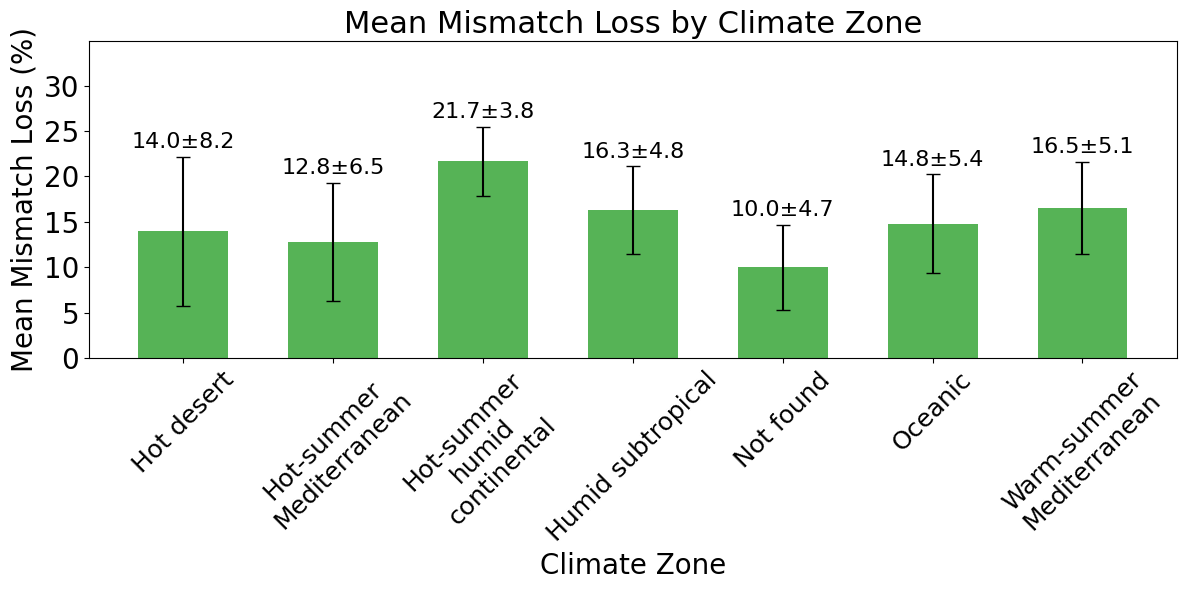

In [9]:
# --- 2.1.2.3. Mean Mismatch Loss by Climate Zone (Combined) ---

# compute mean & std by Climate Zone
stats_zone = site_summary_df.groupby('Climate Zone')['Mismatch Loss'].agg(['mean','std']).reset_index()

# prepare x‐positions
x = np.arange(len(stats_zone))
bar_width = 0.6

plt.figure(figsize=long_hoz_figsize)
bars = plt.bar(
    x,
    stats_zone['mean'],
    yerr=stats_zone['std'],
    width=bar_width,
    alpha=0.8,
    capsize=5,
    color='C2'
)

plt.xlabel('Climate Zone', fontsize=axis_label_size)
plt.ylabel('Mean Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mean Mismatch Loss by Climate Zone', fontsize=title_size)

# wrap long labels
wrapped = [
    cz if len(str(cz)) < 18 else '\n'.join(str(cz).split(' '))
    for cz in stats_zone['Climate Zone']
]
plt.xticks(
    ticks=x,
    labels=wrapped,
    rotation=45,
    ha='center',
    fontsize=axis_num_size - 2
)
plt.yticks(fontsize=axis_num_size)
plt.ylim(0, stats_zone['mean'].max() + stats_zone['std'].max() + 5)
plt.tight_layout()

# annotate bars
for bar, m, s in zip(bars, stats_zone['mean'], stats_zone['std']):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        m + s + 0.5,
        f"{m:.1f}±{s:.1f}",
        ha='center', va='bottom',
        fontsize=axis_num_size - 4
    )

plt.show()

### 2.1.3. Season

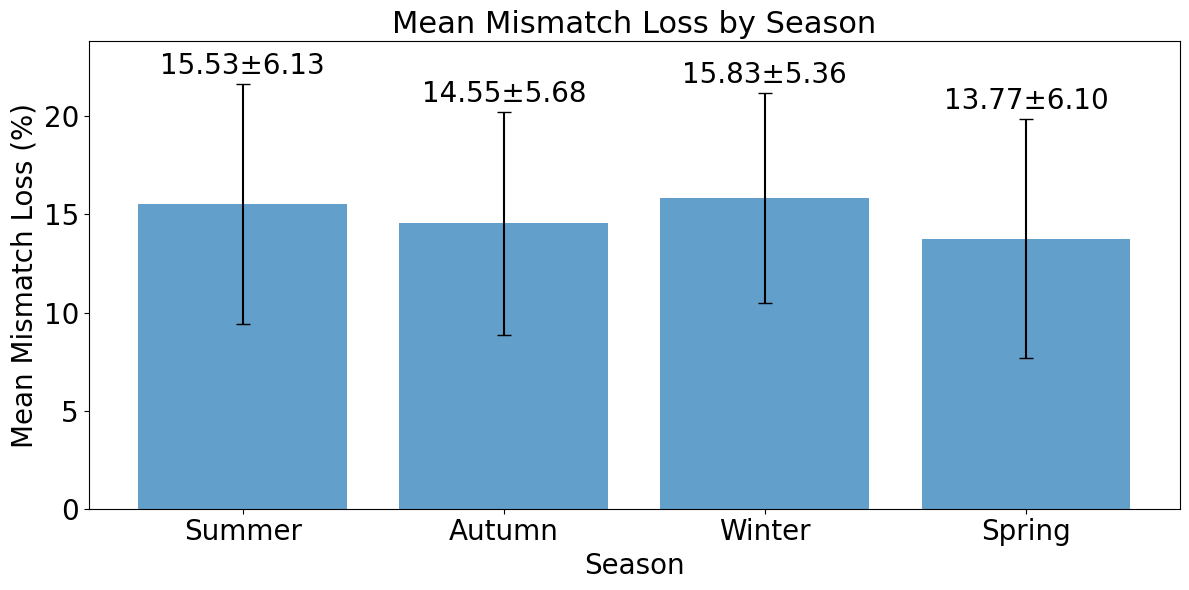

In [10]:
df = pd.read_excel(os.path.join(ResultsFolder, 'new_and_old_with_climate_zone.xlsx'))

# 2. Specify the seasonal columns exactly as they appear
season_cols = [
    'summer Mismatch Loss (%)',
    'autumn Mismatch Loss (%)',
    'winter Mismatch Loss (%)',
    'spring Mismatch Loss (%)'
]

# 3. Compute mean & std for each season column
means = df[season_cols].mean()
stds  = df[season_cols].std()

# 4. Create readable season labels
seasons = [col.split()[0].capitalize() for col in season_cols]

# 5. Plot bar chart with error bars
plt.figure(figsize=long_hoz_figsize)
bars = plt.bar(
    seasons,
    means,
    yerr=stds,
    capsize=5,
    alpha=0.7
)

plt.xlabel('Season', fontsize=axis_label_size)
plt.ylabel('Mean Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mean Mismatch Loss by Season', fontsize=title_size)

plt.xticks(fontsize=axis_num_size)
plt.yticks(fontsize=axis_num_size)
plt.ylim(0, (means + stds).max() * 1.1)

# 6. Annotate each bar with mean ± std
for bar, m, s in zip(bars, means, stds):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        m + s + 0.2,
        f"{m:.2f}±{s:.2f}",
        ha='center',
        va='bottom',
        fontsize=text_size
    )

plt.tight_layout()
plt.show()


## 2.2. Using the data where season are different row

### 2.2.1. Overall hist

In [11]:
# plot a histogram of the mismatch loss
plt.figure(figsize=figure_size)
plt.hist(combined_df['Mismatch Loss (%)'], bins=9, color='blue', alpha=0.7, edgecolor='black')

# Calculate mean, median, and std
mean_val = combined_df['Mismatch Loss (%)'].mean()
median_val = combined_df['Mismatch Loss (%)'].median()
std_val = combined_df['Mismatch Loss (%)'].std()

# Plot vertical lines for mean and median
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f"Mean = {mean_val:.2f}%")
plt.axvline(median_val, color='black', linestyle='-.', linewidth=2, label=f"Median = {median_val:.2f}%")

plt.xlabel('Mismatch Loss (%)', fontsize=axis_label_size)
plt.ylabel('Frequency', fontsize=axis_label_size)
plt.title(f'Histogram of Mismatch Loss\nMean = {mean_val:.2f}% ± {std_val:.2f}%', fontsize=title_size)
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=axis_num_size)
plt.yticks(fontsize=axis_num_size)
plt.legend(fontsize=axis_num_size)
plt.show()

### 2.2.2. Plot against mean frequency

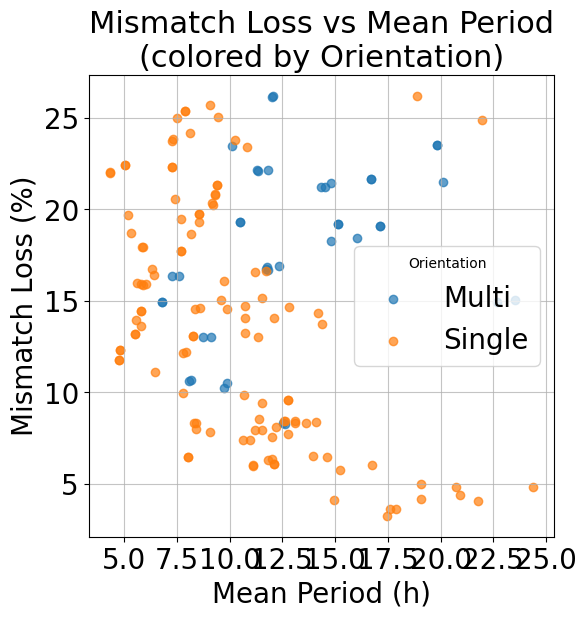

Multi: Slope = 0.3811
Single: Slope = -0.7588


Shaded: Slope = 0.3190
Unshaded: Slope = -0.3388


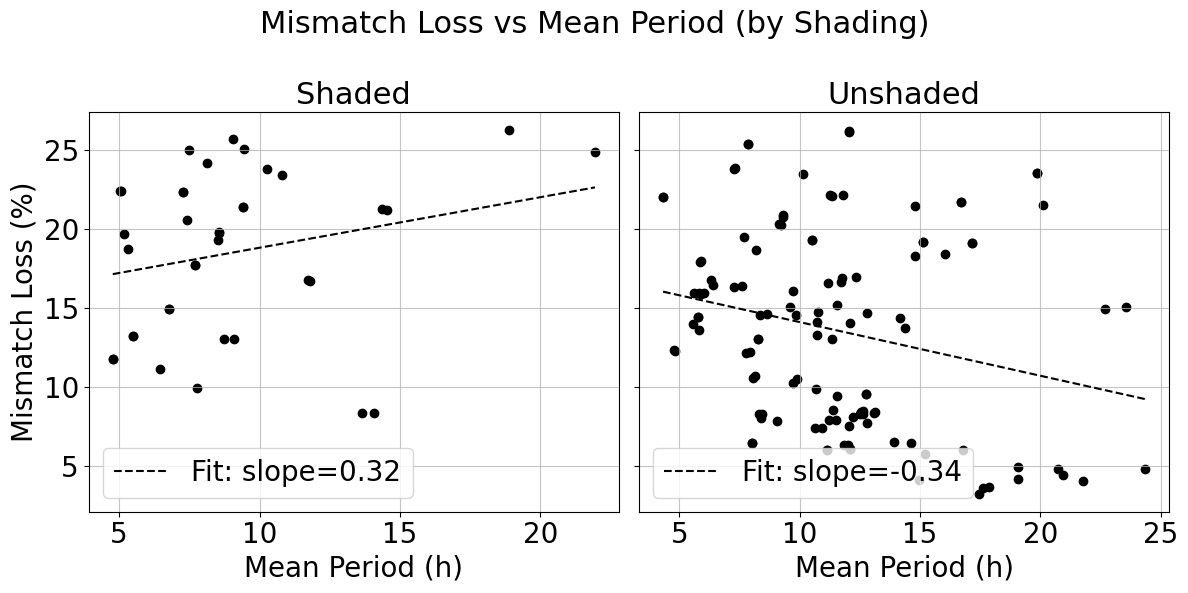

In [12]:
# plot the mismatch loss vs mean period, colored by orientation
plt.figure(figsize=figure_size)
orientations = combined_df['Orientation'].unique()
colors = plt.cm.tab10.colors  # up to 10 unique colors

for idx, orientation in enumerate(orientations):
    subset = combined_df[combined_df['Orientation'] == orientation]
    plt.scatter(
        subset['Mean Period (h)'],
        subset['Mismatch Loss (%)'],
        color=colors[idx % len(colors)],
        alpha=0.7,
        label=str(orientation)
    )

plt.xlabel('Mean Period (h)', fontsize=axis_label_size)
plt.ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mismatch Loss vs Mean Period\n(colored by Orientation)', fontsize=title_size)
plt.grid(alpha=0.75)
plt.xticks(fontsize=axis_num_size)
plt.yticks(fontsize=axis_num_size)
plt.legend(title='Orientation', fontsize=axis_num_size)
plt.show()



# plot the mismatch loss vs mean period, colored by Shade
plt.figure(figsize=figure_size)
shades = combined_df['Shade'].unique()
colors = plt.cm.tab10.colors  # up to 10 unique colors

for idx, shade in enumerate(shades):
    subset = combined_df[combined_df['Shade'] == shade]
    plt.scatter(
        subset['Mean Period (h)'],
        subset['Mismatch Loss (%)'],
        color=colors[idx % len(colors)],
        alpha=0.7,
        label=str(shade)
    )

plt.xlabel('Mean Period (h)', fontsize=axis_label_size)
plt.ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mismatch Loss vs Mean Period\n(colored by Shade)', fontsize=title_size)
plt.grid(alpha=0.75)
plt.xticks(fontsize=axis_num_size)
plt.yticks(fontsize=axis_num_size)
plt.legend(title='Shade', fontsize=axis_num_size)
plt.show()


# 2-column, 1-row subplot: left for 'Multi', right for 'Single', with straight line fit and slope

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Filter for 'Single' and 'Multi' (assuming a column 'Type' exists; adjust if needed)
multi_df = combined_df[combined_df['Orientation'].str.lower() == 'multi']
single_df = combined_df[combined_df['Orientation'].str.lower() == 'single']
# Left: Multi
orientations = multi_df['Orientation'].unique()
colors = plt.cm.tab10.colors
ax = axes[0]
for idx, orientation in enumerate(orientations):
    subset = multi_df[multi_df['Orientation'] == orientation]
    ax.scatter(
        subset['Mean Period (h)'],
        subset['Mismatch Loss (%)'],
        color='black',
    )
# Fit line
if not multi_df.empty:
    x = multi_df['Mean Period (h)'].values
    y = multi_df['Mismatch Loss (%)'].values
    if len(x) > 1:
        coeffs = np.polyfit(x, y, 1)
        slope = coeffs[0]
        xfit = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        yfit = np.polyval(coeffs, xfit)
        ax.plot(xfit, yfit, 'k--', label=f'Fit: slope={slope:.2f}')
        print(f"Multi: Slope = {slope:.4f}")
    else:
        slope = np.nan
ax.set_xlabel('Mean Period (h)', fontsize=axis_label_size)
ax.set_ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
ax.set_title('Multi', fontsize=title_size)
ax.tick_params(axis='y', labelsize=axis_num_size)
ax.tick_params(axis='x', labelsize=axis_num_size)
ax.grid(alpha=0.75)
ax.legend(fontsize=axis_num_size, loc='lower left')

# Right: Single
orientations = single_df['Orientation'].unique()
ax = axes[1]
for idx, orientation in enumerate(orientations):
    subset = single_df[single_df['Orientation'] == orientation]
    ax.scatter(
        subset['Mean Period (h)'],
        subset['Mismatch Loss (%)'],
        color='black',
    )
# Fit line
if not single_df.empty:
    x = single_df['Mean Period (h)'].values
    y = single_df['Mismatch Loss (%)'].values
    if len(x) > 1:
        coeffs = np.polyfit(x, y, 1)
        slope = coeffs[0]
        xfit = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        yfit = np.polyval(coeffs, xfit)
        ax.plot(xfit, yfit, 'k--', label=f'Fit: slope={slope:.2f}')
        print(f"Single: Slope = {slope:.4f}")
    else:
        slope = np.nan
ax.set_xlabel('Mean Period (h)', fontsize=axis_label_size)
ax.tick_params(axis='y', labelsize=axis_num_size)
ax.tick_params(axis='x', labelsize=axis_num_size)
ax.set_title('Single', fontsize=title_size)
ax.grid(alpha=0.75)
ax.legend(fontsize=axis_num_size, loc='lower left')

plt.suptitle('Mismatch Loss vs Mean Period', fontsize=title_size)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




# 2-column, 1-row subplot: left for 'Shaded', right for 'Unshaded', with straight line fit and slope

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Filter for 'Shaded' (yes) and 'Unshaded' (no)
shaded_df = combined_df[combined_df['Shade'].str.lower() == 'yes']
unshaded_df = combined_df[combined_df['Shade'].str.lower() == 'no']

# Left: Shaded
shades = shaded_df['Shade'].unique()
colors = plt.cm.tab10.colors
ax = axes[0]
for idx, shade in enumerate(shades):
    subset = shaded_df[shaded_df['Shade'] == shade]
    ax.scatter(
        subset['Mean Period (h)'],
        subset['Mismatch Loss (%)'],
        color='black',
    )
# Fit line
if not shaded_df.empty:
    x = shaded_df['Mean Period (h)'].values
    y = shaded_df['Mismatch Loss (%)'].values
    if len(x) > 1:
        coeffs = np.polyfit(x, y, 1)
        slope = coeffs[0]
        xfit = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        yfit = np.polyval(coeffs, xfit)
        ax.plot(xfit, yfit, 'k--', label=f'Fit: slope={slope:.2f}')
        print(f"Shaded: Slope = {slope:.4f}")
    else:
        slope = np.nan
ax.set_xlabel('Mean Period (h)', fontsize=axis_label_size)
ax.set_ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
ax.set_title('Shaded', fontsize=title_size)
ax.tick_params(axis='y', labelsize=axis_num_size)
ax.tick_params(axis='x', labelsize=axis_num_size)
ax.grid(alpha=0.75)
ax.legend(fontsize=axis_num_size, loc='lower left')

# Right: Unshaded
shades = unshaded_df['Shade'].unique()
ax = axes[1]
for idx, shade in enumerate(shades):
    subset = unshaded_df[unshaded_df['Shade'] == shade]
    ax.scatter(
        subset['Mean Period (h)'],
        subset['Mismatch Loss (%)'],
        color='black',
    )
# Fit line
if not unshaded_df.empty:
    x = unshaded_df['Mean Period (h)'].values
    y = unshaded_df['Mismatch Loss (%)'].values
    if len(x) > 1:
        coeffs = np.polyfit(x, y, 1)
        slope = coeffs[0]
        xfit = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        yfit = np.polyval(coeffs, xfit)
        ax.plot(xfit, yfit, 'k--', label=f'Fit: slope={slope:.2f}')
        print(f"Unshaded: Slope = {slope:.4f}")
    else:
        slope = np.nan
ax.set_xlabel('Mean Period (h)', fontsize=axis_label_size)
ax.tick_params(axis='y', labelsize=axis_num_size)
ax.tick_params(axis='x', labelsize=axis_num_size)
ax.set_title('Unshaded', fontsize=title_size)
ax.grid(alpha=0.75)
ax.legend(fontsize=axis_num_size, loc='lower left')

plt.suptitle('Mismatch Loss vs Mean Period (by Shading)', fontsize=title_size)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 2.2.3. Group by country hist

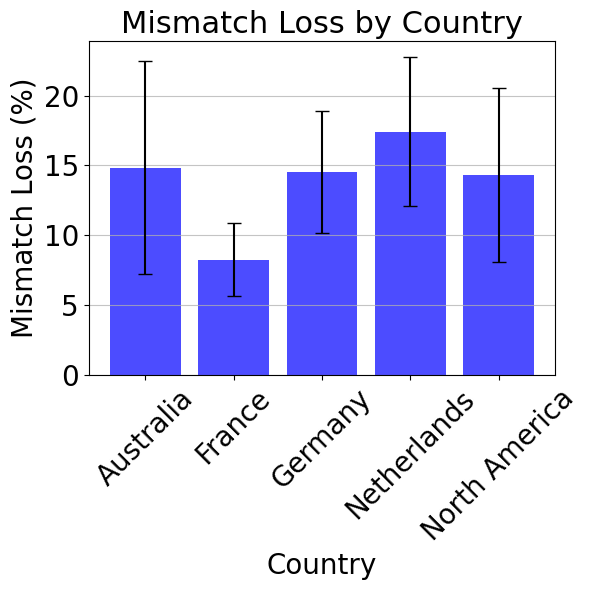

In [13]:

# Group by country and calculate mean and std for mismatch loss
country_stats = combined_df.groupby('Country')['Mismatch Loss (%)'].agg(['mean', 'std'])

plt.figure(figsize=figure_size)
plt.bar(
    country_stats.index,
    country_stats['mean'],
    yerr=country_stats['std'],
    color='blue',
    alpha=0.7,
    capsize=5
)
plt.xlabel('Country', fontsize=axis_label_size)
plt.ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mismatch Loss by Country', fontsize=title_size)
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, fontsize=axis_num_size)
plt.yticks(fontsize=axis_num_size)
plt.tight_layout()
plt.show()

### 2.2.4. Group by orientation hist

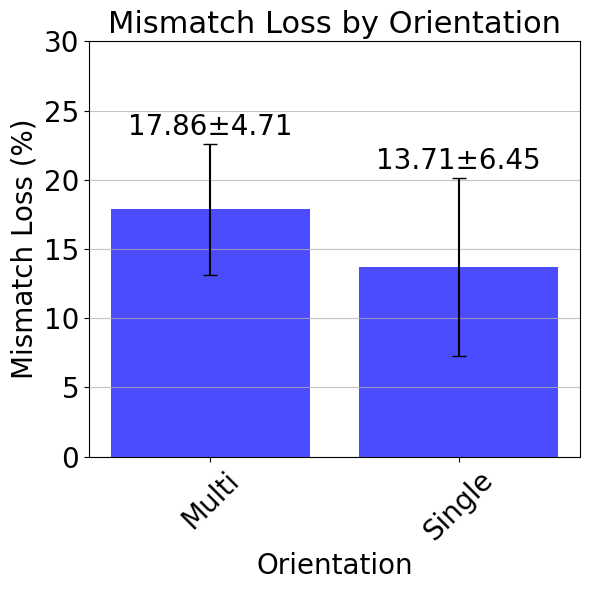

In [14]:
# group by the orientation and calculate mean and std for mismatch loss
orientation_stats = combined_df.groupby('Orientation')['Mismatch Loss (%)'].agg(['mean', 'std'])

plt.figure(figsize=figure_size)
bars = plt.bar(
    orientation_stats.index,
    orientation_stats['mean'],
    yerr=orientation_stats['std'],
    color='blue',
    alpha=0.7,
    capsize=5
)
plt.xlabel('Orientation', fontsize=axis_label_size)
plt.ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mismatch Loss by Orientation', fontsize=title_size)
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, fontsize=axis_num_size)
plt.yticks(fontsize=axis_num_size)
plt.tight_layout()
plt.ylim(0, 30)
# Add value and std on top of each bar
for bar, mean, std in zip(bars, orientation_stats['mean'], orientation_stats['std']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + std + 0.2,
        f"{mean:.2f}±{std:.2f}",
        ha='center',
        va='bottom',
        fontsize=axis_num_size
    )
plt.show()

### 2.2.5. Group by shading

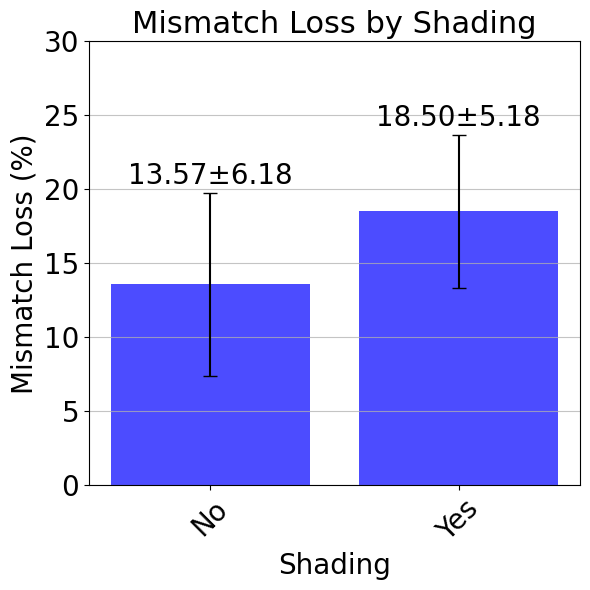

In [15]:
# group by shading and calculate mean and std for mismatch loss
shading_stats = combined_df.groupby('Shade')['Mismatch Loss (%)'].agg(['mean', 'std'])
plt.figure(figsize=figure_size)
bars = plt.bar(
    shading_stats.index,
    shading_stats['mean'],
    yerr=shading_stats['std'],
    color='blue',
    alpha=0.7,
    capsize=5
)
plt.xlabel('Shading', fontsize=axis_label_size)
plt.ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mismatch Loss by Shading', fontsize=title_size)
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, fontsize=axis_num_size)
plt.yticks(fontsize=axis_num_size)
plt.tight_layout()
plt.ylim(0, 30)
# Add value and std on top of each bar
for bar, mean, std in zip(bars, shading_stats['mean'], shading_stats['std']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + std + 0.2,
        f"{mean:.2f}±{std:.2f}",
        ha='center',
        va='bottom',
        fontsize=axis_num_size
    )
plt.show()

### 2.2.6. Group by season

In [16]:
# group by season and calculate mean and std for mismatch loss
season_stats = combined_df.groupby('Season')['Mismatch Loss (%)'].agg(['mean', 'std'])
plt.figure(figsize=figure_size)
bars = plt.bar(
    season_stats.index,
    season_stats['mean'],
    yerr=season_stats['std'],
    color='blue',
    alpha=0.7,
    capsize=5
)
plt.xlabel('Season', fontsize=axis_label_size)
plt.ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mismatch Loss by Season', fontsize=title_size)
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, fontsize=axis_num_size)
plt.yticks(fontsize=axis_num_size)
plt.tight_layout()
plt.ylim(0, 30)
# Add value and std on top of each bar
for bar, mean, std in zip(bars, season_stats['mean'], season_stats['std']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + std + 0.2,
        f"{mean:.2f}±{std:.2f}",
        ha='center',
        va='bottom',
        fontsize=axis_num_size-10
    )
plt.show()

### 2.2.7. Plot against sytem size

autumn: Slope = 0.0145
spring: Slope = -0.1209
summer: Slope = 0.1009
winter: Slope = 0.3753


autumn: Slope = -0.0537
summer: Slope = 0.1395
winter: Slope = -0.4132
spring: Slope = 0.2805


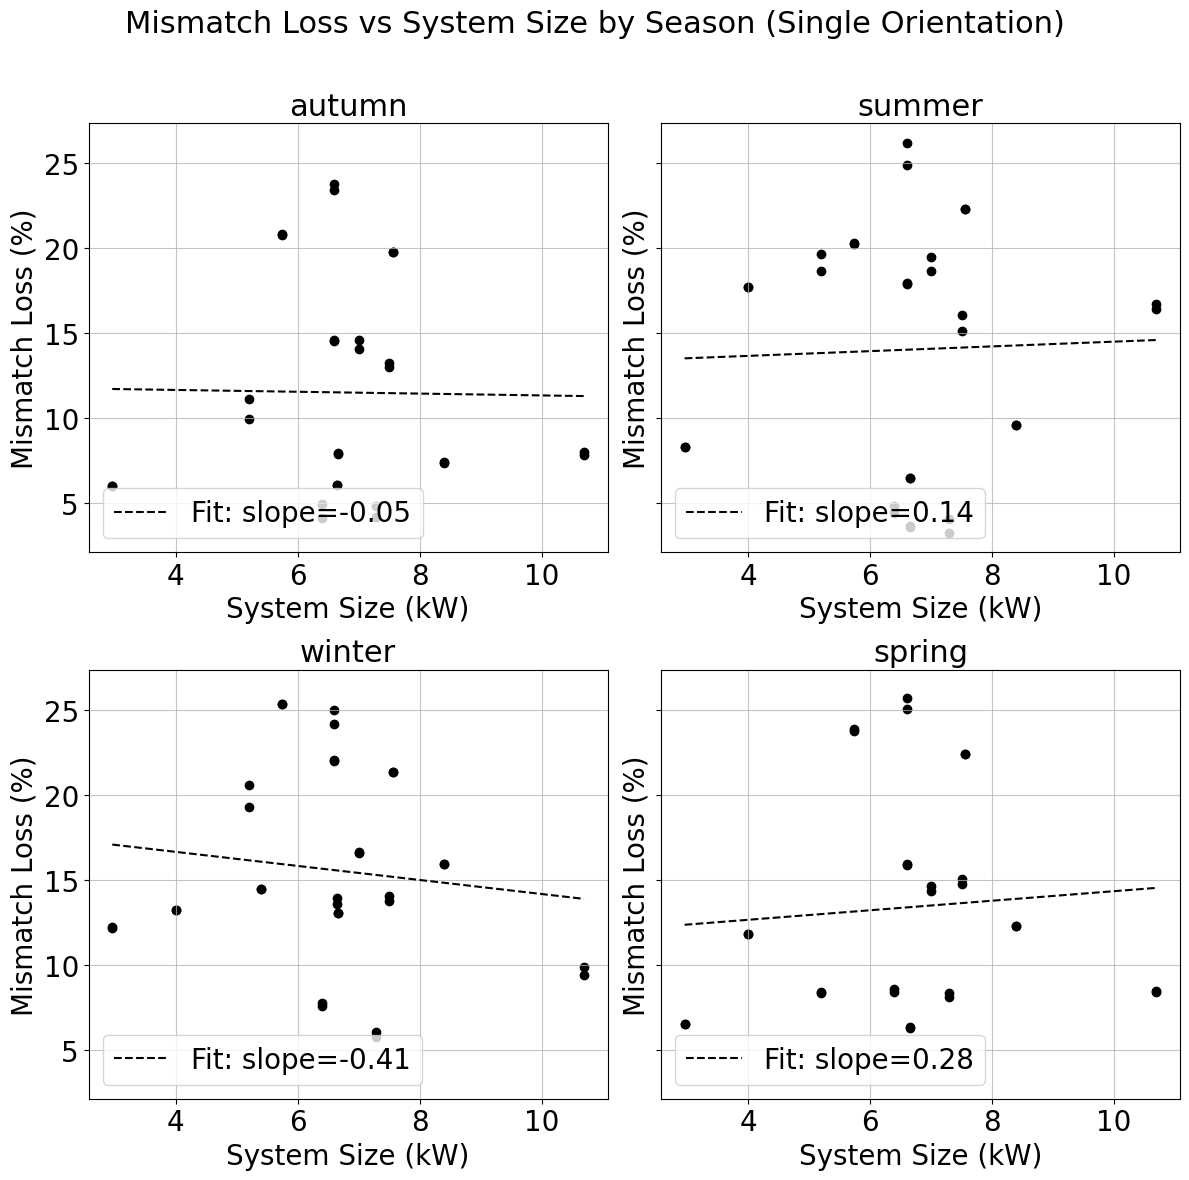

In [17]:
# only plot the site with multiple orientations
multiple_orientations = combined_df[combined_df['Orientation'].str.lower() == 'multi']

# create a new figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=two_by_two_figsize, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# group by season and plot the mismatch loss vs system size
seasons = multiple_orientations['Season'].unique()
for idx, season in enumerate(seasons):
    ax = axes.flatten()[idx]  # Use a different subplot for each season
    subset = multiple_orientations[multiple_orientations['Season'] == season]
    ax.scatter(
        subset['kWp'],
        subset['Mismatch Loss (%)'],
        color='black'
    )
    # Fit line
    if not subset.empty:
        x = subset['kWp'].values
        y = subset['Mismatch Loss (%)'].values
        if len(x) > 1:
            coeffs = np.polyfit(x, y, 1)
            slope = coeffs[0]
            xfit = np.linspace(np.nanmin(x), np.nanmax(x), 100)
            yfit = np.polyval(coeffs, xfit)
            ax.plot(xfit, yfit, 'k--', label=f'Fit: slope={slope:.2f}')
            print(f"{season}: Slope = {slope:.4f}")
        else:
            slope = np.nan
    ax.set_xlabel('System Size (kW)', fontsize=axis_label_size)
    ax.set_ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
    ax.set_title(f'{season}', fontsize=title_size)
    ax.tick_params(axis='y', labelsize=axis_num_size)
    ax.tick_params(axis='x', labelsize=axis_num_size)
    ax.grid(alpha=0.75)
    ax.legend(fontsize=axis_num_size, loc='lower left')  # Only fit line in legend

plt.suptitle('Mismatch Loss vs System Size by Season (Multi Orientation)', fontsize=title_size)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# only plot the site with single orientation
single_orientations = combined_df[combined_df['Orientation'].str.lower() == 'single']

# create a new figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=two_by_two_figsize, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# group by season and plot the mismatch loss vs system size
seasons = single_orientations['Season'].unique()
for idx, season in enumerate(seasons):
    ax = axes.flatten()[idx]  # Use a different subplot for each season
    subset = single_orientations[single_orientations['Season'] == season]
    ax.scatter(
        subset['kWp'],
        subset['Mismatch Loss (%)'],
        color='black'
    )
    # Fit line
    if not subset.empty:
        x = subset['kWp'].values
        y = subset['Mismatch Loss (%)'].values
        if len(x) > 1:
            coeffs = np.polyfit(x, y, 1)
            slope = coeffs[0]
            xfit = np.linspace(np.nanmin(x), np.nanmax(x), 100)
            yfit = np.polyval(coeffs, xfit)
            ax.plot(xfit, yfit, 'k--', label=f'Fit: slope={slope:.2f}')
            print(f"{season}: Slope = {slope:.4f}")
        else:
            slope = np.nan
    ax.set_xlabel('System Size (kW)', fontsize=axis_label_size)
    ax.set_ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
    ax.set_title(f'{season}', fontsize=title_size)
    ax.tick_params(axis='y', labelsize=axis_num_size)
    ax.tick_params(axis='x', labelsize=axis_num_size)
    ax.grid(alpha=0.75)
    ax.legend(fontsize=axis_num_size, loc='lower left')  # Only fit line in legend

plt.suptitle('Mismatch Loss vs System Size by Season (Single Orientation)', fontsize=title_size)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 3. Internal bypass diode study by system

In [18]:
# define the site id
site_id = '4184502'
# define the season
season = 'winter'

## 3.1. Voc outlier detector

* If has Voc higher than normal, labelld 1
* If loss 1/3 of Voc, labelled -1
* If loss 2/3 of Voc, labelled -2
* Else, labelled 0

In [19]:

# define the iqr factor for Voc too high
iqr_factor_1 = 1.5
# define the iqr factor for lossing 1/3 of Voc
iqr_factor_n1 = 10
# define the iqr factor for lossing 2/3 of Voc
iqr_factor_n2 = 15

def outlier_1_identifier(row, iqr_factor=iqr_factor_1, min_dvoc = 2):
    '''
    Identify outliers using the IQR method. This corresponding to the case when Voc is too high.
    '''
    q1 = row.quantile(0.25)
    q3 = row.quantile(0.75)
    iqr = q3 - q1
    upper = q3 + max(iqr_factor * iqr, min_dvoc)
    return row > upper

# def outlier_n1_identifier(row, iqr_factor=iqr_factor_n1):
#     '''
#     Identify outliers using the IQR method. This corresponding to the case when we loss 1/3 of Voc
#     '''
#     q1 = row.quantile(0.25)
#     q3 = row.quantile(0.75)
#     iqr = q3 - q1
#     lower = q1 - iqr_factor * iqr
#     return row < lower

# def outlier_n2_identifier(row, iqr_factor=iqr_factor_n2):
#     '''
#     Identify outliers using the IQR method. This corresponding to the case when we loss 2/3 of Voc
#     '''
#     q1 = row.quantile(0.25)
#     q3 = row.quantile(0.75)
#     iqr = q3 - q1
#     lower = q1 - iqr_factor * iqr
#     return row < lower

# Find the folder
target_folder = None
for folder in os.listdir(ResultsFolder):
    if site_id in folder and season in folder.lower():
        target_folder = os.path.join(ResultsFolder, folder)
        print(f"Found target folder: {target_folder}")
        break

if target_folder is not None:
    # List files in the folder
    files = os.listdir(target_folder)
    # look for a csv file that contains the word module
    for file in files:
        if 'module' in file.lower() and file.endswith('.csv'):
            target_file = os.path.join(target_folder, file)
            print(f"Found file: {target_file}")
            # read the csv file
            df = pd.read_csv(target_file)


            # # remove any row with NaN values
            # df = df.dropna()
            # print(df)
            # # …existing code…
            # df_pivot = df.pivot(
            #     index=['Timestamp'],
            #     columns=['Optimizer'],
            #     values=['I0', 'Isc', 'Voc', 'FF', 'Pmp', 'Imp', 'Vmp']
            # ).dropna()
            # print('df_pivot shape:', df_pivot.shape)

            df = df.dropna(how='all')   # only toss rows that are 100% NaN

            df_pivot = df.pivot_table(
                index   ='Timestamp',
                columns ='Optimizer',
                values  =['I0','Isc','Voc','FF','Pmp','Imp','Vmp'],
                aggfunc ='first'
            )

            # if you really want to lose only optimizers that never showed up:
            df_pivot = df_pivot.dropna(axis=1, how='all')

            print('df_pivot shape:', df_pivot.shape)


            # ensure the index is datetime
            df_pivot.index = pd.to_datetime(df_pivot.index)

            # --- flatten the MultiIndex columns to simple strings ---
            df_pivot.columns = ['{}_{}'.format(var, opt) for var, opt in df_pivot.columns]

            # find the flattened Voc columns
            voc_cols = [c for c in df_pivot.columns if c.startswith('Voc_')]

            # calculate the median of the Voc rows
            # voc_median = df_pivot[voc_cols].median(axis=0)

            # compute three outlier masks row‐wise
            mask1   = df_pivot[voc_cols].apply(lambda row: outlier_1_identifier(row), axis=1)
            # mask_n1 = df_pivot[voc_cols].apply(lambda row: outlier_n1_identifier(row), axis=1)
            # mask_n2 = df_pivot[voc_cols].apply(lambda row: outlier_n2_identifier(row), axis=1)
            
            # define mask_n1 & mask_n2 using the median of each row
            mask_n1 = df_pivot[voc_cols].apply(
                lambda row: (row < 2/3 * row.quantile(0.75)) & (row > 1/3 * row.quantile(0.75)),
                axis=1
            )
            mask_n2 = df_pivot[voc_cols].apply(
                lambda row: row < 1/3 * row.quantile(0.75),
                axis=1
            )
            # combine all masks into a single label a single label: 
            #   1 if mask1, -1 if mask_n1, -2 if mask_n2, else 0
            for col in voc_cols:
                df_pivot[f'{col}_outlier_label'] = np.where(
                    mask1[col],   1,
                    np.where(mask_n1[col], -1,
                            np.where(mask_n2[col], -2, 0))
                )

            # print the outlier labels
            print(df_pivot[[col for col in df_pivot.columns if col.endswith('_outlier_label')]].head(10))


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4184502_winter_20250519_132403
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4184502_winter_20250519_132403\module_param_df.csv
df_pivot shape: (1247, 98)
                     Voc_261526118_outlier_label  Voc_261526500_outlier_label  \
Timestamp                                                                       
2024-12-15 07:25:00                            0                            0   
2024-12-15 07:30:00                            0                            0   
2024-12-15 07:35:00                            0                            0   
2024-12-15 07:40:00                            0                            0   
2024-12-15 07:45:00                            0                            0   
2024-12-15 07:50:00                            0               

## 3.2. Voc outlier visualiser (keep as comment if not using)

In [20]:
# # 3.2. Voc outlier visualiser (with separate lower/upper bounds)
# voc_cols   = [c for c in df_pivot.columns
#               if c.startswith('Voc_') and not c.endswith('_outlier_label')]
# label_cols = [f'{c}_outlier_label' for c in voc_cols]

# for timestamp, group in df_pivot.groupby(level=0):
#     # only plot timestamps where at least one Voc has a "-1" label
#     if (group[label_cols] == -1).any(axis=1).any():
#         vals = group[voc_cols].values.flatten()

#         # compute quartiles and IQR
#         q1, q3  = np.percentile(vals, [25, 75])
#         iqr     = q3 - q1
#         upper_fence    = q3 + iqr_factor_1  * iqr
#         lower_fence_n1 = q1 - iqr_factor_n1 * iqr
#         lower_fence_n2 = q1 - iqr_factor_n2 * iqr

#         fig, ax = plt.subplots(figsize=figure_size)
#         # draw boxplot without custom 'whis' to avoid percentile errors
#         ax.boxplot(
#             vals,
#             vert=True,
#             patch_artist=True,
#             showfliers=False
#         )

#         # overlay custom fence lines
#         ax.axhline(upper_fence,    color='red',    linestyle='--',
#                    label=f'High bound: {upper_fence:.2f} V')
#         ax.axhline(lower_fence_n1, color='orange', linestyle='-.',
#                    label=f'Low bound (1/3 loss): {lower_fence_n1:.2f} V')
#         ax.axhline(lower_fence_n2, color='purple', linestyle=':',
#                    label=f'Low bound (2/3 loss): {lower_fence_n2:.2f} V')

#         # highlight actual outliers
#         out_high = vals[vals > upper_fence]
#         out_n1   = vals[vals < lower_fence_n1]
#         out_n2   = vals[(vals >= lower_fence_n1) & (vals < lower_fence_n2)]
#         xh = np.random.normal(1, 0.02, size=out_high.size)
#         xn1= np.random.normal(1, 0.02, size=out_n1.size)
#         xn2= np.random.normal(1, 0.02, size=out_n2.size)
#         ax.scatter(xh, out_high, c='red',    label='_nolegend_')
#         ax.scatter(xn1, out_n1,   c='orange', label='_nolegend_')
#         ax.scatter(xn2, out_n2,   c='purple', label='_nolegend_')

#         # labels & legend
#         ax.set_title(f'Voc distribution at {timestamp}', fontsize=title_size)
#         ax.set_ylabel('Voc (V)', fontsize=axis_label_size)
#         ax.tick_params(axis='both', labelsize=axis_num_size)
#         ax.grid(axis='y', ls='--', alpha=0.7)
#         ax.legend(
#             loc='upper left',
#             bbox_to_anchor=(1.02, 1),
#             borderaxespad=0,
#             fontsize=axis_num_size
#         )

#         # adjust layout and display
#         fig.tight_layout(rect=[0, 0, 0.8, 1])
#         plt.show()

## 3.3. Isc outlier detector

* If Isc is upper outlier, it is labelled as 1
* If Isc is lower outlier, it is labelled as -1
* Otherwise it is labelled as 0

In [21]:
# 3.3. Isc outlier detector (only high vs low)

# define I-V specific IQR factor for Isc
iqr_factor_isc_low = 1.5
iqr_factor_isc_high = 3

def outlier_isc_high(row, iqr_factor=iqr_factor_isc_high, min_iqr=0.5):
    """Isc too high, with min IQR enforcement"""
    q1, q3   = row.quantile([0.25, 0.75])
    raw_iqr  = q3 - q1
    iqr_val  = raw_iqr if raw_iqr >= min_iqr else min_iqr
    upper    = q3 + iqr_factor * iqr_val
    return row > upper

def outlier_isc_low(row, iqr_factor=iqr_factor_isc_low,  min_iqr=0.5):
    """Isc too low, with min IQR enforcement"""
    q1, q3   = row.quantile([0.25, 0.75])
    raw_iqr  = q3 - q1
    iqr_val  = raw_iqr if raw_iqr >= min_iqr else min_iqr
    lower    = q1 - iqr_factor * iqr_val
    return row < lower

# find all flattened Isc columns
isc_cols = [c for c in df_pivot.columns if c.startswith('Isc_')]

# compute high/low masks
mask_high_isc = df_pivot[isc_cols].apply(outlier_isc_high, axis=1)
mask_low_isc  = df_pivot[isc_cols].apply(outlier_isc_low,  axis=1)

# assign labels: 1 if too high, -1 if too low, else 0
for col in isc_cols:
    df_pivot[f'{col}_outlier_label'] = np.where(
        mask_high_isc[col],  1,
        np.where(mask_low_isc[col], -1, 0)
    )

# preview the new Isc outlier labels
print(df_pivot[[c for c in df_pivot.columns
                if c.startswith('Isc_') and c.endswith('_outlier_label')]].head(10))

                     Isc_261526118_outlier_label  Isc_261526500_outlier_label  \
Timestamp                                                                       
2024-12-15 07:25:00                            0                            0   
2024-12-15 07:30:00                            0                            0   
2024-12-15 07:35:00                            0                            0   
2024-12-15 07:40:00                            0                            0   
2024-12-15 07:45:00                            0                            0   
2024-12-15 07:50:00                            0                            0   
2024-12-15 07:55:00                            0                            0   
2024-12-15 08:00:00                            0                            0   
2024-12-15 08:05:00                            0                            0   
2024-12-15 08:10:00                            0                            0   

                     Isc_26

## 3.4. Isc outlier visualiser (keep as comment)

In [22]:
# # 3.4. Isc outlier visualiser (with separate high/low bounds)

# # flattened Isc columns & their label columns
# isc_cols   = [c for c in df_pivot.columns if c.startswith('Isc_') and not c.endswith('_outlier_label')]
# label_cols = [f'{c}_outlier_label' for c in isc_cols]

# for timestamp, group in df_pivot.groupby(level=0):
#     # skip timestamps without any Isc outlier
#     if not (group[label_cols] != 0).any(axis=1).any():
#         continue

#     # collect all Isc values at this timestamp
#     vals = group[isc_cols].values.flatten()
#     # compute fences
#     q1, q3        = np.percentile(vals, [25, 75])
#     iqr           = q3 - q1
#     upper_fence   = q3 + iqr_factor_isc_high * iqr
#     lower_fence   = q1 - iqr_factor_isc_low * iqr

#     fig, ax = plt.subplots(figsize=figure_size)
#     # boxplot without default fliers, using custom whiskers
#     ax.boxplot(
#         vals,
#         vert=True,
#         patch_artist=True,
#         showfliers=False
#         # removed whis=(lower_fence, upper_fence)
#     )

#     # plot fence lines
#     ax.axhline(upper_fence, color='red',    linestyle='--',
#                label=f'High bound: {upper_fence:.2f} A')
#     ax.axhline(lower_fence, color='orange', linestyle='-.',
#                label=f'Low bound:  {lower_fence:.2f} A')

#     # highlight actual outliers
#     out_high = vals[vals > upper_fence]
#     out_low  = vals[vals < lower_fence]
#     xh = np.random.normal(1, 0.02, size=out_high.size)
#     xl = np.random.normal(1, 0.02, size=out_low.size)
#     ax.scatter(xh, out_high, c='red',    label='_nolegend_')
#     ax.scatter(xl, out_low,  c='orange', label='_nolegend_')

#     # styling
#     ax.set_title(f'Isc distribution at {timestamp}', fontsize=title_size)
#     ax.set_ylabel('Isc (A)', fontsize=axis_label_size)
#     ax.tick_params(axis='both', labelsize=axis_num_size)
#     ax.grid(axis='y', ls='--', alpha=0.7)
#     ax.legend(
#         loc='upper left',
#         bbox_to_anchor=(1.02, 1),
#         borderaxespad=0,
#         fontsize=axis_num_size
#     )
#     fig.tight_layout(rect=[0, 0, 0.8, 1])
#     plt.show()

## 3.5. Diode activation condition definition

- For type 1:
    - Description: Isc is not changed but we lose 1/3 of Voc, this is one case when one diode is activated
    - Voc condition: Voc is lower than the 1/3 lower bound
    - Isc condition: not an outlier
- For type 2:
    - Description: Isc is not changedd but we lose 2/3 of Voc, this is one case when two diodes are activated
    - Voc condition: Voc is lower than the 2/3 lower bound
    - Isc condition: not an outlier
- For type -1
    - Description: Isc is an loew outlier, Voc is an higher outlier, this case can happen when 1, 2, or 3 diodes are activated
    - Voc condition: Voc is higher outlier
    - Isc condition: lower outlier
- Others: 0

In [23]:
# …existing code before diode‐activation…

# build lists of your outlier‐label cols
voc_label_cols = [c for c in df_pivot.columns
                  if c.startswith('Voc_') and c.endswith('_outlier_label')]
isc_label_cols = [c for c in df_pivot.columns
                  if c.startswith('Isc_') and c.endswith('_outlier_label')]

# for each Voc_xxx_outlier_label, pick the matching Isc_xxx_outlier_label
for voc_col in voc_label_cols:
    opt     = voc_col.replace('Voc_', '').replace('_outlier_label', '')
    isc_lab = f'Isc_{opt}_outlier_label'
    act_col = f'{opt}_diode_activation'
    if isc_lab not in df_pivot.columns:
        continue

    # define conditions
    conds   = [
        (df_pivot[voc_col] == -1) & (df_pivot[isc_lab] == 0),
        (df_pivot[voc_col] == -2) & (df_pivot[isc_lab] == 0),
        (df_pivot[voc_col] ==  1) & (df_pivot[isc_lab] == -1)
    ]
    choices = [1, 2, -1]

    # assign activation label
    df_pivot[act_col] = np.select(conds, choices, default=0)

    # if actual Isc < 1 A, force activation to 0
    # df_pivot.loc[df_pivot[f'Isc_{opt}'] < 1, act_col] = 0

# ensure the index has a name
df_pivot.index.name = 'Timestamp'

# build output filename with site_id and season, and save into the matching ResultsFolder sub-folder
output_filename = f"{site_id}_{season}_outlier_labels.csv"
output_path     = os.path.join(target_folder or ResultsFolder, output_filename)

df_pivot.to_csv(
    output_path,
    index=True,
    index_label='Timestamp'
)

## 3.6. Diode activation visualise

In [24]:
# collect all diode‐activation columns
act_cols = [c for c in df_pivot.columns if c.endswith('_diode_activation')]

# select rows where any activation ≠ 0
diode_activation = df_pivot[(df_pivot[act_cols] != 0).any(axis=1)]

# for each timestamp and each activated optimiser, print the diode‐activation value
# along with its corresponding Voc and Isc outlier labels
for ts, row in diode_activation.iterrows():
    for act_col in act_cols:
        act_val = row[act_col]
        if act_val != 0:
            opt = act_col.replace('_diode_activation','')
            voc_label = f'Voc_{opt}_outlier_label'
            isc_label = f'Isc_{opt}_outlier_label'
            print(f"{ts} → {act_col}={act_val}, "
                  f"{voc_label}={row.get(voc_label,'NA')}, "
                  f"{isc_label}={row.get(isc_label,'NA')}")

2024-12-15 10:55:00 → 261526500_diode_activation=-1.0, Voc_261526500_outlier_label=1.0, Isc_261526500_outlier_label=-1.0
2024-12-15 12:05:00 → 261526611_diode_activation=-1.0, Voc_261526611_outlier_label=1.0, Isc_261526611_outlier_label=-1.0
2024-12-15 12:05:00 → 261526613_diode_activation=-1.0, Voc_261526613_outlier_label=1.0, Isc_261526613_outlier_label=-1.0
2024-12-16 12:20:00 → 261526613_diode_activation=-1.0, Voc_261526613_outlier_label=1.0, Isc_261526613_outlier_label=-1.0
2024-12-19 11:45:00 → 261526613_diode_activation=-1.0, Voc_261526613_outlier_label=1.0, Isc_261526613_outlier_label=-1.0
2024-12-19 11:50:00 → 261526611_diode_activation=-1.0, Voc_261526611_outlier_label=1.0, Isc_261526611_outlier_label=-1.0
2024-12-19 11:50:00 → 261526613_diode_activation=-1.0, Voc_261526613_outlier_label=1.0, Isc_261526613_outlier_label=-1.0
2024-12-19 11:55:00 → 261526611_diode_activation=-1.0, Voc_261526611_outlier_label=1.0, Isc_261526611_outlier_label=-1.0
2024-12-19 11:55:00 → 261526613_

## 3.7. Update the power file for mismatch calculation

In [25]:
# # remove any timestamp that is collected by diode activation from the combined data file and export a new one

# # find the diode activation timestamps
# diode_activation_timestamps = diode_activation.index

# # ensure it is in datetime format
# diode_activation_timestamps = pd.to_datetime(diode_activation_timestamps)

# # read the file in ResultsFolder that contains the word 'combined' and is an excel file
# for file in os.listdir(target_folder):
#     if 'combined' in file and file.endswith('.xlsx'):
#         combined_file = os.path.join(target_folder, file)
#         break
# else:
#     print(f"No combined file found in {target_folder}")

# # from the combined file, read the first sheet
# combined_df = pd.read_excel(combined_file, sheet_name=0)

# # uensure timestamp is in datetime format
# combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'])

# # use it as index
# combined_df.set_index('Timestamp', inplace=True)

# print(f"Original combined data shape: {combined_df.shape}")

# # remove the diode activation timestamps from the combined data
# combined_df = combined_df[~combined_df.index.isin(diode_activation_timestamps)]

# # create a new file name with '_no_diode_activation' suffix
# new_combined_file = combined_file.replace('.xlsx', '_no_diode_activation.xlsx')
# # save the new combined data to the new file
# combined_df.to_excel(new_combined_file, index=True)

# # print hte shape before and after filtering
# print(f"New combined data shape (after removing diode activation timestamps): {combined_df.shape}")

# 4. Internal diode activation in batch (for all system)

## 4.1. Define parameters

In [26]:
# season list
# seasons = ['spring', 'summer', 'autumn', 'winter']

# system id list
# system_ids = ['4184502', '4184503', '4184504', '4184505']

# create an empty list to store the site_id and season
site_ids = []
seasons = []
# read from the Results folder
for folder in os.listdir(ResultsFolder):
    # check if the folder is a folder rather than a file
    if not os.path.isdir(os.path.join(ResultsFolder, folder)):
        continue
    else:
        site_id = folder.split('_')[0]  # assuming site_id is the first part of the folder name
        season = folder.split('_')[1]  # assuming season is the second part of the folder name
        site_ids.append(site_id)
        seasons.append(season)

# remove duplicates
site_ids = list(set(site_ids))
seasons = list(set(seasons))

# print the site_ids and seasons
print(f"Site IDs: {site_ids}")
print(f"Seasons: {seasons}")

Site IDs: ['4184502', '4118327', '4153809', '4093266', '4112053', '4122216', '4186157', '4162787', '4140175', '4073264', '4172746', '4123602', '4111846', '4197100', '4093272', '4173851', '4002138', '4111492', '4111800', '4034376', '3455043']
Seasons: ['spring', 'summer', 'winter', 'autumn']


## 4.2. Define functions

run the model in session 3 instead of here so that we are consistent

In [27]:
# # define the iqr factor for Voc too high
# iqr_factor_1 = 1.5
# # define the iqr factor for lossing 1/3 of Voc
# iqr_factor_n1 = 10
# # define the iqr factor for lossing 2/3 of Voc
# iqr_factor_n2 = 20

# def outlier_1_identifier(row, iqr_factor=iqr_factor_1):
#     '''
#     Identify outliers using the IQR method. This corresponding to the case when Voc is too high.
#     '''
#     q1 = row.quantile(0.25)
#     q3 = row.quantile(0.75)
#     iqr = q3 - q1
#     upper = q3 + iqr_factor * iqr
#     return row > upper

# # define I-V specific IQR factor for Isc
# iqr_factor_isc_low = 1.5
# iqr_factor_isc_high = 3

# def outlier_isc_high(row, iqr_factor=iqr_factor_isc_high, min_iqr=0.2):
#     """Isc too high, with min IQR enforcement"""
#     q1, q3   = row.quantile([0.25, 0.75])
#     raw_iqr  = q3 - q1
#     iqr_val  = raw_iqr if raw_iqr >= min_iqr else min_iqr
#     upper    = q3 + iqr_factor * iqr_val
#     return row > upper

# def outlier_isc_low(row, iqr_factor=iqr_factor_isc_low,  min_iqr=0.2):
#     """Isc too low, with min IQR enforcement"""
#     q1, q3   = row.quantile([0.25, 0.75])
#     raw_iqr  = q3 - q1
#     iqr_val  = raw_iqr if raw_iqr >= min_iqr else min_iqr
#     lower    = q1 - iqr_factor * iqr_val
#     return row < lower

## 4.3. Run the analysis

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4184502_spring_20250518_154633
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4184502_spring_20250518_154633\module_param_df.csv
df_pivot shape: (1164, 98)
2024-03-18 12:10:00 → 261526613_diode_activation=-1.0, Voc_261526613_outlier_label=1.0, Isc_261526613_outlier_label=-1.0
2024-03-18 12:15:00 → 261526613_diode_activation=-1.0, Voc_261526613_outlier_label=1.0, Isc_261526613_outlier_label=-1.0
2024-03-18 12:20:00 → 261526613_diode_activation=-1.0, Voc_261526613_outlier_label=1.0, Isc_261526613_outlier_label=-1.0
2024-03-18 12:25:00 → 261526613_diode_activation=-1.0, Voc_261526613_outlier_label=1.0, Isc_261526613_outlier_label=-1.0
2024-03-18 12:30:00 → 261526613_diode_activation=-1.0, Voc_261526613_outlier_label=1.0, Isc_261526613_outlier_label=-1.0
2024-03-18 12:35:00 → 261

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4184502_summer_20250518_155603
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4184502_summer_20250518_155603\module_param_df.csv
df_pivot shape: (1685, 98)
2024-06-15 12:45:00 → 261526118_diode_activation=-1.0, Voc_261526118_outlier_label=1.0, Isc_261526118_outlier_label=-1.0
2024-06-15 16:40:00 → 261526118_diode_activation=-1.0, Voc_261526118_outlier_label=1.0, Isc_261526118_outlier_label=-1.0
2024-06-15 16:45:00 → 261526118_diode_activation=-1.0, Voc_261526118_outlier_label=1.0, Isc_261526118_outlier_label=-1.0
2024-06-15 16:50:00 → 261526118_diode_activation=-1.0, Voc_261526118_outlier_label=1.0, Isc_261526118_outlier_label=-1.0
2024-06-15 16:55:00 → 261526118_diode_activation=-1.0, Voc_261526118_outlier_label=1.0, Isc_261526118_outlier_label=-1.0
2024-06-15 17:00:00 → 261

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


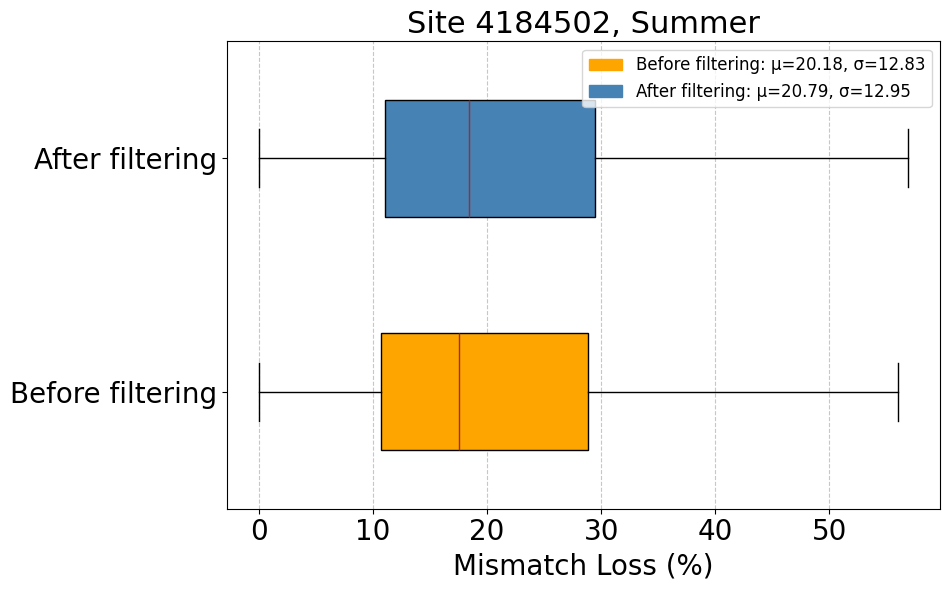

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4184502_winter_20250519_132403
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4184502_winter_20250519_132403\module_param_df.csv
df_pivot shape: (1247, 98)
2024-12-15 10:55:00 → 261526500_diode_activation=-1.0, Voc_261526500_outlier_label=1.0, Isc_261526500_outlier_label=-1.0
2024-12-15 12:05:00 → 261526611_diode_activation=-1.0, Voc_261526611_outlier_label=1.0, Isc_261526611_outlier_label=-1.0
2024-12-15 12:05:00 → 261526613_diode_activation=-1.0, Voc_261526613_outlier_label=1.0, Isc_261526613_outlier_label=-1.0
2024-12-16 12:20:00 → 261526613_diode_activation=-1.0, Voc_261526613_outlier_label=1.0, Isc_261526613_outlier_label=-1.0
2024-12-19 11:45:00 → 261526613_diode_activation=-1.0, Voc_261526613_outlier_label=1.0, Isc_261526613_outlier_label=-1.0
2024-12-19 11:50:00 → 261

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


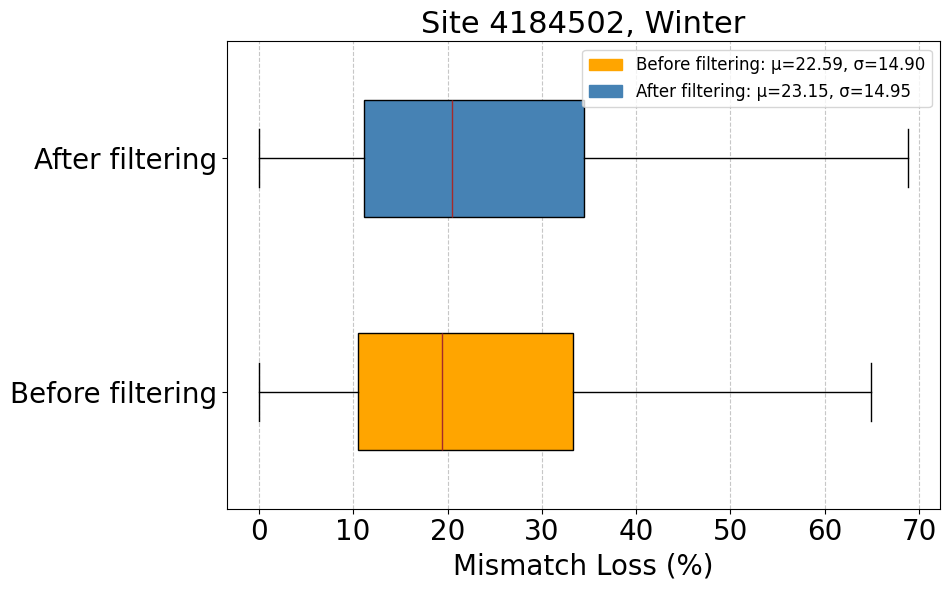

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4184502_autumn_20250518_160921
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4184502_autumn_20250518_160921\module_param_df.csv
df_pivot shape: (1465, 98)
2024-09-20 08:25:00 → 261526613_diode_activation=-1.0, Voc_261526613_outlier_label=1.0, Isc_261526613_outlier_label=-1.0
2024-09-20 08:30:00 → 261526613_diode_activation=-1.0, Voc_261526613_outlier_label=1.0, Isc_261526613_outlier_label=-1.0
2024-09-20 08:35:00 → 261526613_diode_activation=-1.0, Voc_261526613_outlier_label=1.0, Isc_261526613_outlier_label=-1.0
2024-09-20 08:40:00 → 261526613_diode_activation=-1.0, Voc_261526613_outlier_label=1.0, Isc_261526613_outlier_label=-1.0
2024-09-20 11:55:00 → 261526613_diode_activation=-1.0, Voc_261526613_outlier_label=1.0, Isc_261526613_outlier_label=-1.0
2024-09-20 12:00:00 → 261

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4118327_spring_20250517_202220
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4118327_spring_20250517_202220\module_param_df.csv
df_pivot shape: (1487, 224)
2024-03-16 10:15:00 → 257820472_diode_activation=-1.0, Voc_257820472_outlier_label=1.0, Isc_257820472_outlier_label=-1.0
2024-03-16 12:05:00 → 257820809_diode_activation=-1.0, Voc_257820809_outlier_label=1.0, Isc_257820809_outlier_label=-1.0
2024-03-18 10:20:00 → 257820556_diode_activation=-1.0, Voc_257820556_outlier_label=1.0, Isc_257820556_outlier_label=-1.0
2024-03-18 11:25:00 → 257825991_diode_activation=-1.0, Voc_257825991_outlier_label=1.0, Isc_257825991_outlier_label=-1.0
2024-03-18 11:30:00 → 257825991_diode_activation=-1.0, Voc_257825991_outlier_label=1.0, Isc_257825991_outlier_label=-1.0
2024-03-19 08:55:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


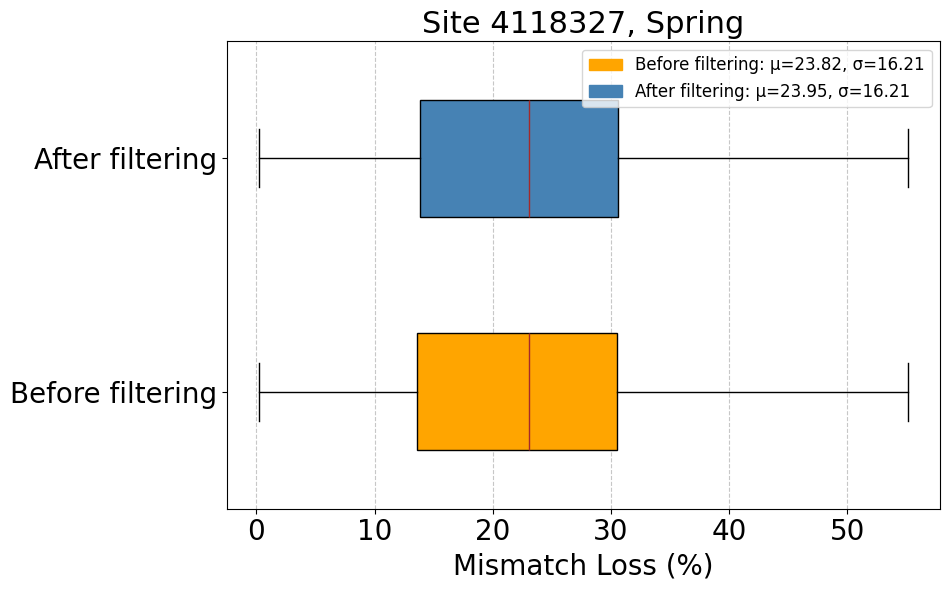

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4118327_summer_20250517_203847
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4118327_summer_20250517_203847\module_param_df.csv
df_pivot shape: (1743, 224)
2024-06-15 09:10:00 → 257826382_diode_activation=-1.0, Voc_257826382_outlier_label=1.0, Isc_257826382_outlier_label=-1.0
2024-06-15 09:15:00 → 257826382_diode_activation=-1.0, Voc_257826382_outlier_label=1.0, Isc_257826382_outlier_label=-1.0
2024-06-15 09:20:00 → 257826382_diode_activation=-1.0, Voc_257826382_outlier_label=1.0, Isc_257826382_outlier_label=-1.0
2024-06-15 09:25:00 → 257826382_diode_activation=-1.0, Voc_257826382_outlier_label=1.0, Isc_257826382_outlier_label=-1.0
2024-06-15 09:30:00 → 257826382_diode_activation=-1.0, Voc_257826382_outlier_label=1.0, Isc_257826382_outlier_label=-1.0
2024-06-15 09:35:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


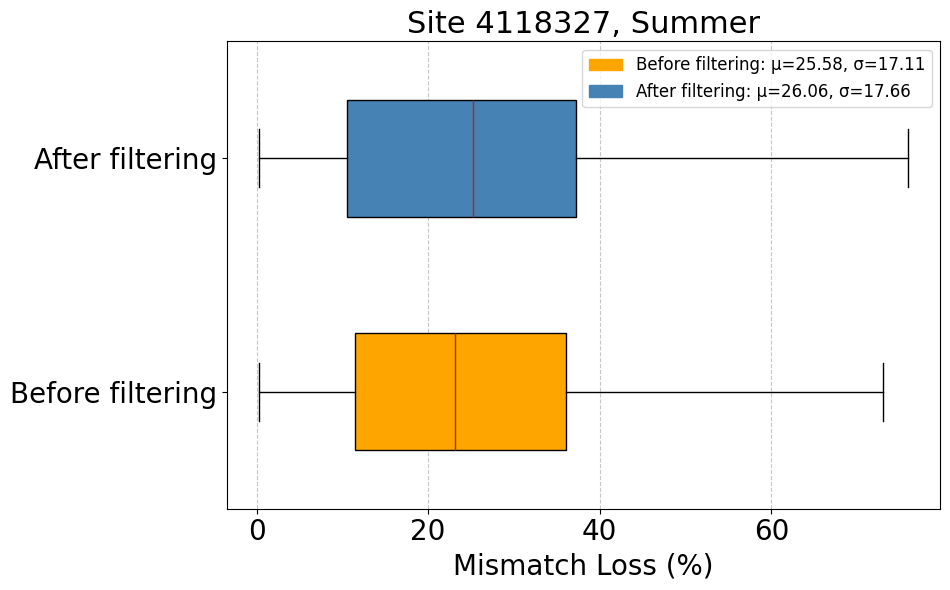

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4118327_winter_20250519_121008
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4118327_winter_20250519_121008\module_param_df.csv
df_pivot shape: (1263, 224)
Original combined data shape: (1263, 4)
New combined data shape (after removing diode activation timestamps): (1263, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4118327_autumn_20250517_215732
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4118327_autumn_20250517_215732\module_param_df.csv
df_pivot shape: (1488, 224)
Original combined data shape: (1488, 4)
New combined data shape (after removing diode activation timestamps): (1488, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


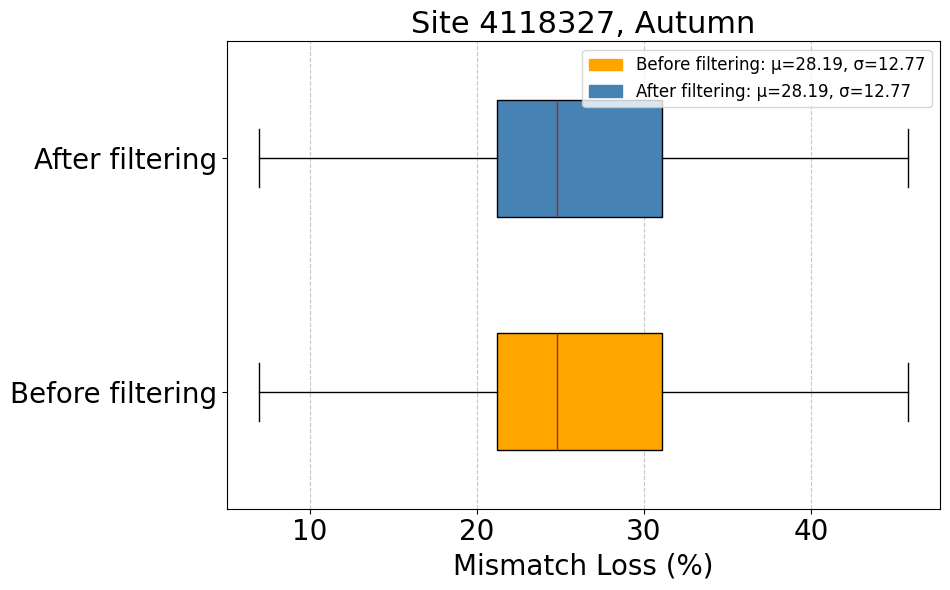

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4153809_spring_20250518_123858
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4153809_spring_20250518_123858\module_param_df.csv
df_pivot shape: (1465, 126)
2024-03-22 18:40:00 → 260258846_diode_activation=1.0, Voc_260258846_outlier_label=-1.0, Isc_260258846_outlier_label=0.0
2024-03-22 18:45:00 → 260258846_diode_activation=1.0, Voc_260258846_outlier_label=-1.0, Isc_260258846_outlier_label=0.0
2024-03-23 07:50:00 → 260258836_diode_activation=1.0, Voc_260258836_outlier_label=-1.0, Isc_260258836_outlier_label=0.0
Original combined data shape: (1465, 4)
New combined data shape (after removing diode activation timestamps): (1462, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


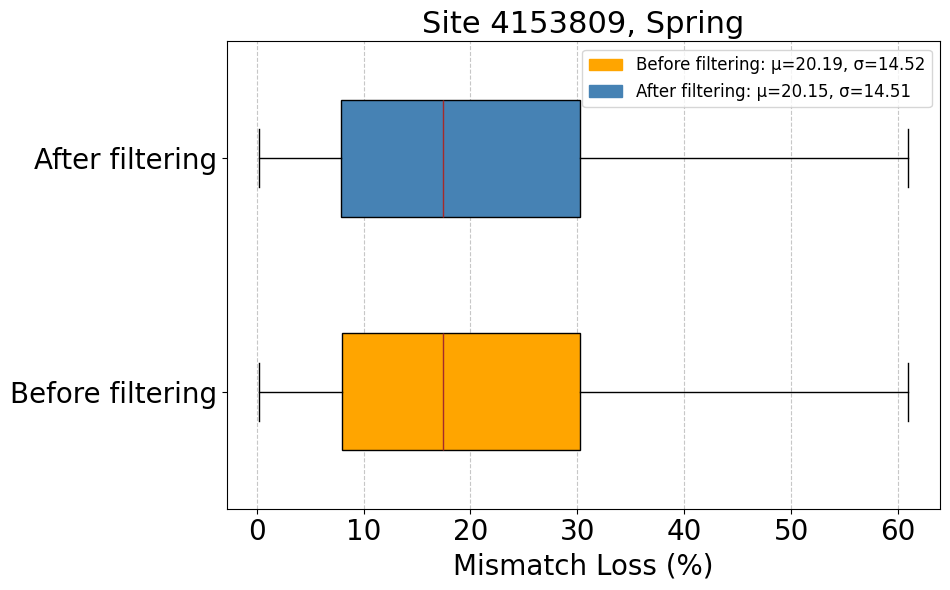

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4153809_summer_20250518_125215
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4153809_summer_20250518_125215\module_param_df.csv
df_pivot shape: (2041, 126)
2024-06-23 15:20:00 → 260258841_diode_activation=-1.0, Voc_260258841_outlier_label=1.0, Isc_260258841_outlier_label=-1.0
Original combined data shape: (2041, 4)
New combined data shape (after removing diode activation timestamps): (2040, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


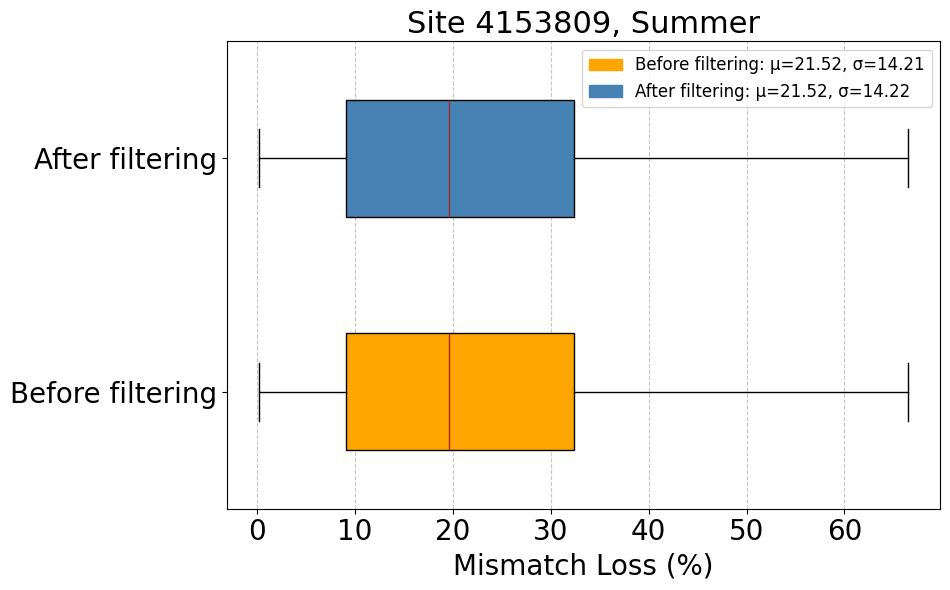

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4153809_winter_20250519_124901
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4153809_winter_20250519_124901\module_param_df.csv
df_pivot shape: (891, 126)
Original combined data shape: (891, 4)
New combined data shape (after removing diode activation timestamps): (891, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


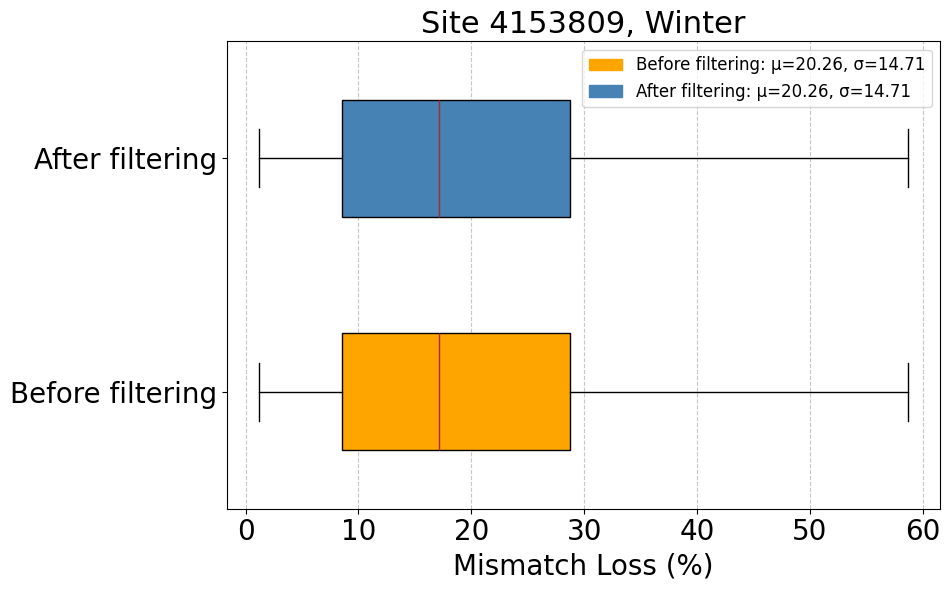

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4153809_autumn_20250518_131023
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4153809_autumn_20250518_131023\module_param_df.csv
df_pivot shape: (1460, 126)
2024-09-20 18:50:00 → 260258838_diode_activation=1.0, Voc_260258838_outlier_label=-1.0, Isc_260258838_outlier_label=0.0
2024-09-22 09:25:00 → 260258848_diode_activation=1.0, Voc_260258848_outlier_label=-1.0, Isc_260258848_outlier_label=0.0
2024-09-29 09:15:00 → 260258848_diode_activation=1.0, Voc_260258848_outlier_label=-1.0, Isc_260258848_outlier_label=0.0
2024-09-29 09:25:00 → 260258835_diode_activation=1.0, Voc_260258835_outlier_label=-1.0, Isc_260258835_outlier_label=0.0
Original combined data shape: (1460, 4)
New combined data shape (after removing diode activation timestamps): (1456, 4)
Columns in combined_df: ['Sum

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4093266_spring_20250516_170653
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4093266_spring_20250516_170653\module_param_df.csv
df_pivot shape: (1447, 126)
2024-03-15 14:50:00 → 255143502_diode_activation=-1.0, Voc_255143502_outlier_label=1.0, Isc_255143502_outlier_label=-1.0
2024-03-15 14:55:00 → 255143502_diode_activation=-1.0, Voc_255143502_outlier_label=1.0, Isc_255143502_outlier_label=-1.0
2024-03-15 15:05:00 → 255143502_diode_activation=-1.0, Voc_255143502_outlier_label=1.0, Isc_255143502_outlier_label=-1.0
2024-03-15 15:45:00 → 255144102_diode_activation=-1.0, Voc_255144102_outlier_label=1.0, Isc_255144102_outlier_label=-1.0
2024-03-15 15:55:00 → 255143484_diode_activation=-1.0, Voc_255143484_outlier_label=1.0, Isc_255143484_outlier_label=-1.0
2024-03-15 16:00:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4093266_summer_20250516_171849
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4093266_summer_20250516_171849\module_param_df.csv
df_pivot shape: (1816, 126)
2024-06-15 11:20:00 → 255143482_diode_activation=-1.0, Voc_255143482_outlier_label=1.0, Isc_255143482_outlier_label=-1.0
2024-06-15 11:20:00 → 255144112_diode_activation=-1.0, Voc_255144112_outlier_label=1.0, Isc_255144112_outlier_label=-1.0
2024-06-15 11:25:00 → 255143482_diode_activation=-1.0, Voc_255143482_outlier_label=1.0, Isc_255143482_outlier_label=-1.0
2024-06-15 11:25:00 → 255144112_diode_activation=-1.0, Voc_255144112_outlier_label=1.0, Isc_255144112_outlier_label=-1.0
2024-06-15 11:35:00 → 255143481_diode_activation=-1.0, Voc_255143481_outlier_label=1.0, Isc_255143481_outlier_label=-1.0
2024-06-15 11:35:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


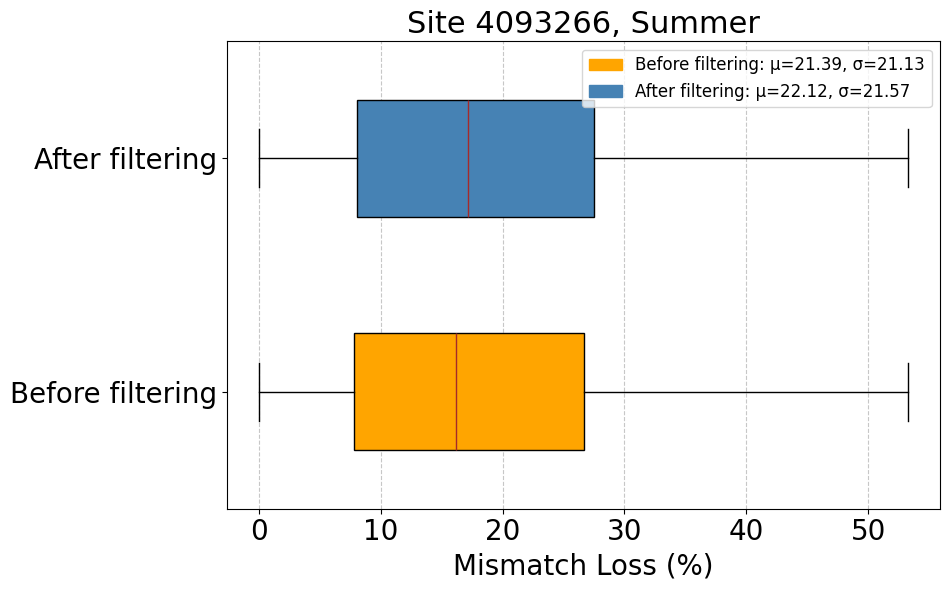

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4093266_winter_20250519_111416
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4093266_winter_20250519_111416\module_param_df.csv
df_pivot shape: (1021, 126)
2024-12-17 09:05:00 → 255143481_diode_activation=-1.0, Voc_255143481_outlier_label=1.0, Isc_255143481_outlier_label=-1.0
2024-12-17 09:05:00 → 255143482_diode_activation=-1.0, Voc_255143482_outlier_label=1.0, Isc_255143482_outlier_label=-1.0
2024-12-17 09:10:00 → 255143482_diode_activation=-1.0, Voc_255143482_outlier_label=1.0, Isc_255143482_outlier_label=-1.0
2024-12-17 09:15:00 → 255143482_diode_activation=-1.0, Voc_255143482_outlier_label=1.0, Isc_255143482_outlier_label=-1.0
2024-12-17 09:20:00 → 255143482_diode_activation=-1.0, Voc_255143482_outlier_label=1.0, Isc_255143482_outlier_label=-1.0
2024-12-17 09:25:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


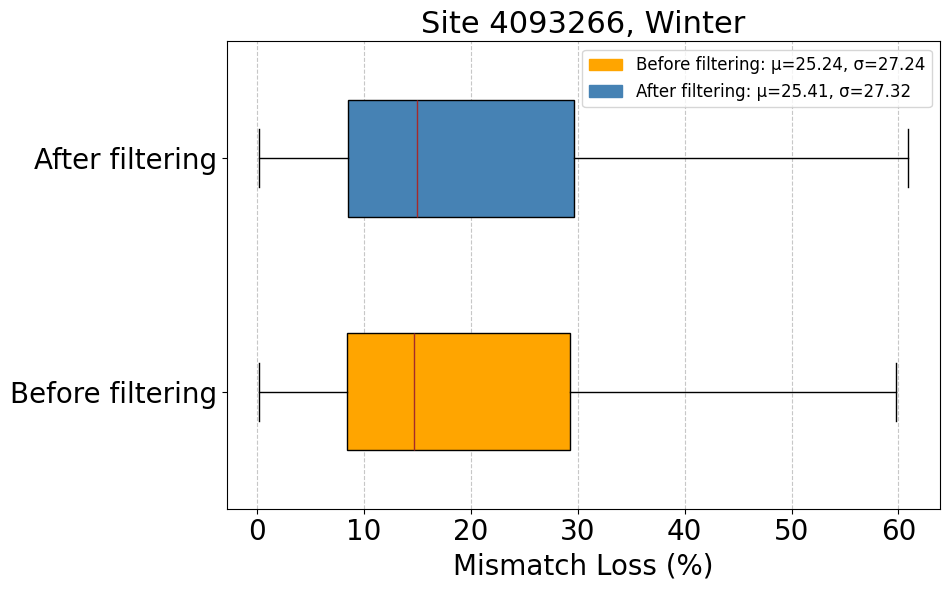

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4093266_autumn_20250516_173408
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4093266_autumn_20250516_173408\module_param_df.csv
df_pivot shape: (1410, 126)
2024-09-20 11:30:00 → 255143482_diode_activation=-1.0, Voc_255143482_outlier_label=1.0, Isc_255143482_outlier_label=-1.0
2024-09-20 14:35:00 → 255143502_diode_activation=-1.0, Voc_255143502_outlier_label=1.0, Isc_255143502_outlier_label=-1.0
2024-09-20 14:40:00 → 255143502_diode_activation=-1.0, Voc_255143502_outlier_label=1.0, Isc_255143502_outlier_label=-1.0
2024-09-20 14:45:00 → 255143502_diode_activation=-1.0, Voc_255143502_outlier_label=1.0, Isc_255143502_outlier_label=-1.0
2024-09-20 14:50:00 → 255143502_diode_activation=-1.0, Voc_255143502_outlier_label=1.0, Isc_255143502_outlier_label=-1.0
2024-09-20 14:55:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


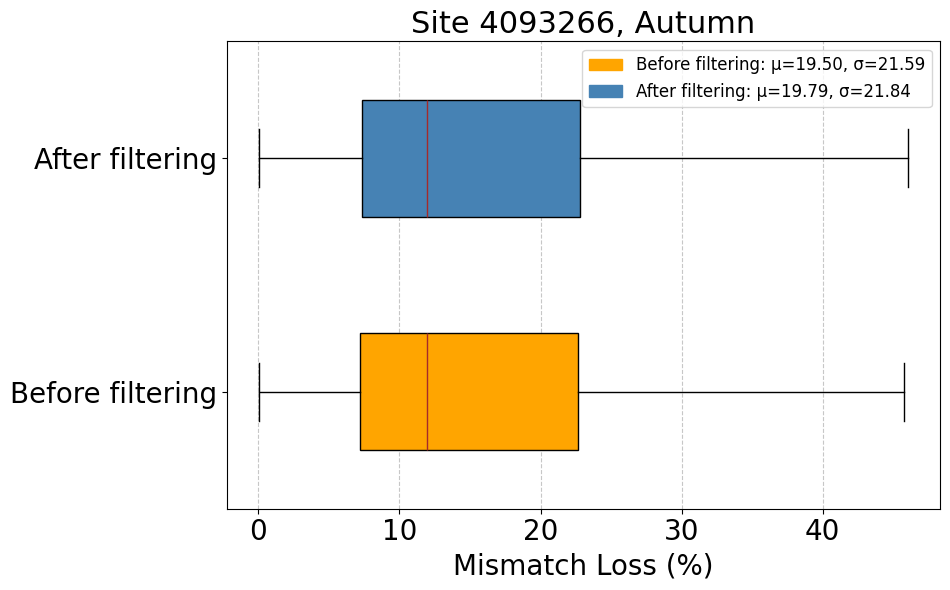

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4112053_spring_20250517_193807
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4112053_spring_20250517_193807\module_param_df.csv
df_pivot shape: (1462, 140)
2024-03-18 15:55:00 → 257486244_diode_activation=-1.0, Voc_257486244_outlier_label=1.0, Isc_257486244_outlier_label=-1.0
Original combined data shape: (1462, 4)
New combined data shape (after removing diode activation timestamps): (1461, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


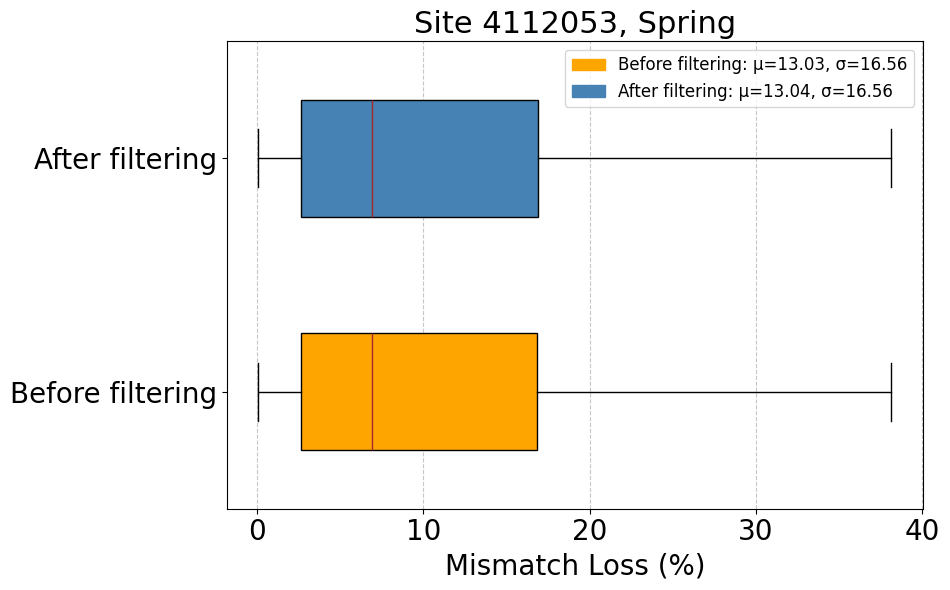

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4112053_summer_20250517_195057
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4112053_summer_20250517_195057\module_param_df.csv
df_pivot shape: (2047, 140)
Original combined data shape: (2047, 4)
New combined data shape (after removing diode activation timestamps): (2047, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


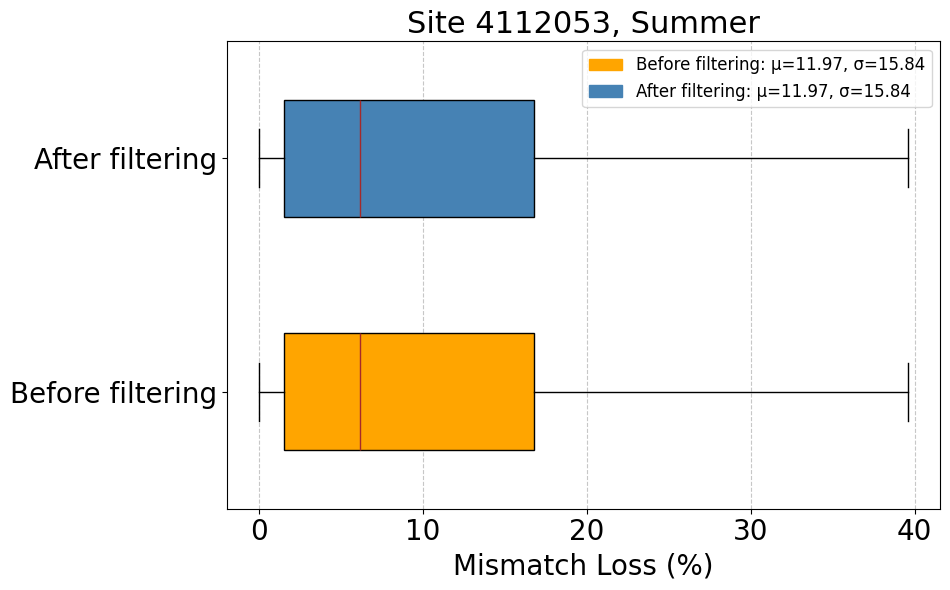

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4112053_winter_20250519_120204
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4112053_winter_20250519_120204\module_param_df.csv
df_pivot shape: (906, 140)
2024-12-23 11:40:00 → 257486250_diode_activation=-1.0, Voc_257486250_outlier_label=1.0, Isc_257486250_outlier_label=-1.0
2024-12-23 12:10:00 → 257486238_diode_activation=-1.0, Voc_257486238_outlier_label=1.0, Isc_257486238_outlier_label=-1.0
Original combined data shape: (906, 4)
New combined data shape (after removing diode activation timestamps): (904, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4112053_autumn_20250517_200902
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4112053_autumn_20250517_200902\module_param_df.csv
df_pivot shape: (1455, 140)
2024-09-20 09:55:00 → 257486236_diode_activation=-1.0, Voc_257486236_outlier_label=1.0, Isc_257486236_outlier_label=-1.0
2024-09-21 09:00:00 → 257486241_diode_activation=-1.0, Voc_257486241_outlier_label=1.0, Isc_257486241_outlier_label=-1.0
2024-09-21 09:05:00 → 257486241_diode_activation=-1.0, Voc_257486241_outlier_label=1.0, Isc_257486241_outlier_label=-1.0
2024-09-21 09:25:00 → 257486251_diode_activation=-1.0, Voc_257486251_outlier_label=1.0, Isc_257486251_outlier_label=-1.0
2024-09-21 09:30:00 → 257486236_diode_activation=-1.0, Voc_257486236_outlier_label=1.0, Isc_257486236_outlier_label=-1.0
2024-09-21 09:35:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


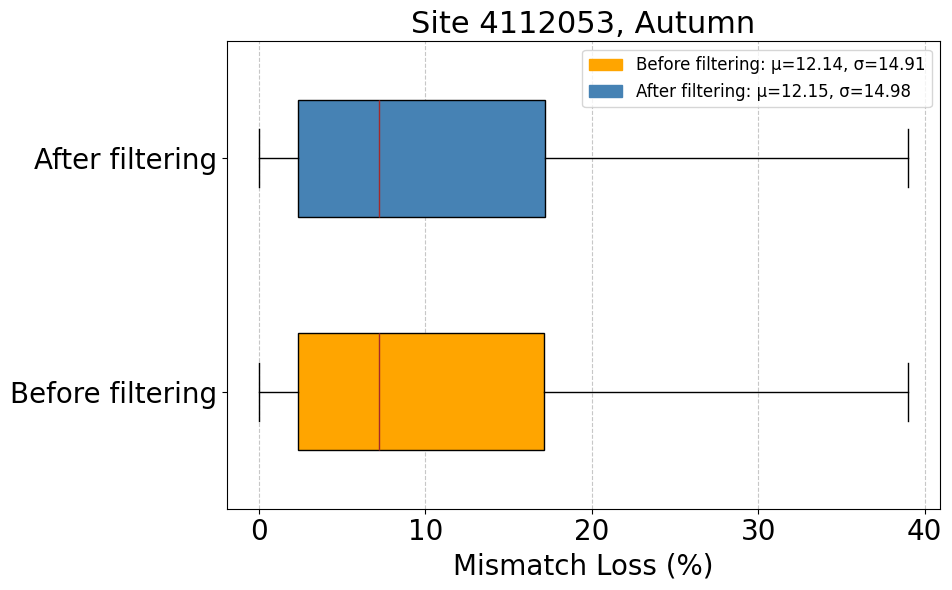

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4122216_spring_20250517_224503
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4122216_spring_20250517_224503\module_param_df.csv
df_pivot shape: (1453, 98)
2024-03-19 13:05:00 → 257948930_diode_activation=1.0, Voc_257948930_outlier_label=-1.0, Isc_257948930_outlier_label=0.0
2024-03-19 13:50:00 → 257948930_diode_activation=1.0, Voc_257948930_outlier_label=-1.0, Isc_257948930_outlier_label=0.0
2024-03-19 13:55:00 → 257948930_diode_activation=1.0, Voc_257948930_outlier_label=-1.0, Isc_257948930_outlier_label=0.0
2024-03-19 14:00:00 → 257948930_diode_activation=1.0, Voc_257948930_outlier_label=-1.0, Isc_257948930_outlier_label=0.0
2024-03-23 11:35:00 → 257948927_diode_activation=-1.0, Voc_257948927_outlier_label=1.0, Isc_257948927_outlier_label=-1.0
2024-03-23 13:00:00 → 2579489

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


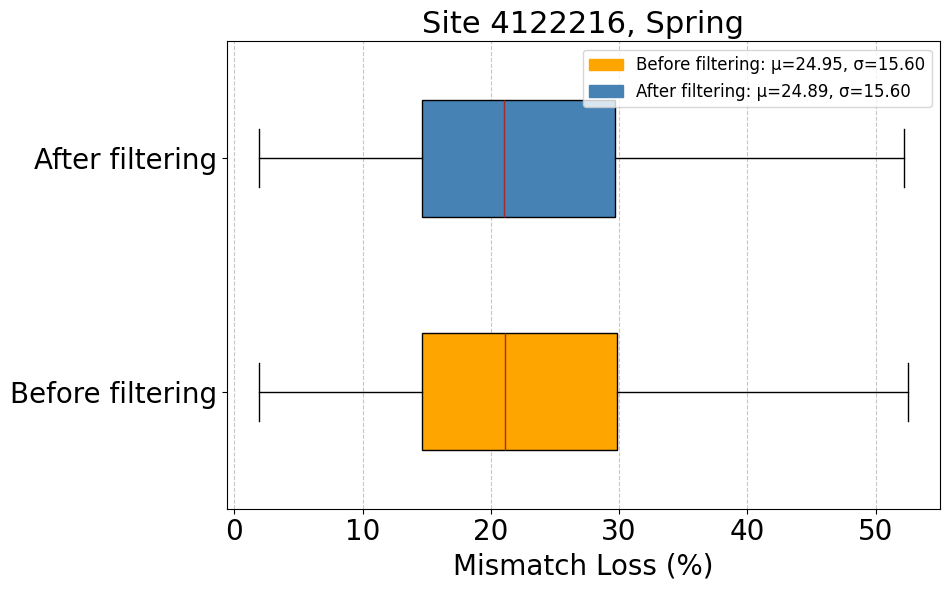

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4122216_summer_20250518_095442
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4122216_summer_20250518_095442\module_param_df.csv
df_pivot shape: (2031, 98)
2024-06-15 09:55:00 → 257948925_diode_activation=-1.0, Voc_257948925_outlier_label=1.0, Isc_257948925_outlier_label=-1.0
2024-06-15 10:30:00 → 257948932_diode_activation=-1.0, Voc_257948932_outlier_label=1.0, Isc_257948932_outlier_label=-1.0
2024-06-16 14:15:00 → 257948923_diode_activation=-1.0, Voc_257948923_outlier_label=1.0, Isc_257948923_outlier_label=-1.0
2024-06-16 14:15:00 → 257948927_diode_activation=-1.0, Voc_257948927_outlier_label=1.0, Isc_257948927_outlier_label=-1.0
2024-06-16 15:15:00 → 257948925_diode_activation=-1.0, Voc_257948925_outlier_label=1.0, Isc_257948925_outlier_label=-1.0
2024-06-16 15:15:00 → 257

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4122216_winter_20250519_122257
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4122216_winter_20250519_122257\module_param_df.csv
df_pivot shape: (893, 98)
Original combined data shape: (893, 4)
New combined data shape (after removing diode activation timestamps): (893, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


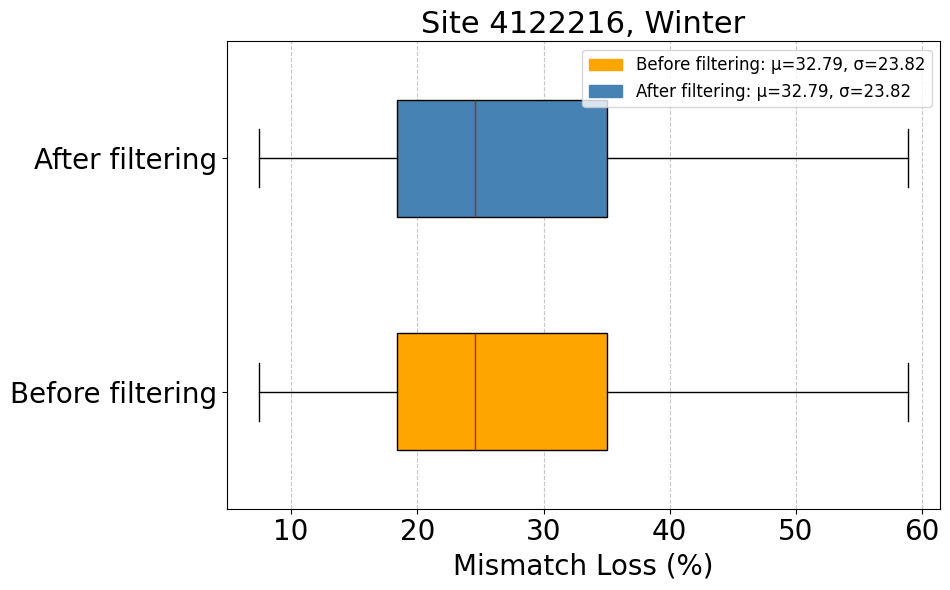

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4122216_autumn_20250518_103118
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4122216_autumn_20250518_103118\module_param_df.csv
df_pivot shape: (1438, 98)
2024-09-23 11:40:00 → 257948933_diode_activation=1.0, Voc_257948933_outlier_label=-1.0, Isc_257948933_outlier_label=0.0
2024-09-23 12:30:00 → 257948931_diode_activation=1.0, Voc_257948931_outlier_label=-1.0, Isc_257948931_outlier_label=0.0
2024-09-26 10:00:00 → 257948922_diode_activation=1.0, Voc_257948922_outlier_label=-1.0, Isc_257948922_outlier_label=0.0
2024-09-26 10:05:00 → 257948922_diode_activation=1.0, Voc_257948922_outlier_label=-1.0, Isc_257948922_outlier_label=0.0
2024-09-26 10:05:00 → 257948923_diode_activation=1.0, Voc_257948923_outlier_label=-1.0, Isc_257948923_outlier_label=0.0
2024-09-26 10:05:00 → 25794892

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


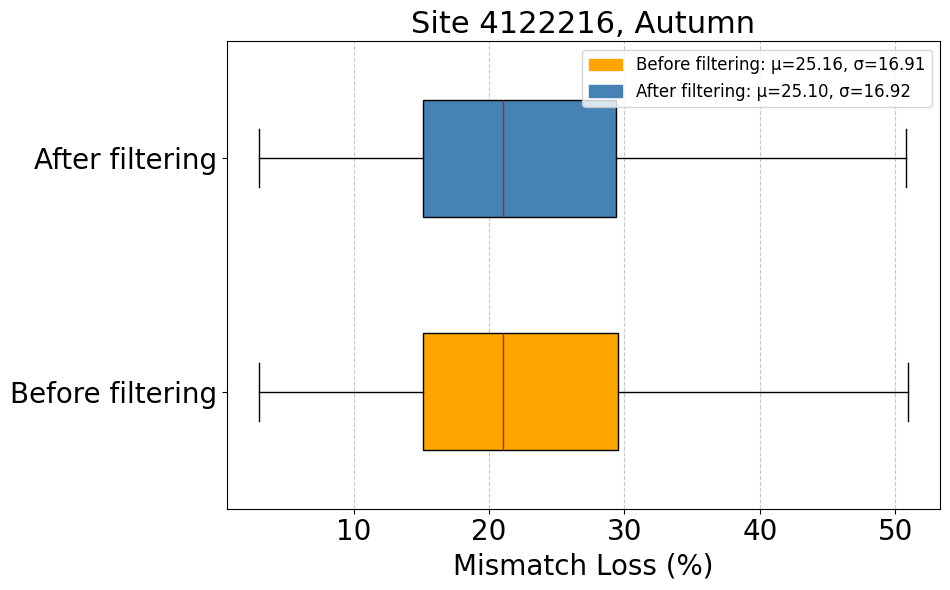

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4186157_spring_20250518_162116
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4186157_spring_20250518_162116\module_param_df.csv
df_pivot shape: (986, 217)
2024-03-19 09:15:00 → 260028882_diode_activation=-1.0, Voc_260028882_outlier_label=1.0, Isc_260028882_outlier_label=-1.0
2024-03-19 09:50:00 → 260028792_diode_activation=-1.0, Voc_260028792_outlier_label=1.0, Isc_260028792_outlier_label=-1.0
2024-03-19 09:50:00 → 260028884_diode_activation=-1.0, Voc_260028884_outlier_label=1.0, Isc_260028884_outlier_label=-1.0
2024-03-19 09:55:00 → 260028792_diode_activation=-1.0, Voc_260028792_outlier_label=1.0, Isc_260028792_outlier_label=-1.0
2024-03-19 09:55:00 → 260028884_diode_activation=-1.0, Voc_260028884_outlier_label=1.0, Isc_260028884_outlier_label=-1.0
2024-03-19 10:00:00 → 260

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


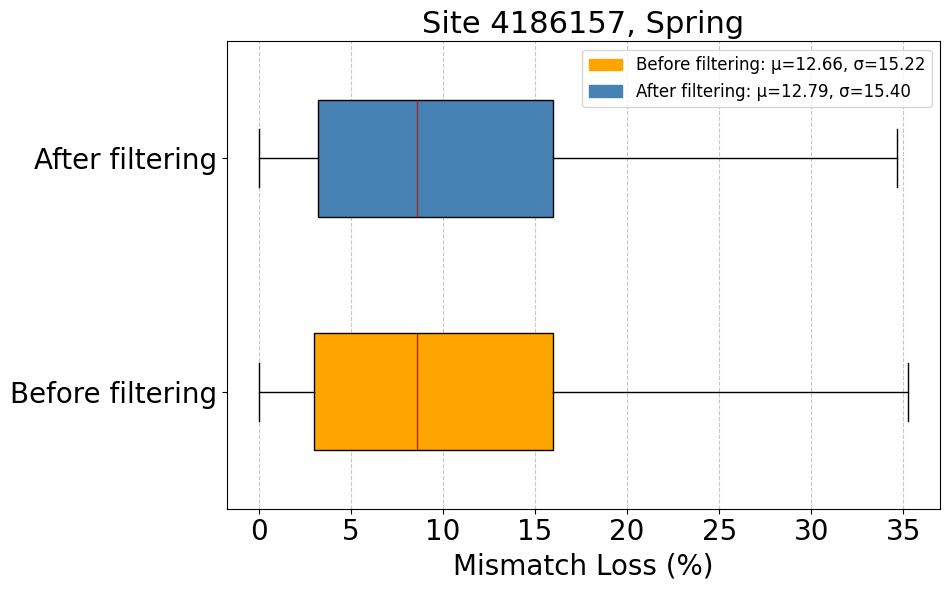

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4186157_summer_20250518_163158
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4186157_summer_20250518_163158\module_param_df.csv
df_pivot shape: (1692, 217)
2024-06-15 09:00:00 → 260028884_diode_activation=-1.0, Voc_260028884_outlier_label=1.0, Isc_260028884_outlier_label=-1.0
2024-06-15 09:05:00 → 260028884_diode_activation=-1.0, Voc_260028884_outlier_label=1.0, Isc_260028884_outlier_label=-1.0
2024-06-15 17:50:00 → 260028901_diode_activation=-1.0, Voc_260028901_outlier_label=1.0, Isc_260028901_outlier_label=-1.0
2024-06-15 18:05:00 → 260028792_diode_activation=-1.0, Voc_260028792_outlier_label=1.0, Isc_260028792_outlier_label=-1.0
2024-06-15 18:05:00 → 260028901_diode_activation=-1.0, Voc_260028901_outlier_label=1.0, Isc_260028901_outlier_label=-1.0
2024-06-15 18:10:00 → 26

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


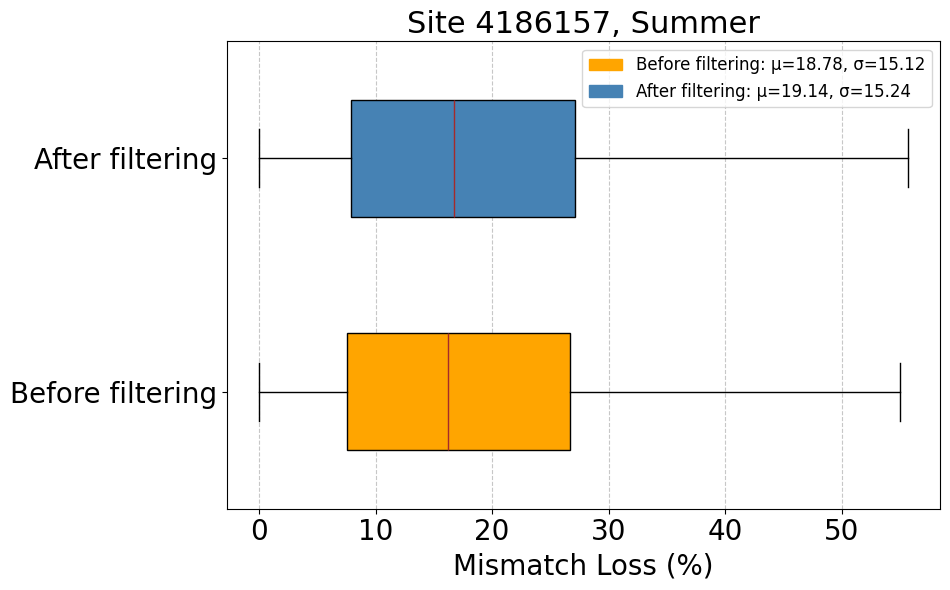

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4186157_winter_20250519_133433
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4186157_winter_20250519_133433\module_param_df.csv
df_pivot shape: (1259, 217)
2024-12-16 16:50:00 → 260028829_diode_activation=-1.0, Voc_260028829_outlier_label=1.0, Isc_260028829_outlier_label=-1.0
2024-12-16 16:55:00 → 260028829_diode_activation=-1.0, Voc_260028829_outlier_label=1.0, Isc_260028829_outlier_label=-1.0
2024-12-16 16:55:00 → 260028885_diode_activation=-1.0, Voc_260028885_outlier_label=1.0, Isc_260028885_outlier_label=-1.0
2024-12-16 16:55:00 → 260028888_diode_activation=-1.0, Voc_260028888_outlier_label=1.0, Isc_260028888_outlier_label=-1.0
2024-12-16 16:55:00 → 260028901_diode_activation=-1.0, Voc_260028901_outlier_label=1.0, Isc_260028901_outlier_label=-1.0
2024-12-16 17:00:00 → 26

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


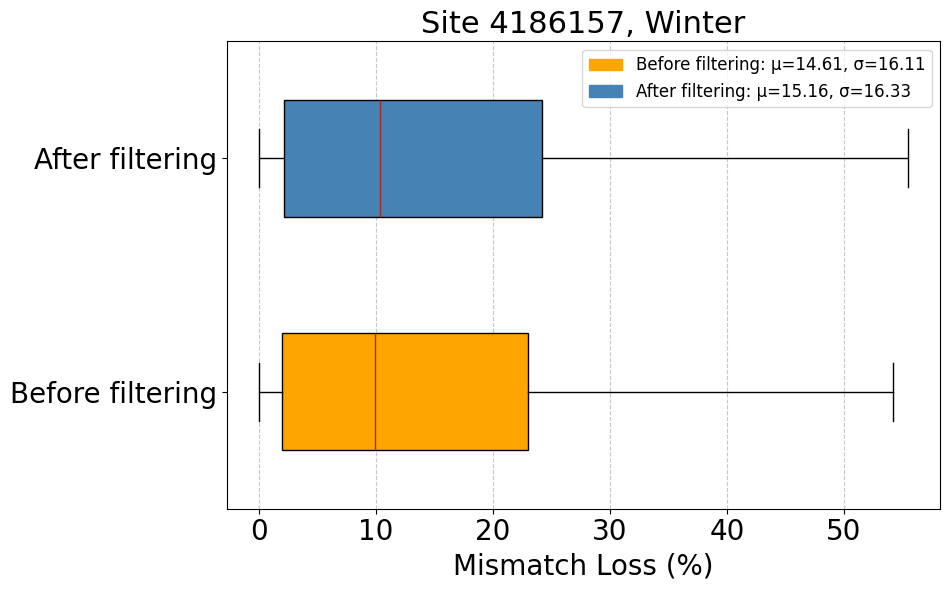

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4186157_autumn_20250518_165402
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4186157_autumn_20250518_165402\module_param_df.csv
df_pivot shape: (1482, 217)
2024-09-20 08:50:00 → 260028826_diode_activation=-1.0, Voc_260028826_outlier_label=1.0, Isc_260028826_outlier_label=-1.0
2024-09-20 08:50:00 → 260028882_diode_activation=-1.0, Voc_260028882_outlier_label=1.0, Isc_260028882_outlier_label=-1.0
2024-09-20 08:50:00 → 260028901_diode_activation=-1.0, Voc_260028901_outlier_label=1.0, Isc_260028901_outlier_label=-1.0
2024-09-20 08:55:00 → 260028826_diode_activation=-1.0, Voc_260028826_outlier_label=1.0, Isc_260028826_outlier_label=-1.0
2024-09-20 08:55:00 → 260028882_diode_activation=-1.0, Voc_260028882_outlier_label=1.0, Isc_260028882_outlier_label=-1.0
2024-09-20 09:00:00 → 26

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


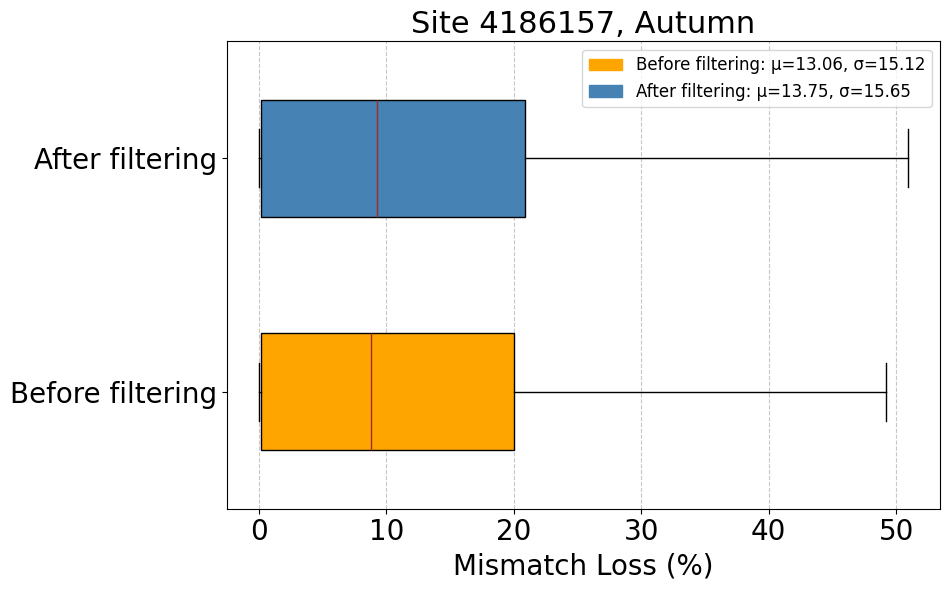

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4162787_spring_20250518_132320
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4162787_spring_20250518_132320\module_param_df.csv
df_pivot shape: (1457, 56)
Original combined data shape: (1457, 4)
New combined data shape (after removing diode activation timestamps): (1457, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


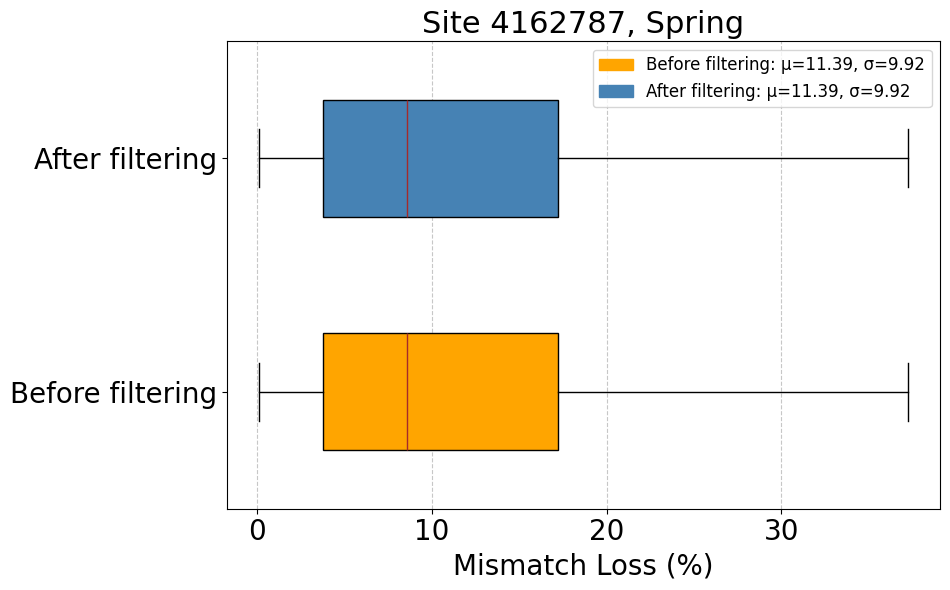

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4162787_summer_20250518_133409
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4162787_summer_20250518_133409\module_param_df.csv
df_pivot shape: (2051, 56)
2024-06-17 20:45:00 → 260340229_diode_activation=1.0, Voc_260340229_outlier_label=-1.0, Isc_260340229_outlier_label=0.0
2024-06-20 10:30:00 → 260340226_diode_activation=-1.0, Voc_260340226_outlier_label=1.0, Isc_260340226_outlier_label=-1.0
2024-06-23 07:25:00 → 260340230_diode_activation=1.0, Voc_260340230_outlier_label=-1.0, Isc_260340230_outlier_label=0.0
2024-06-24 07:25:00 → 260340230_diode_activation=1.0, Voc_260340230_outlier_label=-1.0, Isc_260340230_outlier_label=0.0
Original combined data shape: (2051, 4)
New combined data shape (after removing diode activation timestamps): (2047, 4)
Columns in combined_df: ['Sum

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


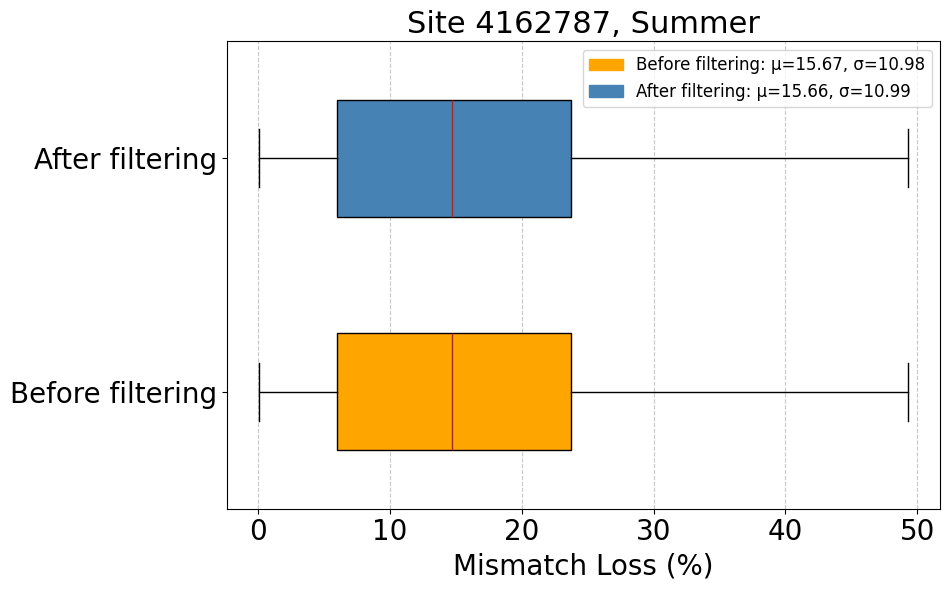

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4162787_winter_20250519_125620
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4162787_winter_20250519_125620\module_param_df.csv
df_pivot shape: (914, 56)
Original combined data shape: (914, 4)
New combined data shape (after removing diode activation timestamps): (914, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


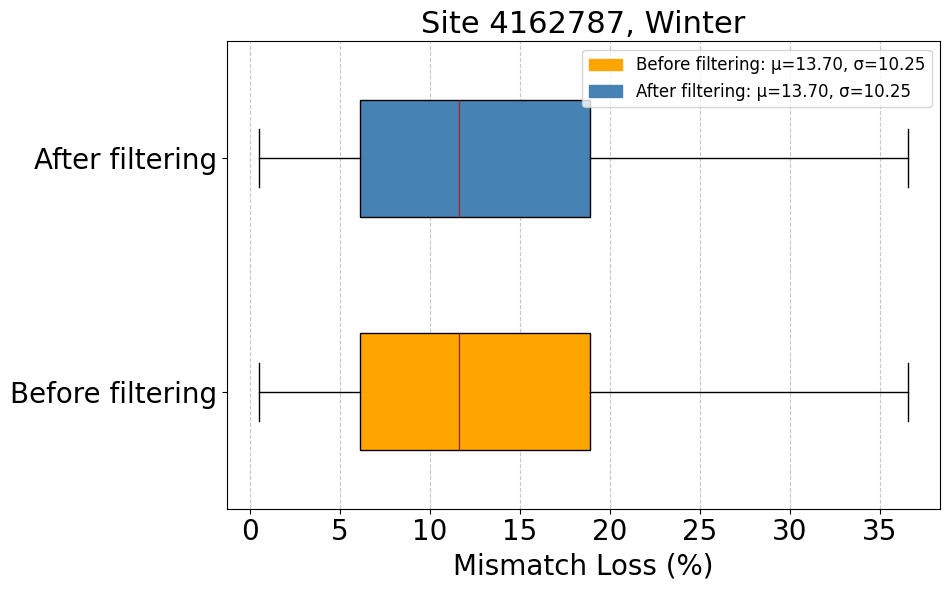

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4162787_autumn_20250518_134929
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4162787_autumn_20250518_134929\module_param_df.csv
df_pivot shape: (1454, 56)
2024-09-20 16:30:00 → 260340234_diode_activation=-1.0, Voc_260340234_outlier_label=1.0, Isc_260340234_outlier_label=-1.0
2024-09-22 12:35:00 → 260340226_diode_activation=1.0, Voc_260340226_outlier_label=-1.0, Isc_260340226_outlier_label=0.0
2024-09-24 19:00:00 → 260340233_diode_activation=1.0, Voc_260340233_outlier_label=-1.0, Isc_260340233_outlier_label=0.0
2024-09-24 19:05:00 → 260340233_diode_activation=1.0, Voc_260340233_outlier_label=-1.0, Isc_260340233_outlier_label=0.0
Original combined data shape: (1455, 4)
New combined data shape (after removing diode activation timestamps): (1451, 4)
Columns in combined_df: ['Sum

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


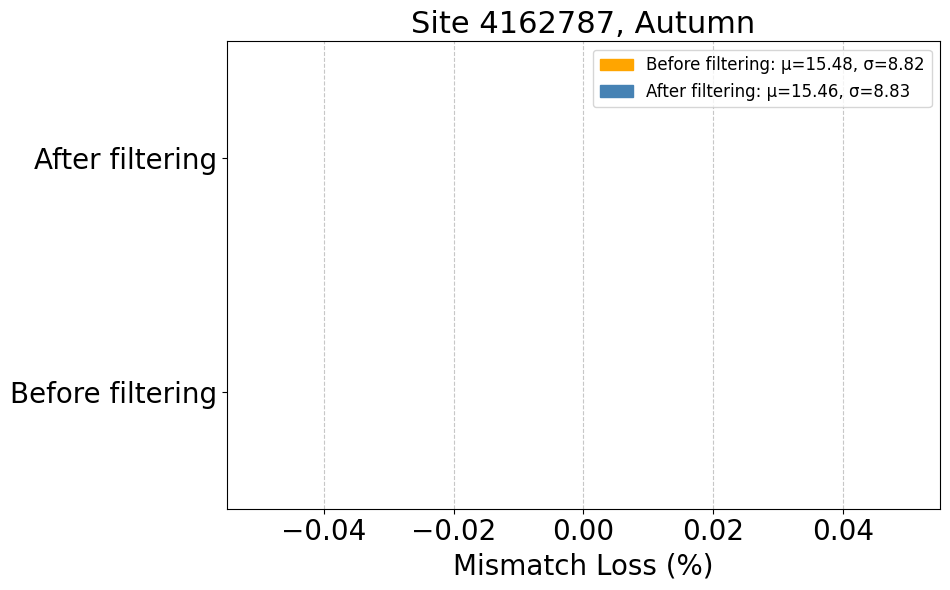

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4140175_spring_20250518_120816
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4140175_spring_20250518_120816\module_param_df.csv
df_pivot shape: (527, 105)
2024-09-20 10:10:00 → 258942418_diode_activation=-1.0, Voc_258942418_outlier_label=1.0, Isc_258942418_outlier_label=-1.0
2024-09-20 10:15:00 → 258942418_diode_activation=-1.0, Voc_258942418_outlier_label=1.0, Isc_258942418_outlier_label=-1.0
2024-09-20 10:20:00 → 258942418_diode_activation=-1.0, Voc_258942418_outlier_label=1.0, Isc_258942418_outlier_label=-1.0
2024-09-20 10:25:00 → 258942418_diode_activation=-1.0, Voc_258942418_outlier_label=1.0, Isc_258942418_outlier_label=-1.0
2024-09-20 10:35:00 → 258942418_diode_activation=-1.0, Voc_258942418_outlier_label=1.0, Isc_258942418_outlier_label=-1.0
2024-09-20 10:40:00 → 258

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


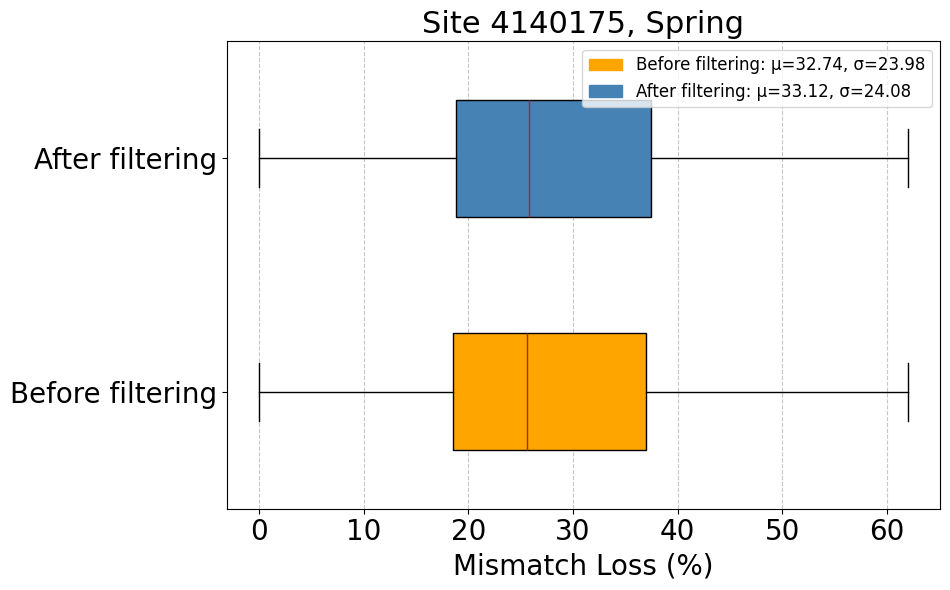

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4140175_summer_20250518_121300
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4140175_summer_20250518_121300\module_param_df.csv
df_pivot shape: (1717, 105)
2024-12-15 11:50:00 → 258942420_diode_activation=-1.0, Voc_258942420_outlier_label=1.0, Isc_258942420_outlier_label=-1.0
2024-12-15 11:55:00 → 258942418_diode_activation=-1.0, Voc_258942418_outlier_label=1.0, Isc_258942418_outlier_label=-1.0
2024-12-15 11:55:00 → 258942420_diode_activation=-1.0, Voc_258942420_outlier_label=1.0, Isc_258942420_outlier_label=-1.0
2024-12-15 12:00:00 → 258942418_diode_activation=-1.0, Voc_258942418_outlier_label=1.0, Isc_258942418_outlier_label=-1.0
2024-12-15 12:00:00 → 258942420_diode_activation=-1.0, Voc_258942420_outlier_label=1.0, Isc_258942420_outlier_label=-1.0
2024-12-15 12:05:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


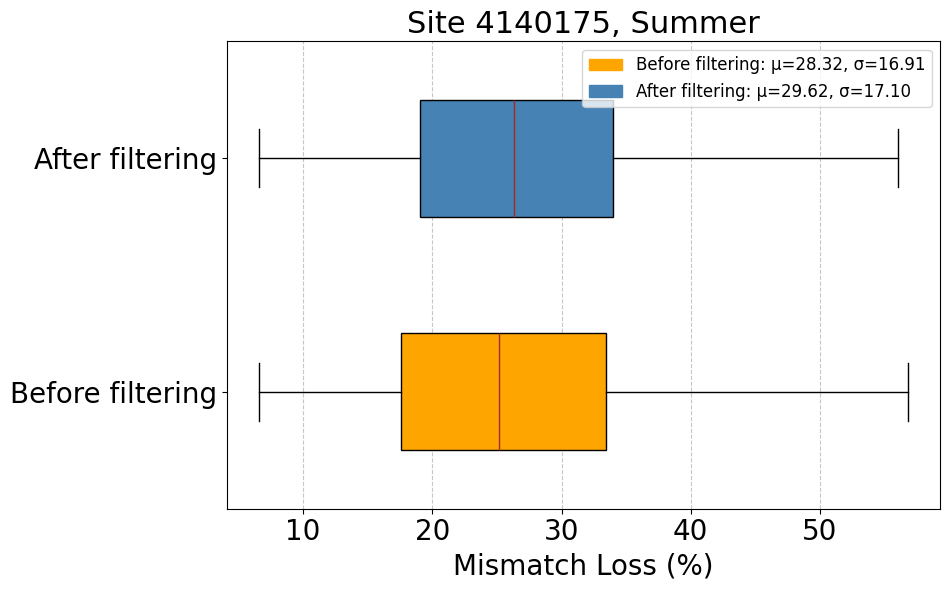

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4140175_winter_20250519_123938
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4140175_winter_20250519_123938\module_param_df.csv
df_pivot shape: (1196, 105)
2024-06-16 09:10:00 → 258942416_diode_activation=-1.0, Voc_258942416_outlier_label=1.0, Isc_258942416_outlier_label=-1.0
2024-06-16 09:20:00 → 258942416_diode_activation=-1.0, Voc_258942416_outlier_label=1.0, Isc_258942416_outlier_label=-1.0
2024-06-16 09:25:00 → 258942416_diode_activation=-1.0, Voc_258942416_outlier_label=1.0, Isc_258942416_outlier_label=-1.0
2024-06-16 09:30:00 → 258942416_diode_activation=-1.0, Voc_258942416_outlier_label=1.0, Isc_258942416_outlier_label=-1.0
2024-06-16 09:35:00 → 258942416_diode_activation=-1.0, Voc_258942416_outlier_label=1.0, Isc_258942416_outlier_label=-1.0
2024-06-16 09:40:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


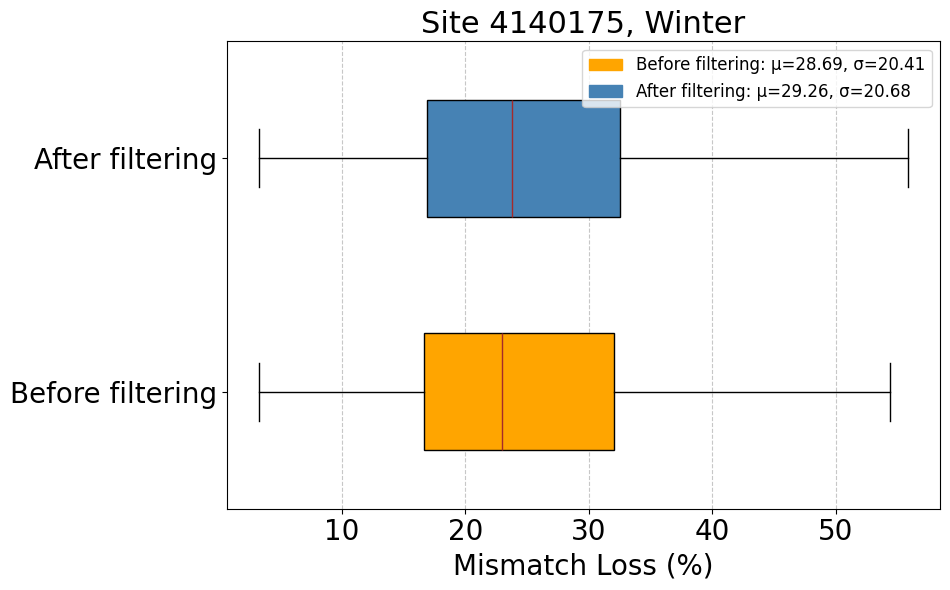

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4140175_autumn_20250518_122657
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4140175_autumn_20250518_122657\module_param_df.csv
df_pivot shape: (1443, 105)
2024-03-19 12:20:00 → 258942416_diode_activation=-1.0, Voc_258942416_outlier_label=1.0, Isc_258942416_outlier_label=-1.0
2024-03-19 12:25:00 → 258942416_diode_activation=-1.0, Voc_258942416_outlier_label=1.0, Isc_258942416_outlier_label=-1.0
2024-03-19 12:30:00 → 258942416_diode_activation=-1.0, Voc_258942416_outlier_label=1.0, Isc_258942416_outlier_label=-1.0
2024-03-19 12:35:00 → 258942416_diode_activation=-1.0, Voc_258942416_outlier_label=1.0, Isc_258942416_outlier_label=-1.0
2024-03-19 12:40:00 → 258942416_diode_activation=-1.0, Voc_258942416_outlier_label=1.0, Isc_258942416_outlier_label=-1.0
2024-03-19 12:45:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


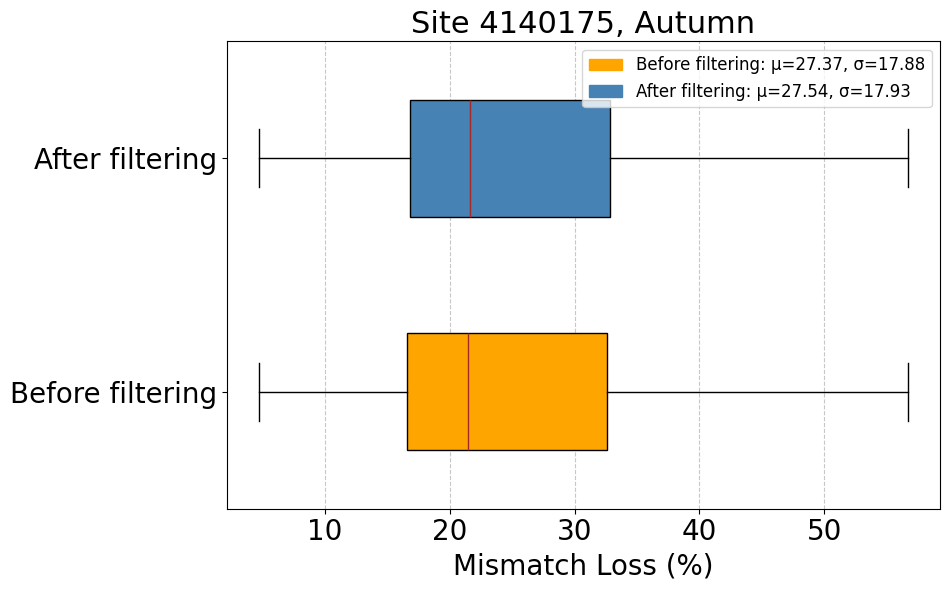

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4073264_spring_20250516_163419
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4073264_spring_20250516_163419\module_param_df.csv
df_pivot shape: (1469, 56)
Original combined data shape: (1469, 4)
New combined data shape (after removing diode activation timestamps): (1469, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


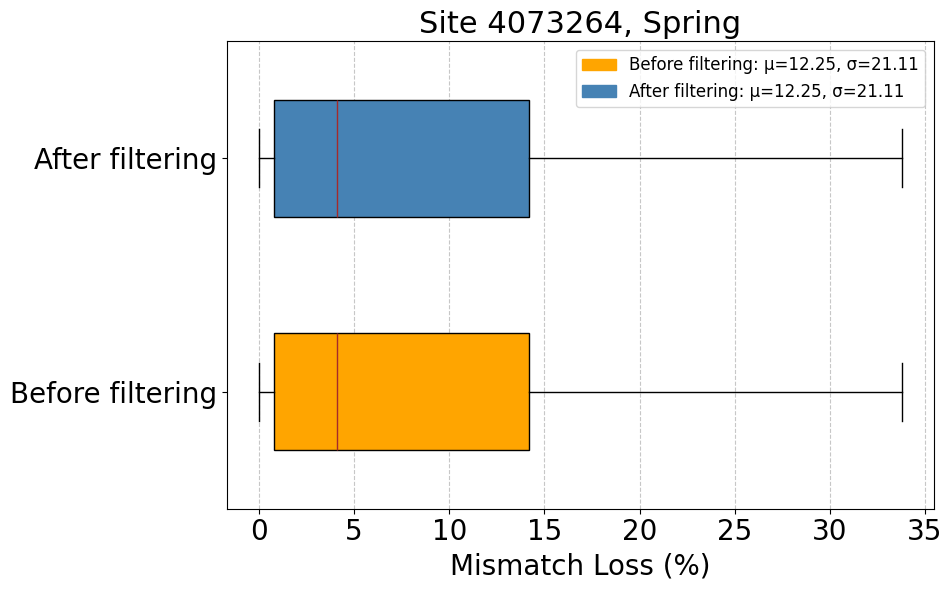

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4073264_summer_20250516_164409
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4073264_summer_20250516_164409\module_param_df.csv
df_pivot shape: (1898, 56)
2024-06-15 07:50:00 → 260179429_diode_activation=-1.0, Voc_260179429_outlier_label=1.0, Isc_260179429_outlier_label=-1.0
2024-06-15 08:00:00 → 260179429_diode_activation=-1.0, Voc_260179429_outlier_label=1.0, Isc_260179429_outlier_label=-1.0
2024-06-15 08:05:00 → 260179429_diode_activation=-1.0, Voc_260179429_outlier_label=1.0, Isc_260179429_outlier_label=-1.0
2024-06-15 08:10:00 → 260179429_diode_activation=-1.0, Voc_260179429_outlier_label=1.0, Isc_260179429_outlier_label=-1.0
2024-06-15 08:15:00 → 260179429_diode_activation=-1.0, Voc_260179429_outlier_label=1.0, Isc_260179429_outlier_label=-1.0
2024-06-15 08:20:00 → 260

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


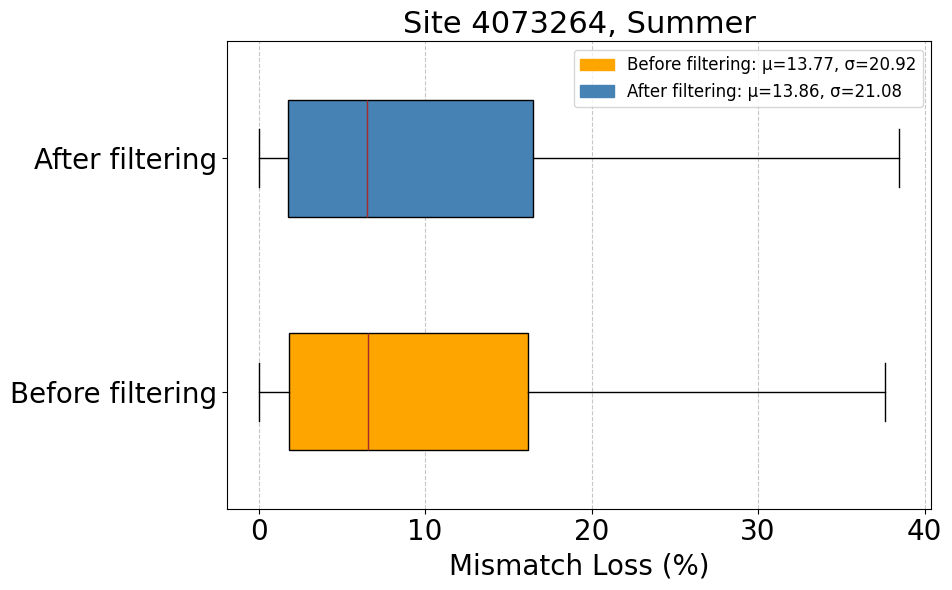

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4073264_winter_20250519_110654
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4073264_winter_20250519_110654\module_param_df.csv
df_pivot shape: (1030, 56)
2024-12-24 09:55:00 → 260179401_diode_activation=-1.0, Voc_260179401_outlier_label=1.0, Isc_260179401_outlier_label=-1.0
2024-12-24 13:10:00 → 260179401_diode_activation=-1.0, Voc_260179401_outlier_label=1.0, Isc_260179401_outlier_label=-1.0
2024-12-24 13:15:00 → 260179401_diode_activation=-1.0, Voc_260179401_outlier_label=1.0, Isc_260179401_outlier_label=-1.0
2024-12-24 13:20:00 → 260179401_diode_activation=-1.0, Voc_260179401_outlier_label=1.0, Isc_260179401_outlier_label=-1.0
Original combined data shape: (1030, 4)
New combined data shape (after removing diode activation timestamps): (1026, 4)
Columns in combined_df: ['

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


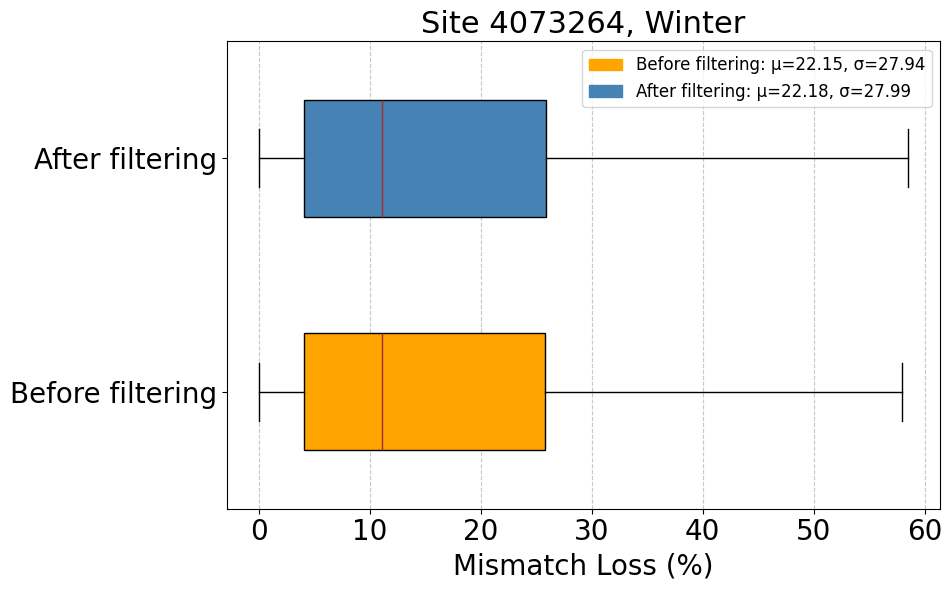

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4073264_autumn_20250516_165709
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4073264_autumn_20250516_165709\module_param_df.csv
df_pivot shape: (1431, 56)
2024-09-28 16:30:00 → 260179401_diode_activation=-1.0, Voc_260179401_outlier_label=1.0, Isc_260179401_outlier_label=-1.0
Original combined data shape: (1431, 4)
New combined data shape (after removing diode activation timestamps): (1430, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


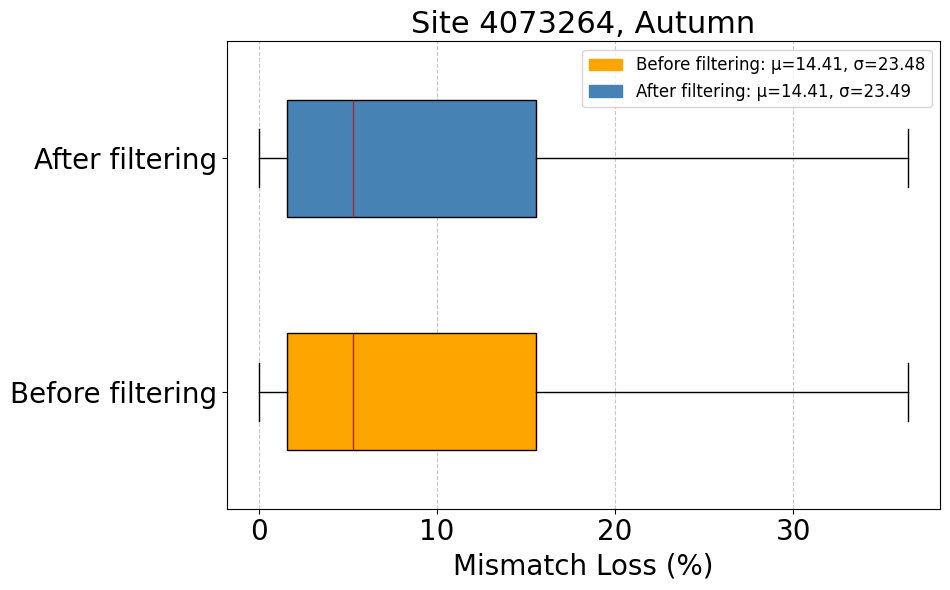

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4172746_spring_20250518_140030
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4172746_spring_20250518_140030\module_param_df.csv
df_pivot shape: (1480, 126)
2024-03-16 08:45:00 → 260988490_diode_activation=-1.0, Voc_260988490_outlier_label=1.0, Isc_260988490_outlier_label=-1.0
2024-03-16 08:55:00 → 260988878_diode_activation=-1.0, Voc_260988878_outlier_label=1.0, Isc_260988878_outlier_label=-1.0
2024-03-16 10:20:00 → 260988679_diode_activation=-1.0, Voc_260988679_outlier_label=1.0, Isc_260988679_outlier_label=-1.0
2024-03-16 10:35:00 → 260988679_diode_activation=-1.0, Voc_260988679_outlier_label=1.0, Isc_260988679_outlier_label=-1.0
2024-03-16 11:00:00 → 260988490_diode_activation=-1.0, Voc_260988490_outlier_label=1.0, Isc_260988490_outlier_label=-1.0
2024-03-16 11:45:00 → 26

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4172746_summer_20250518_141525
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4172746_summer_20250518_141525\module_param_df.csv
df_pivot shape: (1743, 126)
2024-06-15 15:00:00 → 260988679_diode_activation=-1.0, Voc_260988679_outlier_label=1.0, Isc_260988679_outlier_label=-1.0
2024-06-15 15:00:00 → 260988878_diode_activation=-1.0, Voc_260988878_outlier_label=1.0, Isc_260988878_outlier_label=-1.0
2024-06-15 15:05:00 → 260988878_diode_activation=-1.0, Voc_260988878_outlier_label=1.0, Isc_260988878_outlier_label=-1.0
2024-06-15 15:10:00 → 260988878_diode_activation=-1.0, Voc_260988878_outlier_label=1.0, Isc_260988878_outlier_label=-1.0
2024-06-15 15:15:00 → 260988878_diode_activation=-1.0, Voc_260988878_outlier_label=1.0, Isc_260988878_outlier_label=-1.0
2024-06-15 15:20:00 → 26

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4172746_winter_20250519_130234
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4172746_winter_20250519_130234\module_param_df.csv
df_pivot shape: (1234, 126)
2024-12-15 09:05:00 → 260988680_diode_activation=-1.0, Voc_260988680_outlier_label=1.0, Isc_260988680_outlier_label=-1.0
2024-12-15 09:05:00 → 260989411_diode_activation=-1.0, Voc_260989411_outlier_label=1.0, Isc_260989411_outlier_label=-1.0
2024-12-15 09:10:00 → 260988680_diode_activation=-1.0, Voc_260988680_outlier_label=1.0, Isc_260988680_outlier_label=-1.0
2024-12-15 09:10:00 → 260989411_diode_activation=-1.0, Voc_260989411_outlier_label=1.0, Isc_260989411_outlier_label=-1.0
2024-12-15 09:15:00 → 260988680_diode_activation=-1.0, Voc_260988680_outlier_label=1.0, Isc_260988680_outlier_label=-1.0
2024-12-15 09:20:00 → 26

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


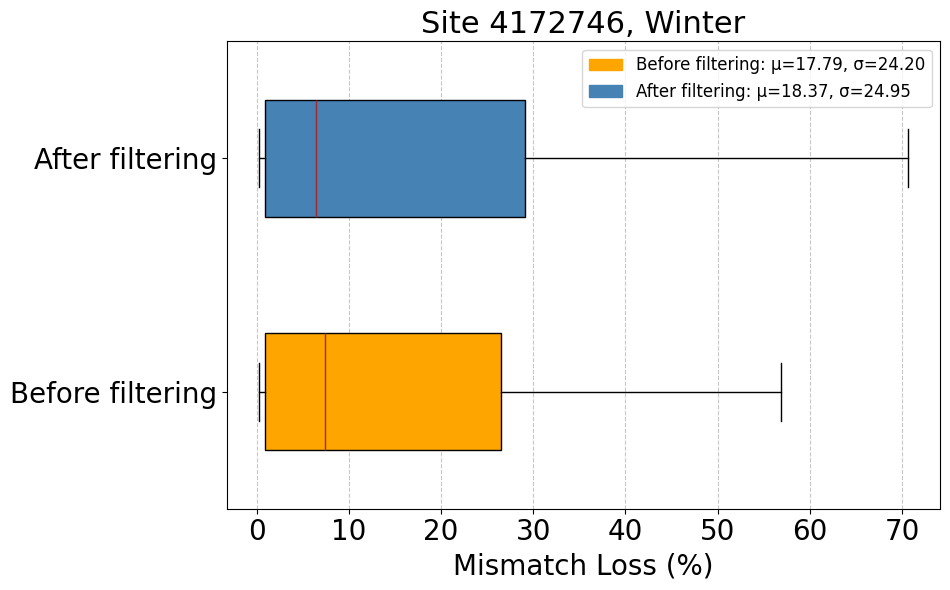

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4172746_autumn_20250518_143237
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4172746_autumn_20250518_143237\module_param_df.csv
df_pivot shape: (1483, 126)
2024-09-20 14:30:00 → 260988490_diode_activation=-1.0, Voc_260988490_outlier_label=1.0, Isc_260988490_outlier_label=-1.0
2024-09-20 14:40:00 → 260988686_diode_activation=-1.0, Voc_260988686_outlier_label=1.0, Isc_260988686_outlier_label=-1.0
2024-09-20 14:45:00 → 260988686_diode_activation=-1.0, Voc_260988686_outlier_label=1.0, Isc_260988686_outlier_label=-1.0
2024-09-20 14:50:00 → 260988686_diode_activation=-1.0, Voc_260988686_outlier_label=1.0, Isc_260988686_outlier_label=-1.0
2024-09-20 14:55:00 → 260988686_diode_activation=-1.0, Voc_260988686_outlier_label=1.0, Isc_260988686_outlier_label=-1.0
2024-09-20 15:00:00 → 26

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


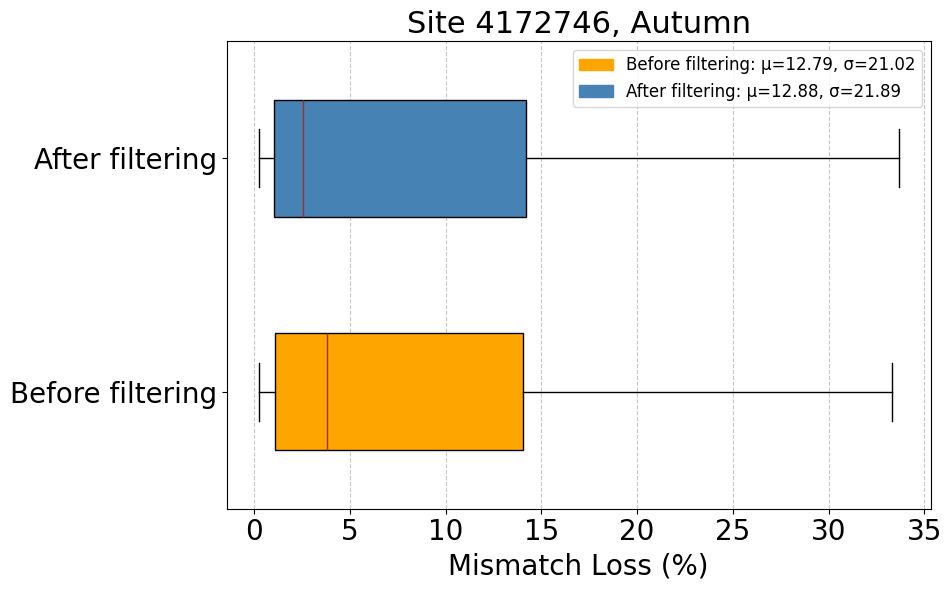

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4123602_spring_20250518_104641
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4123602_spring_20250518_104641\module_param_df.csv
df_pivot shape: (1408, 112)
2024-03-16 12:45:00 → 256284255_diode_activation=-1.0, Voc_256284255_outlier_label=1.0, Isc_256284255_outlier_label=-1.0
2024-03-16 13:50:00 → 256284251_diode_activation=-1.0, Voc_256284251_outlier_label=1.0, Isc_256284251_outlier_label=-1.0
2024-03-16 13:55:00 → 256284251_diode_activation=-1.0, Voc_256284251_outlier_label=1.0, Isc_256284251_outlier_label=-1.0
2024-03-16 14:00:00 → 256284251_diode_activation=-1.0, Voc_256284251_outlier_label=1.0, Isc_256284251_outlier_label=-1.0
2024-03-16 14:05:00 → 256284251_diode_activation=-1.0, Voc_256284251_outlier_label=1.0, Isc_256284251_outlier_label=-1.0
2024-03-18 15:30:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


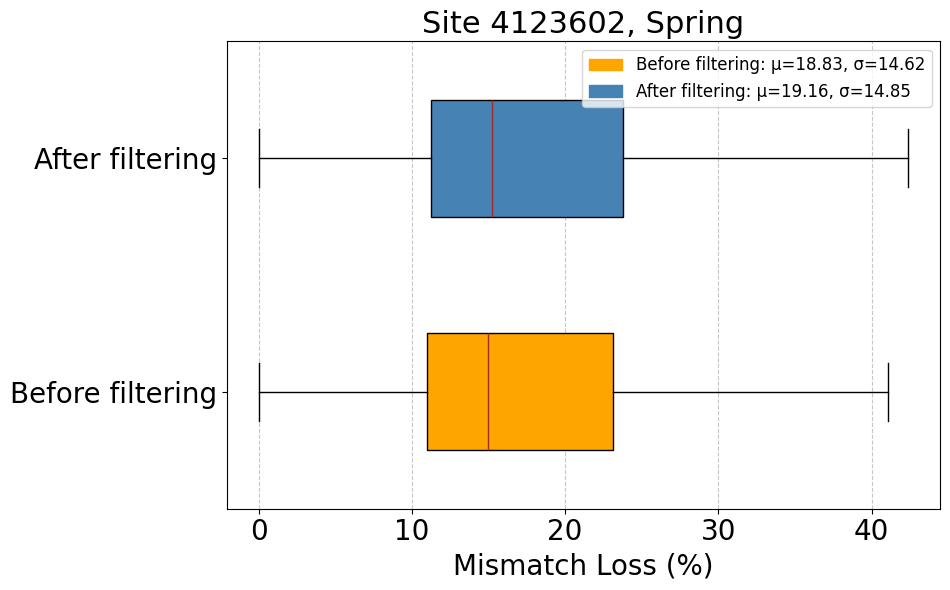

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4123602_summer_20250518_114107
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4123602_summer_20250518_114107\module_param_df.csv
df_pivot shape: (1687, 112)
2024-06-15 12:50:00 → 256284251_diode_activation=-1.0, Voc_256284251_outlier_label=1.0, Isc_256284251_outlier_label=-1.0
2024-06-15 12:55:00 → 256284251_diode_activation=-1.0, Voc_256284251_outlier_label=1.0, Isc_256284251_outlier_label=-1.0
2024-06-15 13:00:00 → 256284251_diode_activation=-1.0, Voc_256284251_outlier_label=1.0, Isc_256284251_outlier_label=-1.0
2024-06-15 13:05:00 → 256284251_diode_activation=-1.0, Voc_256284251_outlier_label=1.0, Isc_256284251_outlier_label=-1.0
2024-06-15 13:15:00 → 256284251_diode_activation=-1.0, Voc_256284251_outlier_label=1.0, Isc_256284251_outlier_label=-1.0
2024-06-15 13:20:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4123602_winter_20250519_122957
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4123602_winter_20250519_122957\module_param_df.csv
df_pivot shape: (1246, 112)
2024-12-15 10:00:00 → 256284256_diode_activation=-1.0, Voc_256284256_outlier_label=1.0, Isc_256284256_outlier_label=-1.0
2024-12-17 13:05:00 → 256284251_diode_activation=-1.0, Voc_256284251_outlier_label=1.0, Isc_256284251_outlier_label=-1.0
2024-12-17 13:10:00 → 256284251_diode_activation=-1.0, Voc_256284251_outlier_label=1.0, Isc_256284251_outlier_label=-1.0
2024-12-17 13:15:00 → 256284251_diode_activation=-1.0, Voc_256284251_outlier_label=1.0, Isc_256284251_outlier_label=-1.0
2024-12-17 13:40:00 → 256284251_diode_activation=-1.0, Voc_256284251_outlier_label=1.0, Isc_256284251_outlier_label=-1.0
2024-12-17 13:45:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4123602_autumn_20250518_115542
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4123602_autumn_20250518_115542\module_param_df.csv
df_pivot shape: (1460, 112)
2024-09-20 13:20:00 → 256284251_diode_activation=-1.0, Voc_256284251_outlier_label=1.0, Isc_256284251_outlier_label=-1.0
2024-09-20 13:40:00 → 256284251_diode_activation=-1.0, Voc_256284251_outlier_label=1.0, Isc_256284251_outlier_label=-1.0
2024-09-20 14:45:00 → 256284245_diode_activation=-1.0, Voc_256284245_outlier_label=1.0, Isc_256284245_outlier_label=-1.0
2024-09-20 14:50:00 → 256284245_diode_activation=-1.0, Voc_256284245_outlier_label=1.0, Isc_256284245_outlier_label=-1.0
2024-09-20 14:55:00 → 256284245_diode_activation=-1.0, Voc_256284245_outlier_label=1.0, Isc_256284245_outlier_label=-1.0
2024-09-21 11:20:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


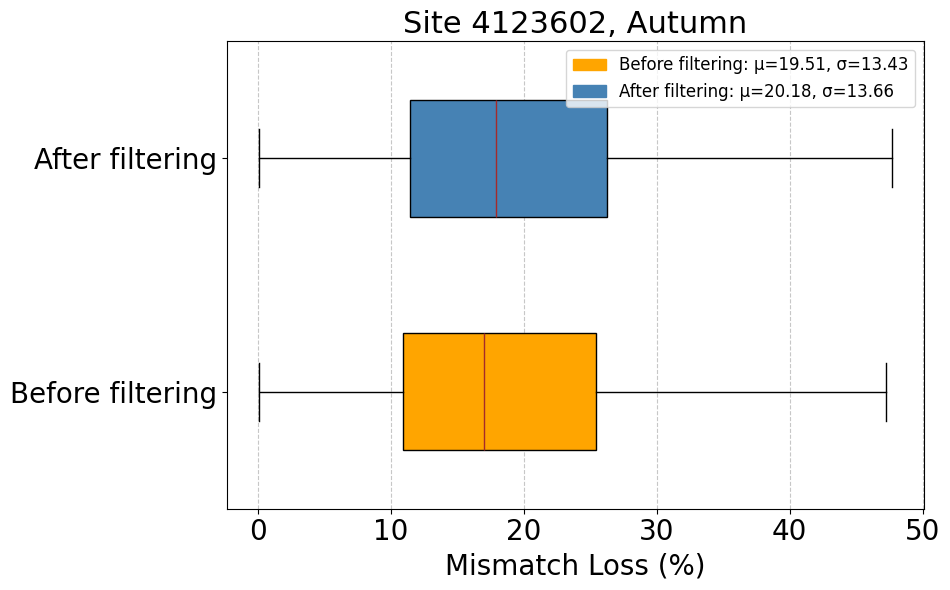

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111846_spring_20250517_185806
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111846_spring_20250517_185806\module_param_df.csv
df_pivot shape: (1477, 112)
2024-03-15 17:50:00 → 247639223_diode_activation=-1.0, Voc_247639223_outlier_label=1.0, Isc_247639223_outlier_label=-1.0
2024-03-16 15:05:00 → 247639028_diode_activation=-1.0, Voc_247639028_outlier_label=1.0, Isc_247639028_outlier_label=-1.0
2024-03-16 15:10:00 → 247639028_diode_activation=-1.0, Voc_247639028_outlier_label=1.0, Isc_247639028_outlier_label=-1.0
2024-03-18 13:45:00 → 247639592_diode_activation=-1.0, Voc_247639592_outlier_label=1.0, Isc_247639592_outlier_label=-1.0
2024-03-18 13:50:00 → 247639592_diode_activation=-1.0, Voc_247639592_outlier_label=1.0, Isc_247639592_outlier_label=-1.0
2024-03-18 13:55:00 → 24

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


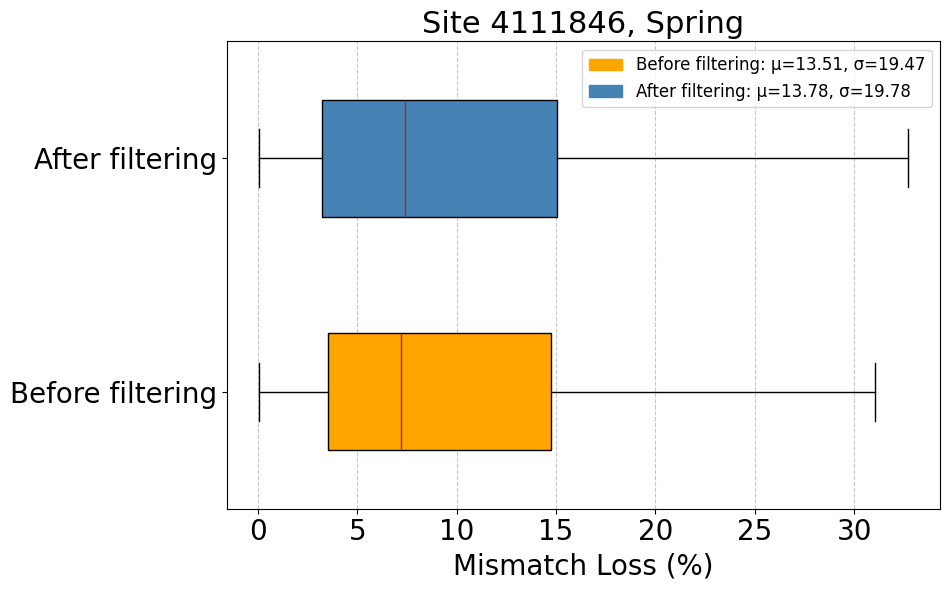

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111846_summer_20250517_191041
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111846_summer_20250517_191041\module_param_df.csv
df_pivot shape: (1771, 112)
2024-06-15 09:20:00 → 247639227_diode_activation=-1.0, Voc_247639227_outlier_label=1.0, Isc_247639227_outlier_label=-1.0
2024-06-15 09:25:00 → 247639227_diode_activation=-1.0, Voc_247639227_outlier_label=1.0, Isc_247639227_outlier_label=-1.0
2024-06-15 09:30:00 → 247639227_diode_activation=-1.0, Voc_247639227_outlier_label=1.0, Isc_247639227_outlier_label=-1.0
2024-06-15 09:35:00 → 247639227_diode_activation=-1.0, Voc_247639227_outlier_label=1.0, Isc_247639227_outlier_label=-1.0
2024-06-15 09:40:00 → 247639227_diode_activation=-1.0, Voc_247639227_outlier_label=1.0, Isc_247639227_outlier_label=-1.0
2024-06-15 09:45:00 → 24

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111846_winter_20250519_115208
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111846_winter_20250519_115208\module_param_df.csv
df_pivot shape: (1197, 112)
2024-12-15 14:30:00 → 247639032_diode_activation=-1.0, Voc_247639032_outlier_label=1.0, Isc_247639032_outlier_label=-1.0
2024-12-15 15:20:00 → 247639230_diode_activation=-1.0, Voc_247639230_outlier_label=1.0, Isc_247639230_outlier_label=-1.0
2024-12-15 16:35:00 → 247639227_diode_activation=1.0, Voc_247639227_outlier_label=-1.0, Isc_247639227_outlier_label=0.0
2024-12-17 15:30:00 → 247639230_diode_activation=-1.0, Voc_247639230_outlier_label=1.0, Isc_247639230_outlier_label=-1.0
2024-12-18 09:05:00 → 247639225_diode_activation=-1.0, Voc_247639225_outlier_label=1.0, Isc_247639225_outlier_label=-1.0
2024-12-18 09:10:00 → 247

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


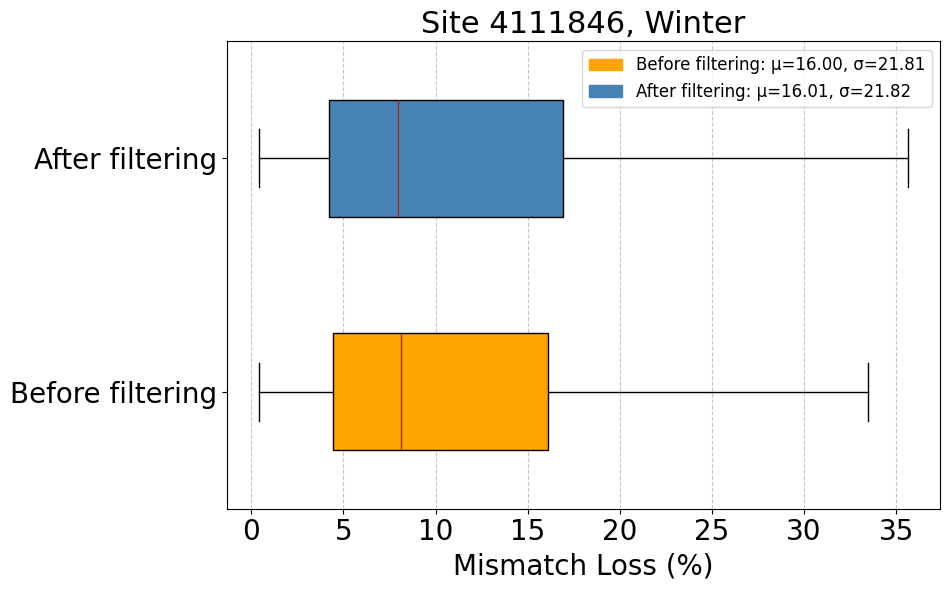

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111846_autumn_20250517_192523
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111846_autumn_20250517_192523\module_param_df.csv
df_pivot shape: (1474, 112)
2024-09-20 10:15:00 → 247639229_diode_activation=-1.0, Voc_247639229_outlier_label=1.0, Isc_247639229_outlier_label=-1.0
2024-09-20 10:20:00 → 247639229_diode_activation=-1.0, Voc_247639229_outlier_label=1.0, Isc_247639229_outlier_label=-1.0
2024-09-20 10:25:00 → 247639229_diode_activation=-1.0, Voc_247639229_outlier_label=1.0, Isc_247639229_outlier_label=-1.0
2024-09-20 10:30:00 → 247639229_diode_activation=-1.0, Voc_247639229_outlier_label=1.0, Isc_247639229_outlier_label=-1.0
2024-09-20 10:35:00 → 247639229_diode_activation=-1.0, Voc_247639229_outlier_label=1.0, Isc_247639229_outlier_label=-1.0
2024-09-20 10:40:00 → 24

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


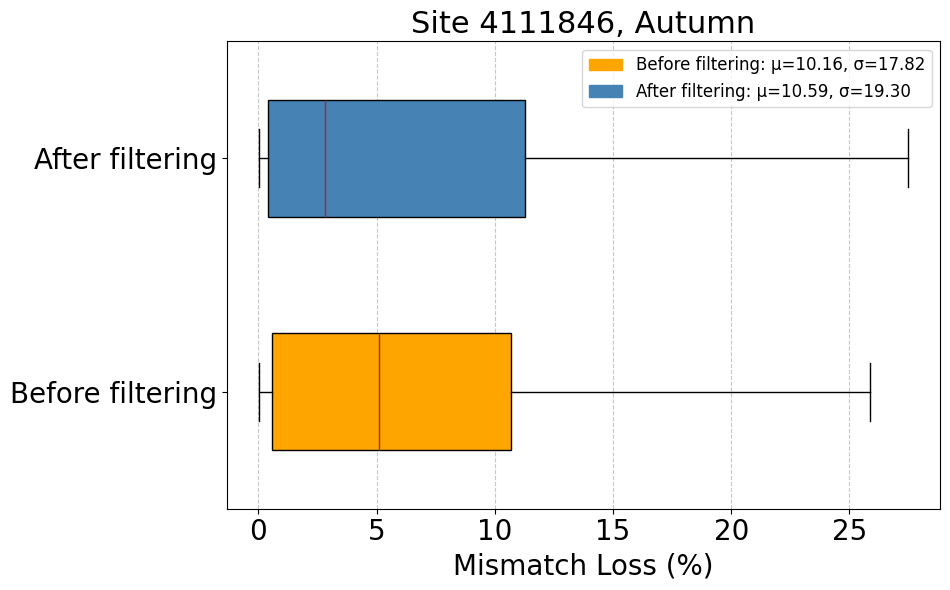

2024-09-26 18:30:00 → 247639223_diode_activation=1.0, Voc_247639223_outlier_label=-1.0, Isc_247639223_outlier_label=0.0
No combined file found in None
Original combined data shape: (1474, 4)
New combined data shape (after removing diode activation timestamps): (1473, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


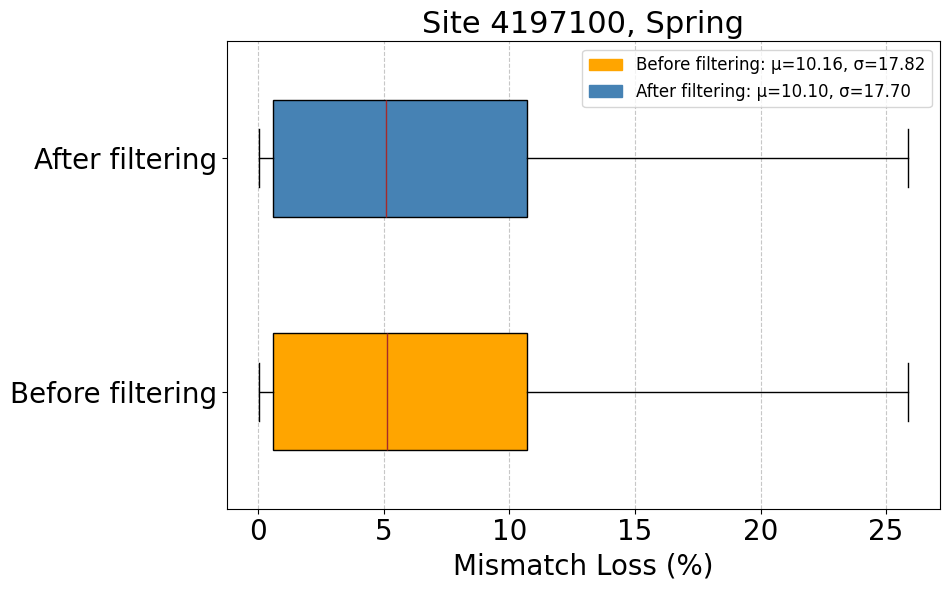

2024-09-26 18:30:00 → 247639223_diode_activation=1.0, Voc_247639223_outlier_label=-1.0, Isc_247639223_outlier_label=0.0
No combined file found in None
Original combined data shape: (1474, 4)
New combined data shape (after removing diode activation timestamps): (1473, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


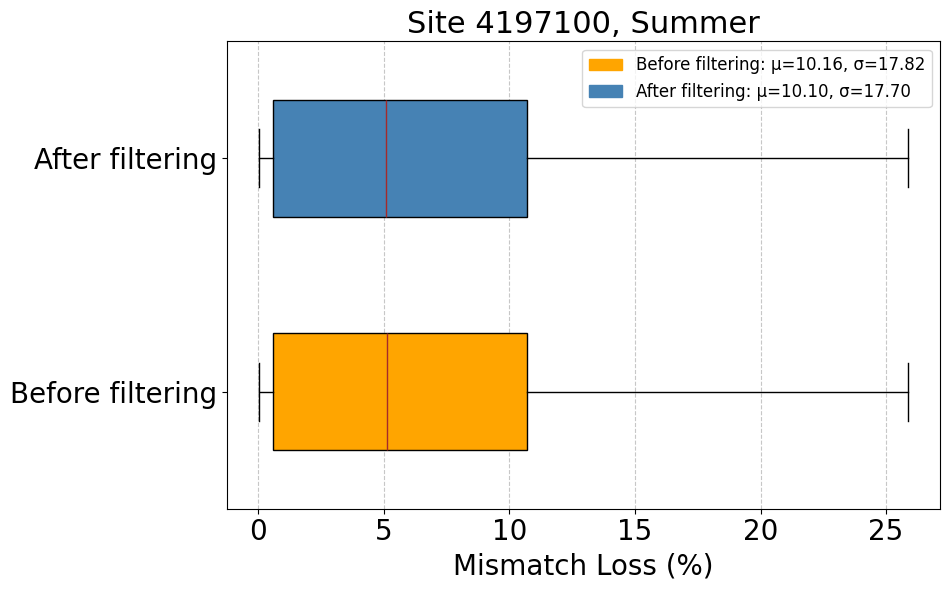

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4197100_winter_20250519_134822
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4197100_winter_20250519_134822\module_param_df.csv
df_pivot shape: (856, 84)
Original combined data shape: (856, 4)
New combined data shape (after removing diode activation timestamps): (856, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


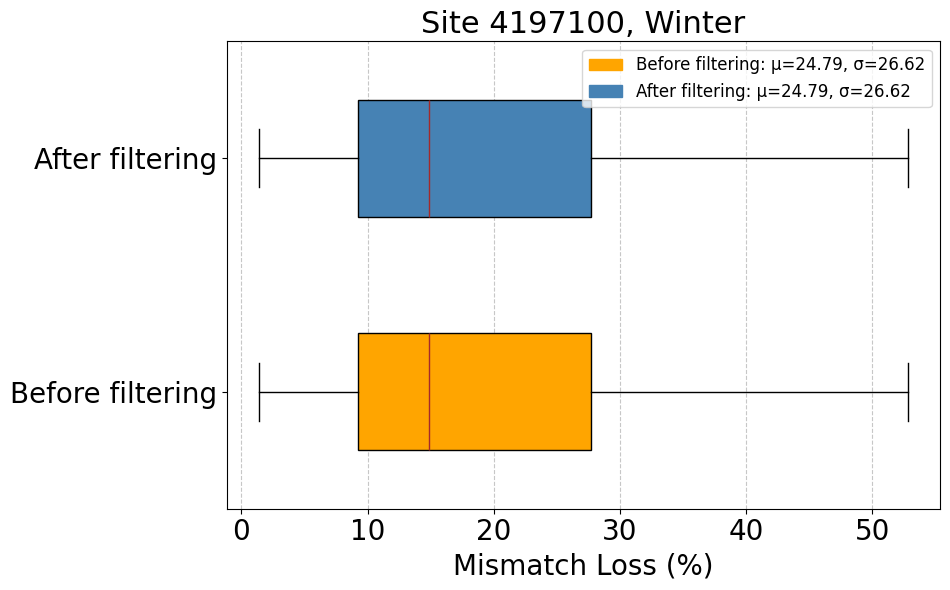

No combined file found in None
Original combined data shape: (856, 4)
New combined data shape (after removing diode activation timestamps): (856, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


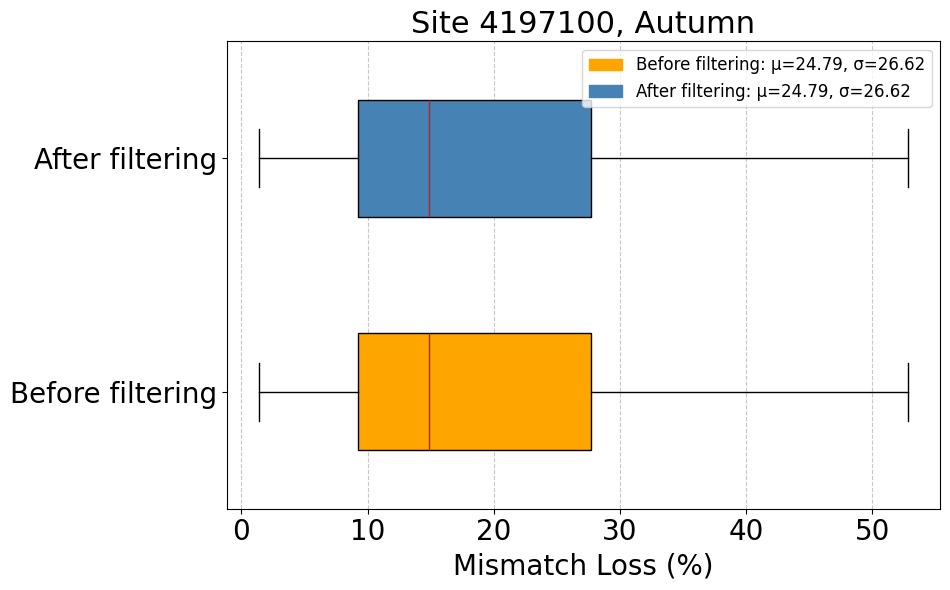

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4093272_spring_20250516_174552
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4093272_spring_20250516_174552\module_param_df.csv
df_pivot shape: (1425, 126)
2024-03-20 14:55:00 → 164811482_diode_activation=-1.0, Voc_164811482_outlier_label=1.0, Isc_164811482_outlier_label=-1.0
2024-03-20 15:00:00 → 164811482_diode_activation=-1.0, Voc_164811482_outlier_label=1.0, Isc_164811482_outlier_label=-1.0
2024-03-20 15:05:00 → 164811482_diode_activation=-1.0, Voc_164811482_outlier_label=1.0, Isc_164811482_outlier_label=-1.0
2024-03-20 15:10:00 → 164811482_diode_activation=-1.0, Voc_164811482_outlier_label=1.0, Isc_164811482_outlier_label=-1.0
2024-03-20 15:15:00 → 164811482_diode_activation=-1.0, Voc_164811482_outlier_label=1.0, Isc_164811482_outlier_label=-1.0
2024-03-20 15:20:00 → 16

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


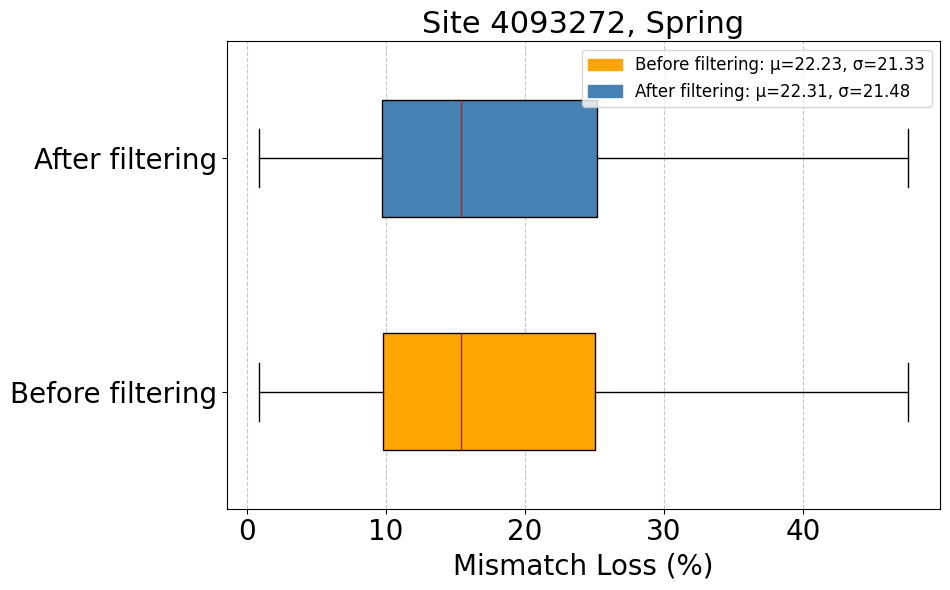

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4093272_summer_20250516_175732
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4093272_summer_20250516_175732\module_param_df.csv
df_pivot shape: (1961, 126)
2024-06-22 16:45:00 → 164811431_diode_activation=1.0, Voc_164811431_outlier_label=-1.0, Isc_164811431_outlier_label=0.0
2024-06-22 16:50:00 → 164811482_diode_activation=-1.0, Voc_164811482_outlier_label=1.0, Isc_164811482_outlier_label=-1.0
2024-06-22 17:20:00 → 164811484_diode_activation=1.0, Voc_164811484_outlier_label=-1.0, Isc_164811484_outlier_label=0.0
2024-06-23 07:30:00 → 164811443_diode_activation=-1.0, Voc_164811443_outlier_label=1.0, Isc_164811443_outlier_label=-1.0
2024-06-24 08:35:00 → 164811442_diode_activation=-1.0, Voc_164811442_outlier_label=1.0, Isc_164811442_outlier_label=-1.0
2024-06-24 16:35:00 → 1648

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


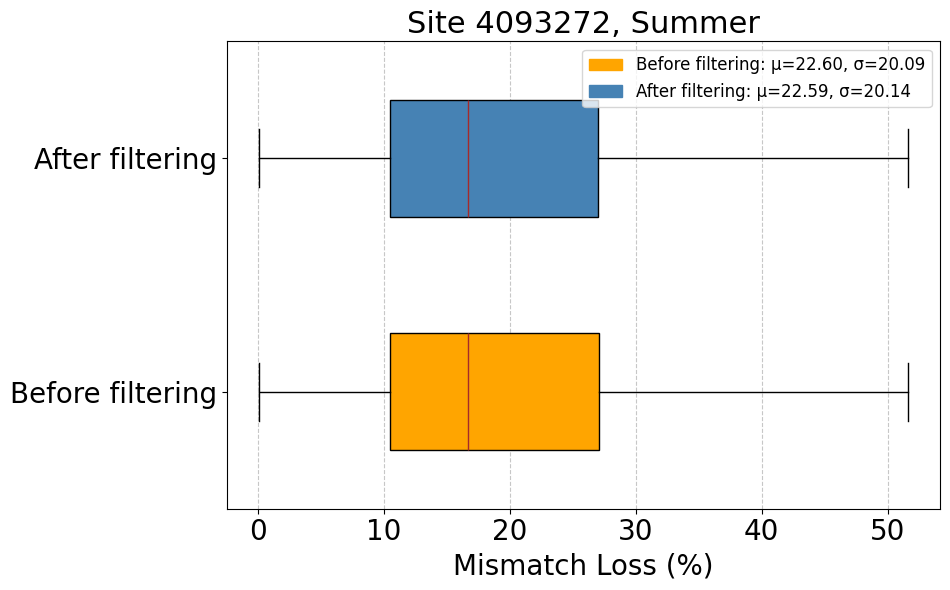

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4093272_winter_20250519_112258
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4093272_winter_20250519_112258\module_param_df.csv
df_pivot shape: (871, 126)
2024-12-22 15:50:00 → 164811443_diode_activation=1.0, Voc_164811443_outlier_label=-1.0, Isc_164811443_outlier_label=0.0
2024-12-22 15:55:00 → 164811443_diode_activation=1.0, Voc_164811443_outlier_label=-1.0, Isc_164811443_outlier_label=0.0
2024-12-22 16:00:00 → 164811443_diode_activation=1.0, Voc_164811443_outlier_label=-1.0, Isc_164811443_outlier_label=0.0
Original combined data shape: (871, 4)
New combined data shape (after removing diode activation timestamps): (868, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


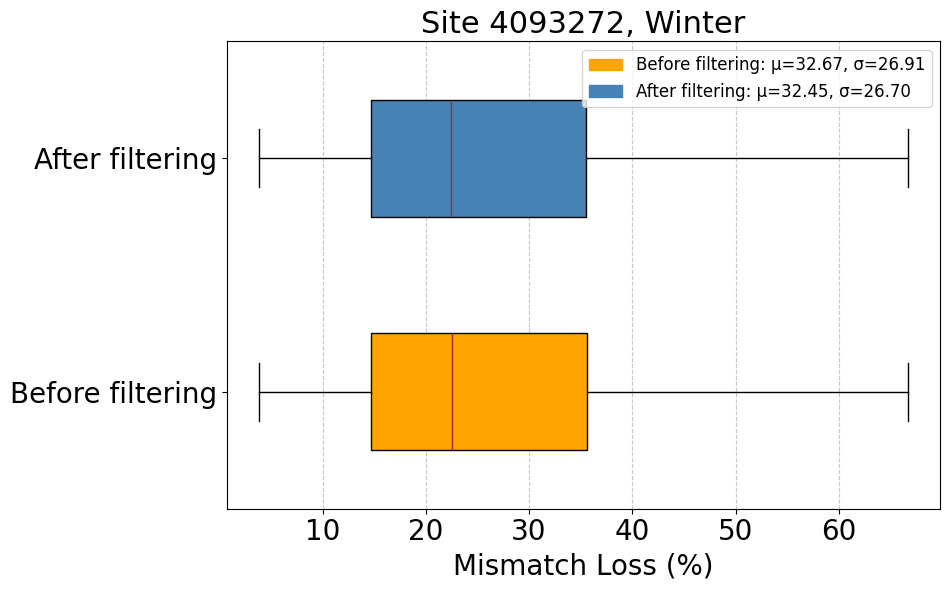

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4093272_autumn_20250516_181359
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4093272_autumn_20250516_181359\module_param_df.csv
df_pivot shape: (1441, 126)
2024-09-20 14:25:00 → 164811441_diode_activation=-1.0, Voc_164811441_outlier_label=1.0, Isc_164811441_outlier_label=-1.0
2024-09-20 15:05:00 → 164811482_diode_activation=-1.0, Voc_164811482_outlier_label=1.0, Isc_164811482_outlier_label=-1.0
2024-09-20 15:40:00 → 164811482_diode_activation=-1.0, Voc_164811482_outlier_label=1.0, Isc_164811482_outlier_label=-1.0
2024-09-20 15:45:00 → 164811482_diode_activation=-1.0, Voc_164811482_outlier_label=1.0, Isc_164811482_outlier_label=-1.0
2024-09-20 15:50:00 → 164811482_diode_activation=-1.0, Voc_164811482_outlier_label=1.0, Isc_164811482_outlier_label=-1.0
2024-09-20 15:55:00 → 16

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


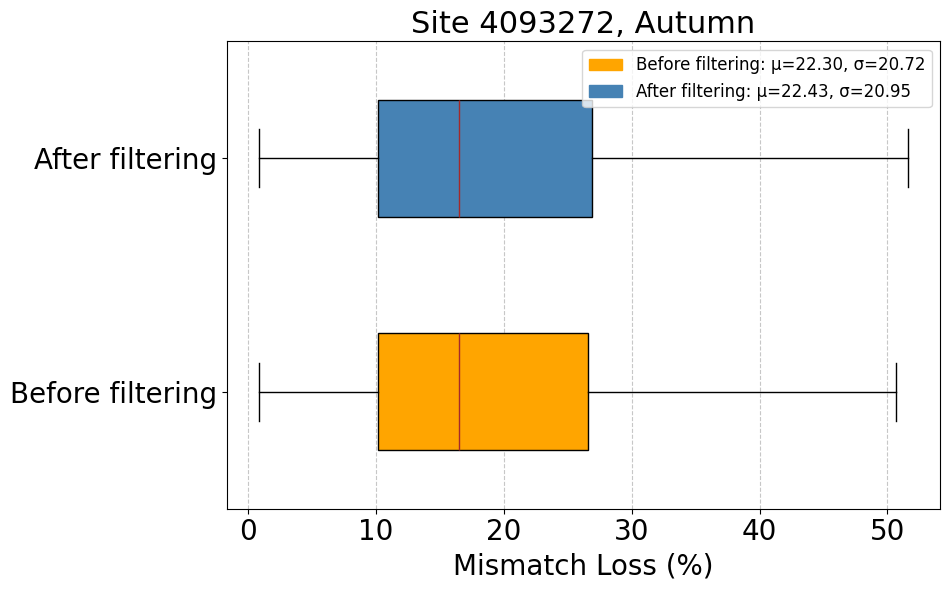

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4173851_spring_20250518_144759
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4173851_spring_20250518_144759\module_param_df.csv
df_pivot shape: (1465, 217)
2024-03-16 13:20:00 → 260957750_diode_activation=-1.0, Voc_260957750_outlier_label=1.0, Isc_260957750_outlier_label=-1.0
2024-03-16 13:20:00 → 260957977_diode_activation=-1.0, Voc_260957977_outlier_label=1.0, Isc_260957977_outlier_label=-1.0
2024-03-16 14:40:00 → 260957750_diode_activation=-1.0, Voc_260957750_outlier_label=1.0, Isc_260957750_outlier_label=-1.0
2024-03-18 13:40:00 → 260957452_diode_activation=-1.0, Voc_260957452_outlier_label=1.0, Isc_260957452_outlier_label=-1.0
2024-03-18 13:40:00 → 260957624_diode_activation=-1.0, Voc_260957624_outlier_label=1.0, Isc_260957624_outlier_label=-1.0
2024-03-19 17:00:00 → 26

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


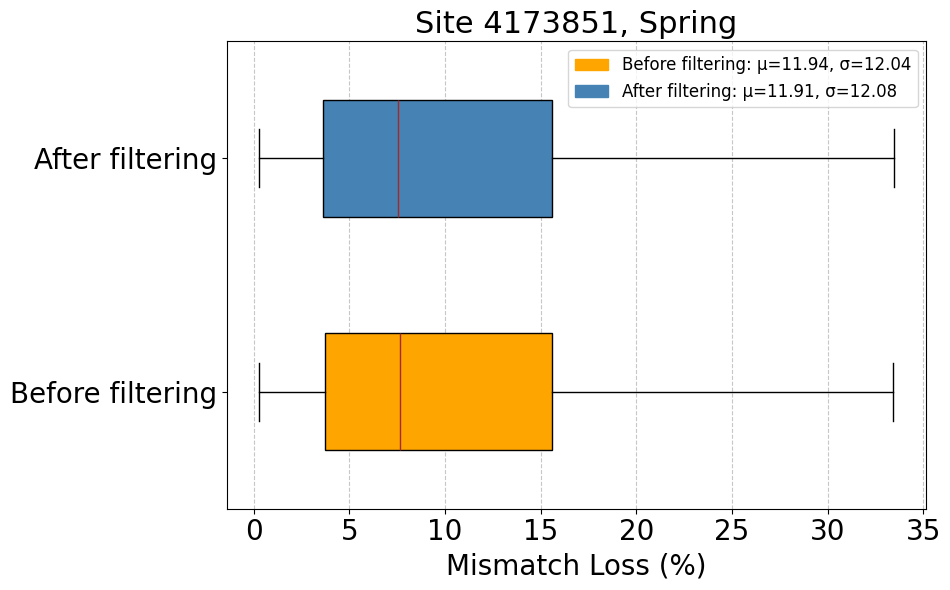

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4173851_summer_20250518_150539
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4173851_summer_20250518_150539\module_param_df.csv
df_pivot shape: (1922, 217)
2024-06-15 13:05:00 → 260957623_diode_activation=-1.0, Voc_260957623_outlier_label=1.0, Isc_260957623_outlier_label=-1.0
2024-06-15 13:10:00 → 260957623_diode_activation=-1.0, Voc_260957623_outlier_label=1.0, Isc_260957623_outlier_label=-1.0
2024-06-15 13:10:00 → 260957624_diode_activation=-1.0, Voc_260957624_outlier_label=1.0, Isc_260957624_outlier_label=-1.0
2024-06-15 13:10:00 → 260957751_diode_activation=-1.0, Voc_260957751_outlier_label=1.0, Isc_260957751_outlier_label=-1.0
2024-06-15 13:40:00 → 260957621_diode_activation=-1.0, Voc_260957621_outlier_label=1.0, Isc_260957621_outlier_label=-1.0
2024-06-15 13:40:00 → 26

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


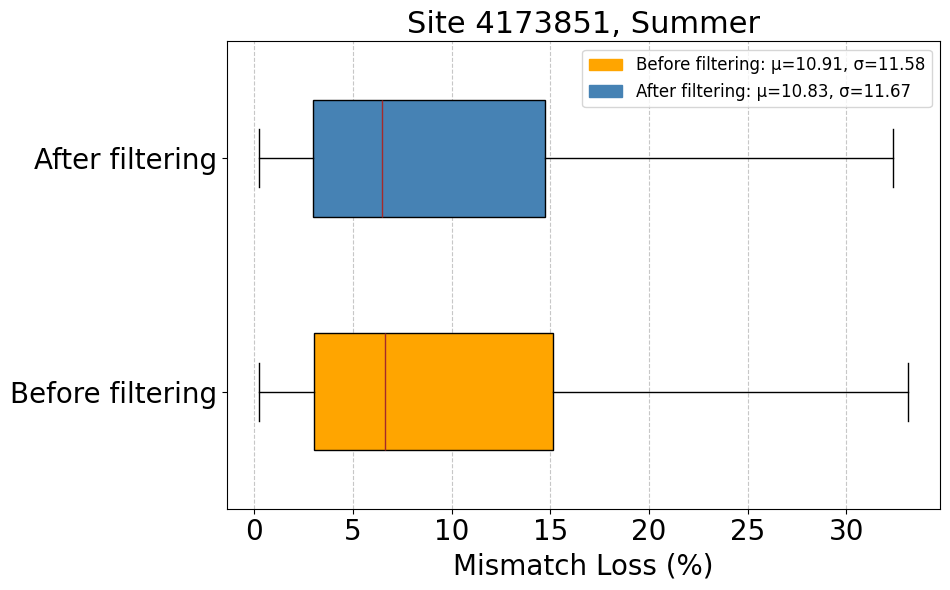

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4173851_winter_20250519_131308
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4173851_winter_20250519_131308\module_param_df.csv
df_pivot shape: (986, 217)
2024-12-16 13:15:00 → 260957809_diode_activation=-1.0, Voc_260957809_outlier_label=1.0, Isc_260957809_outlier_label=-1.0
2024-12-16 13:20:00 → 260957809_diode_activation=-1.0, Voc_260957809_outlier_label=1.0, Isc_260957809_outlier_label=-1.0
2024-12-16 13:55:00 → 260957627_diode_activation=-1.0, Voc_260957627_outlier_label=1.0, Isc_260957627_outlier_label=-1.0
2024-12-16 14:00:00 → 260957627_diode_activation=-1.0, Voc_260957627_outlier_label=1.0, Isc_260957627_outlier_label=-1.0
2024-12-16 14:20:00 → 260957452_diode_activation=-1.0, Voc_260957452_outlier_label=1.0, Isc_260957452_outlier_label=-1.0
2024-12-17 12:30:00 → 260

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


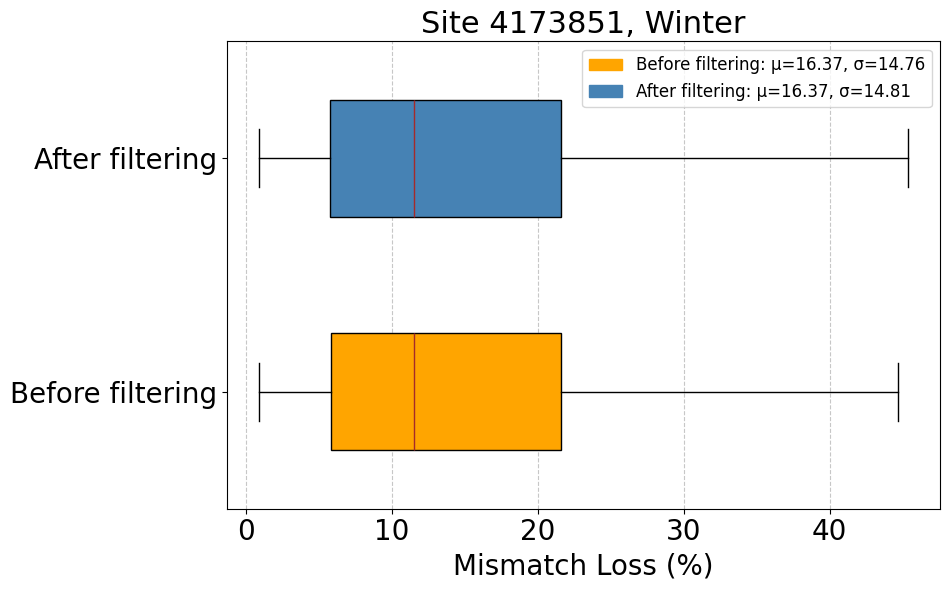

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4173851_autumn_20250518_152922
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4173851_autumn_20250518_152922\module_param_df.csv
df_pivot shape: (1450, 217)
2024-09-20 10:10:00 → 260957622_diode_activation=-1.0, Voc_260957622_outlier_label=1.0, Isc_260957622_outlier_label=-1.0
2024-09-20 11:20:00 → 260957751_diode_activation=-1.0, Voc_260957751_outlier_label=1.0, Isc_260957751_outlier_label=-1.0
2024-09-21 10:10:00 → 260957622_diode_activation=-1.0, Voc_260957622_outlier_label=1.0, Isc_260957622_outlier_label=-1.0
2024-09-21 10:45:00 → 260957757_diode_activation=-1.0, Voc_260957757_outlier_label=1.0, Isc_260957757_outlier_label=-1.0
2024-09-21 10:50:00 → 260957809_diode_activation=-1.0, Voc_260957809_outlier_label=1.0, Isc_260957809_outlier_label=-1.0
2024-09-21 11:15:00 → 26

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


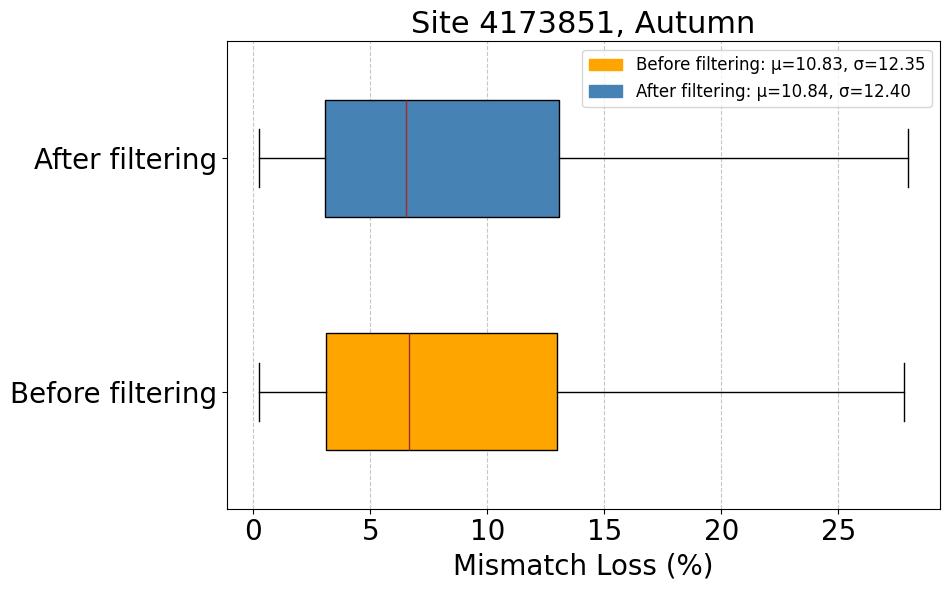

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4002138_spring_20250516_143513
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4002138_spring_20250516_143513\module_param_df.csv
df_pivot shape: (1515, 98)
Original combined data shape: (1515, 4)
New combined data shape (after removing diode activation timestamps): (1515, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


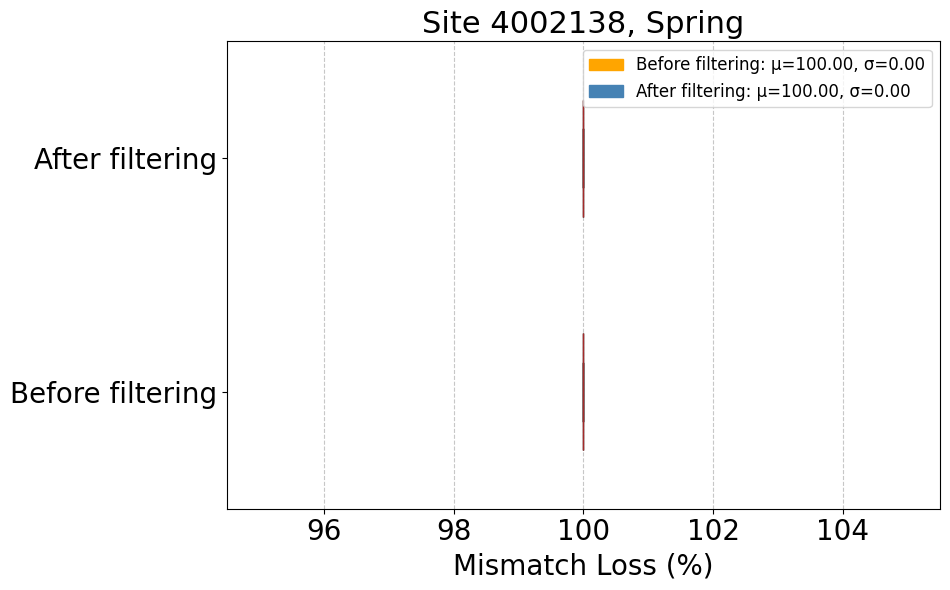

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4002138_summer_20250516_144605
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4002138_summer_20250516_144605\module_param_df.csv
df_pivot shape: (1762, 126)
2024-12-15 17:25:00 → 251791337_diode_activation=-1.0, Voc_251791337_outlier_label=1.0, Isc_251791337_outlier_label=-1.0
2024-12-15 17:30:00 → 251791337_diode_activation=-1.0, Voc_251791337_outlier_label=1.0, Isc_251791337_outlier_label=-1.0
2024-12-15 17:40:00 → 251791337_diode_activation=-1.0, Voc_251791337_outlier_label=1.0, Isc_251791337_outlier_label=-1.0
2024-12-15 18:15:00 → 251791337_diode_activation=-1.0, Voc_251791337_outlier_label=1.0, Isc_251791337_outlier_label=-1.0
2024-12-15 18:20:00 → 251791337_diode_activation=-1.0, Voc_251791337_outlier_label=1.0, Isc_251791337_outlier_label=-1.0
2024-12-15 18:25:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


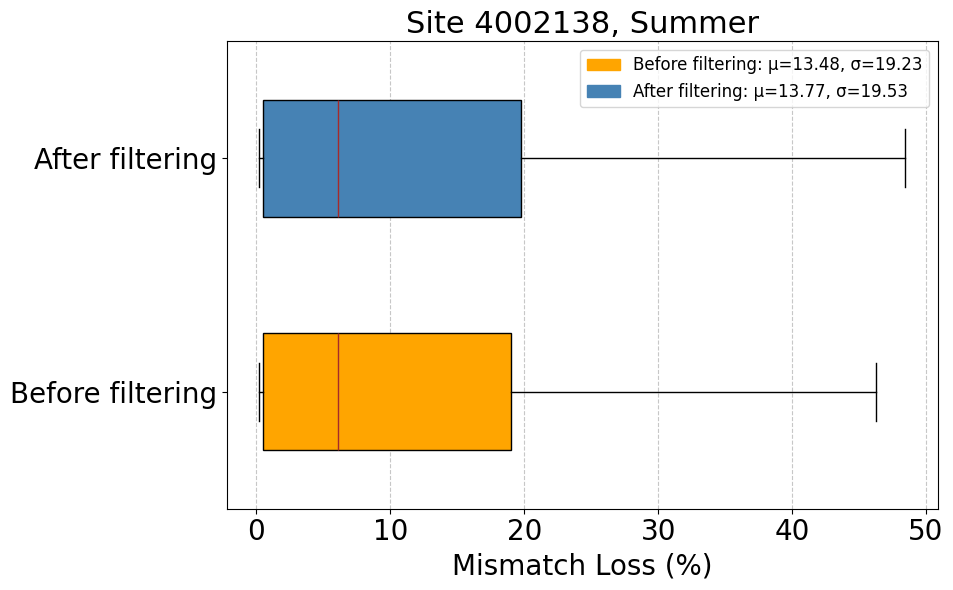

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4002138_winter_20250519_104617
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4002138_winter_20250519_104617\module_param_df.csv
df_pivot shape: (1175, 126)
2024-06-15 17:05:00 → 251791345_diode_activation=1.0, Voc_251791345_outlier_label=-1.0, Isc_251791345_outlier_label=0.0
Original combined data shape: (1175, 4)
New combined data shape (after removing diode activation timestamps): (1174, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


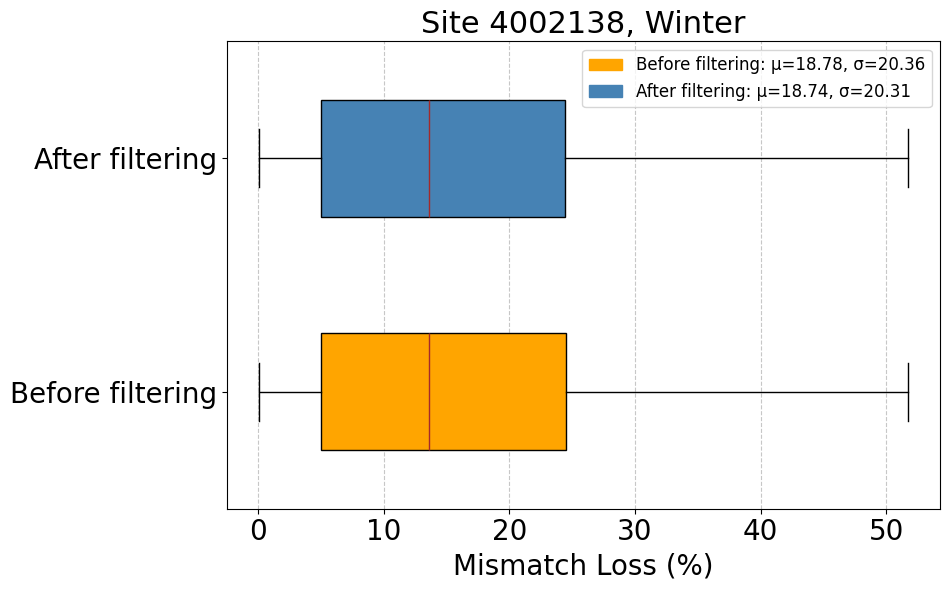

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4002138_autumn_20250516_150724
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4002138_autumn_20250516_150724\module_param_df.csv
df_pivot shape: (1485, 126)
2024-03-15 17:40:00 → 251791341_diode_activation=-1.0, Voc_251791341_outlier_label=1.0, Isc_251791341_outlier_label=-1.0
2024-03-15 17:45:00 → 251791341_diode_activation=-1.0, Voc_251791341_outlier_label=1.0, Isc_251791341_outlier_label=-1.0
2024-03-15 17:50:00 → 251791341_diode_activation=-1.0, Voc_251791341_outlier_label=1.0, Isc_251791341_outlier_label=-1.0
2024-03-15 18:05:00 → 251791351_diode_activation=-1.0, Voc_251791351_outlier_label=1.0, Isc_251791351_outlier_label=-1.0
2024-03-15 18:10:00 → 251791341_diode_activation=-1.0, Voc_251791341_outlier_label=1.0, Isc_251791341_outlier_label=-1.0
2024-03-15 18:10:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


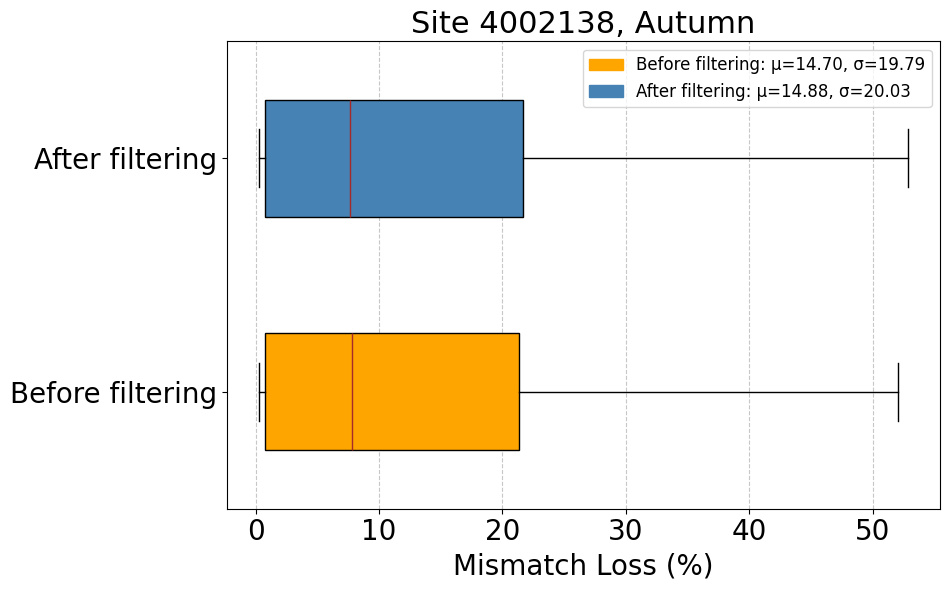

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111492_spring_20250516_182629
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111492_spring_20250516_182629\module_param_df.csv
df_pivot shape: (1439, 210)
2024-03-15 10:05:00 → 256552540_diode_activation=-1.0, Voc_256552540_outlier_label=1.0, Isc_256552540_outlier_label=-1.0
2024-03-15 10:10:00 → 256552540_diode_activation=-1.0, Voc_256552540_outlier_label=1.0, Isc_256552540_outlier_label=-1.0
2024-03-15 10:15:00 → 256552540_diode_activation=-1.0, Voc_256552540_outlier_label=1.0, Isc_256552540_outlier_label=-1.0
2024-03-15 10:15:00 → 256611245_diode_activation=-1.0, Voc_256611245_outlier_label=1.0, Isc_256611245_outlier_label=-1.0
2024-03-15 10:20:00 → 256552540_diode_activation=-1.0, Voc_256552540_outlier_label=1.0, Isc_256552540_outlier_label=-1.0
2024-03-15 10:20:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


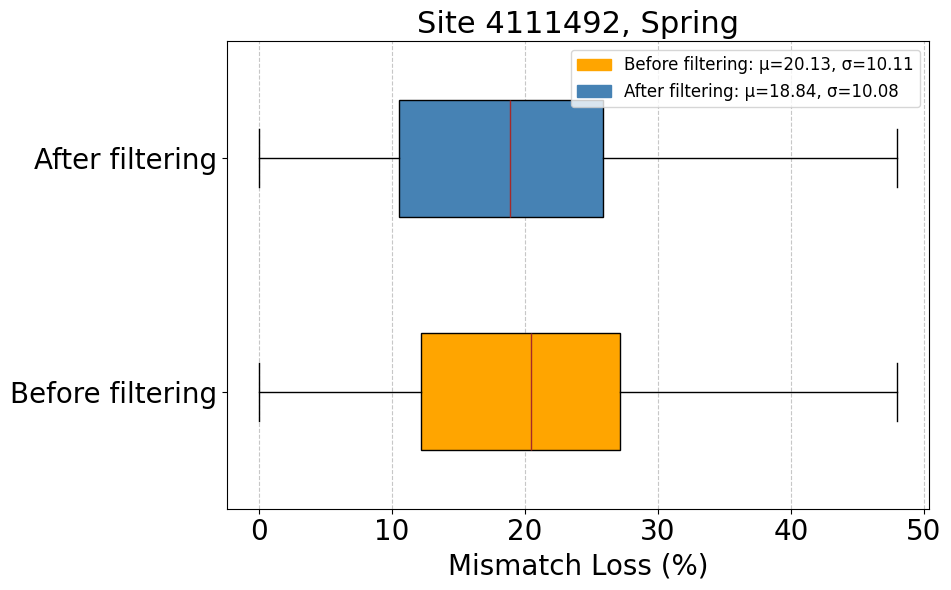

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111492_summer_20250516_184041
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111492_summer_20250516_184041\module_param_df.csv
df_pivot shape: (1825, 210)
2024-06-16 09:30:00 → 256552539_diode_activation=-1.0, Voc_256552539_outlier_label=1.0, Isc_256552539_outlier_label=-1.0
2024-06-17 09:00:00 → 256552539_diode_activation=-1.0, Voc_256552539_outlier_label=1.0, Isc_256552539_outlier_label=-1.0
2024-06-17 09:05:00 → 256552539_diode_activation=-1.0, Voc_256552539_outlier_label=1.0, Isc_256552539_outlier_label=-1.0
2024-06-17 09:10:00 → 256552539_diode_activation=-1.0, Voc_256552539_outlier_label=1.0, Isc_256552539_outlier_label=-1.0
2024-06-17 09:15:00 → 256552539_diode_activation=-1.0, Voc_256552539_outlier_label=1.0, Isc_256552539_outlier_label=-1.0
2024-06-17 09:20:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


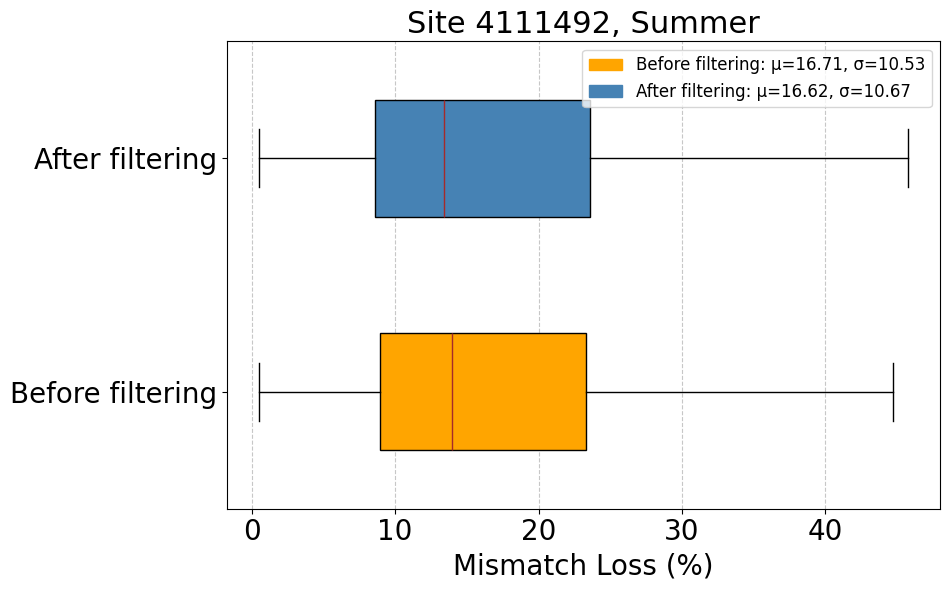

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111492_winter_20250519_113034
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111492_winter_20250519_113034\module_param_df.csv
df_pivot shape: (1094, 210)
2024-12-16 14:35:00 → 256611361_diode_activation=1.0, Voc_256611361_outlier_label=-1.0, Isc_256611361_outlier_label=0.0
Original combined data shape: (1094, 4)
New combined data shape (after removing diode activation timestamps): (1093, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


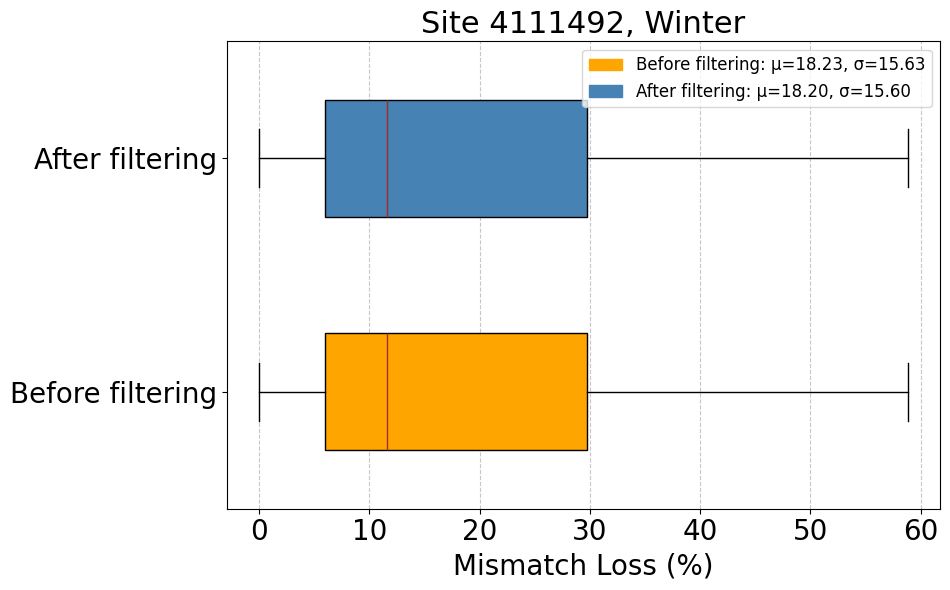

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111492_autumn_20250516_204721
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111492_autumn_20250516_204721\module_param_df.csv
df_pivot shape: (1473, 210)
2024-09-20 09:30:00 → 256552540_diode_activation=-1.0, Voc_256552540_outlier_label=1.0, Isc_256552540_outlier_label=-1.0
2024-09-20 09:35:00 → 256552540_diode_activation=-1.0, Voc_256552540_outlier_label=1.0, Isc_256552540_outlier_label=-1.0
2024-09-20 09:40:00 → 256552540_diode_activation=-1.0, Voc_256552540_outlier_label=1.0, Isc_256552540_outlier_label=-1.0
2024-09-20 09:45:00 → 256552540_diode_activation=-1.0, Voc_256552540_outlier_label=1.0, Isc_256552540_outlier_label=-1.0
2024-09-20 09:50:00 → 256552540_diode_activation=-1.0, Voc_256552540_outlier_label=1.0, Isc_256552540_outlier_label=-1.0
2024-09-20 09:50:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


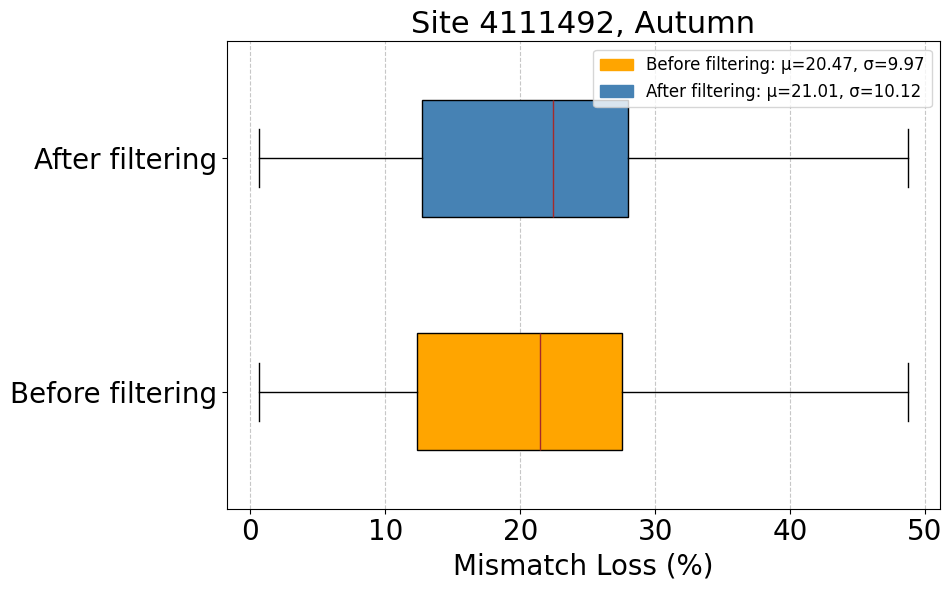

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111800_spring_20250516_210921
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111800_spring_20250516_210921\module_param_df.csv
df_pivot shape: (1481, 203)
Original combined data shape: (1481, 4)
New combined data shape (after removing diode activation timestamps): (1481, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


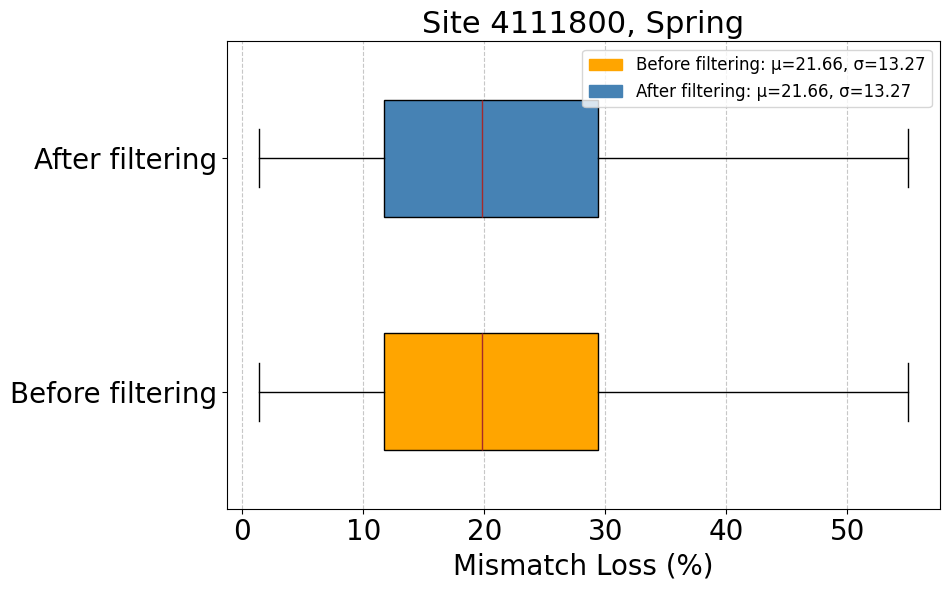

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111800_summer_20250516_214105
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111800_summer_20250516_214105\module_param_df.csv
df_pivot shape: (1745, 203)
2024-06-15 10:10:00 → 256986886_diode_activation=-1.0, Voc_256986886_outlier_label=1.0, Isc_256986886_outlier_label=-1.0
2024-06-15 10:15:00 → 256986886_diode_activation=-1.0, Voc_256986886_outlier_label=1.0, Isc_256986886_outlier_label=-1.0
2024-06-15 10:20:00 → 256986886_diode_activation=-1.0, Voc_256986886_outlier_label=1.0, Isc_256986886_outlier_label=-1.0
2024-06-15 14:55:00 → 256986713_diode_activation=-1.0, Voc_256986713_outlier_label=1.0, Isc_256986713_outlier_label=-1.0
2024-06-15 15:00:00 → 256986712_diode_activation=-1.0, Voc_256986712_outlier_label=1.0, Isc_256986712_outlier_label=-1.0
2024-06-15 15:00:00 → 25

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111800_winter_20250519_114145
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111800_winter_20250519_114145\module_param_df.csv
df_pivot shape: (1209, 203)
Original combined data shape: (1209, 4)
New combined data shape (after removing diode activation timestamps): (1209, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111800_autumn_20250517_183652
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4111800_autumn_20250517_183652\module_param_df.csv
df_pivot shape: (1456, 203)
Original combined data shape: (1456, 4)
New combined data shape (after removing diode activation timestamps): (1456, 4)
Columns in combined_df: ['Sum of I*V (W)', 'Pmppt (W)', 'Season', 'Site ID']


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


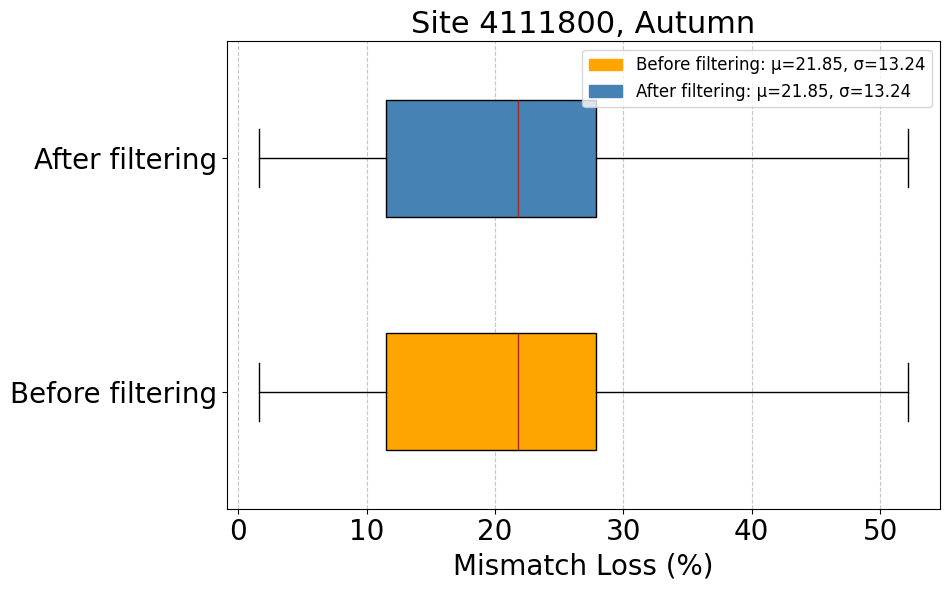

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4034376_spring_20250516_152652
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4034376_spring_20250516_152652\module_param_df.csv
df_pivot shape: (1496, 98)
2024-09-22 09:30:00 → 253276328_diode_activation=-1.0, Voc_253276328_outlier_label=1.0, Isc_253276328_outlier_label=-1.0
2024-09-22 09:30:00 → 253276339_diode_activation=-1.0, Voc_253276339_outlier_label=1.0, Isc_253276339_outlier_label=-1.0
2024-09-22 17:15:00 → 253276334_diode_activation=-1.0, Voc_253276334_outlier_label=1.0, Isc_253276334_outlier_label=-1.0
2024-09-23 13:15:00 → 253276334_diode_activation=-1.0, Voc_253276334_outlier_label=1.0, Isc_253276334_outlier_label=-1.0
2024-09-26 08:25:00 → 253276335_diode_activation=-1.0, Voc_253276335_outlier_label=1.0, Isc_253276335_outlier_label=-1.0
2024-09-26 08:30:00 → 253

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4034376_summer_20250516_160859
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4034376_summer_20250516_160859\module_param_df.csv
df_pivot shape: (1785, 98)
2024-12-17 09:05:00 → 253276340_diode_activation=-1.0, Voc_253276340_outlier_label=1.0, Isc_253276340_outlier_label=-1.0
2024-12-17 11:30:00 → 253276328_diode_activation=-1.0, Voc_253276328_outlier_label=1.0, Isc_253276328_outlier_label=-1.0
2024-12-17 11:30:00 → 253276340_diode_activation=-1.0, Voc_253276340_outlier_label=1.0, Isc_253276340_outlier_label=-1.0
2024-12-17 19:15:00 → 253276339_diode_activation=-1.0, Voc_253276339_outlier_label=1.0, Isc_253276339_outlier_label=-1.0
2024-12-18 10:10:00 → 253276338_diode_activation=-1.0, Voc_253276338_outlier_label=1.0, Isc_253276338_outlier_label=-1.0
2024-12-18 19:15:00 → 253

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


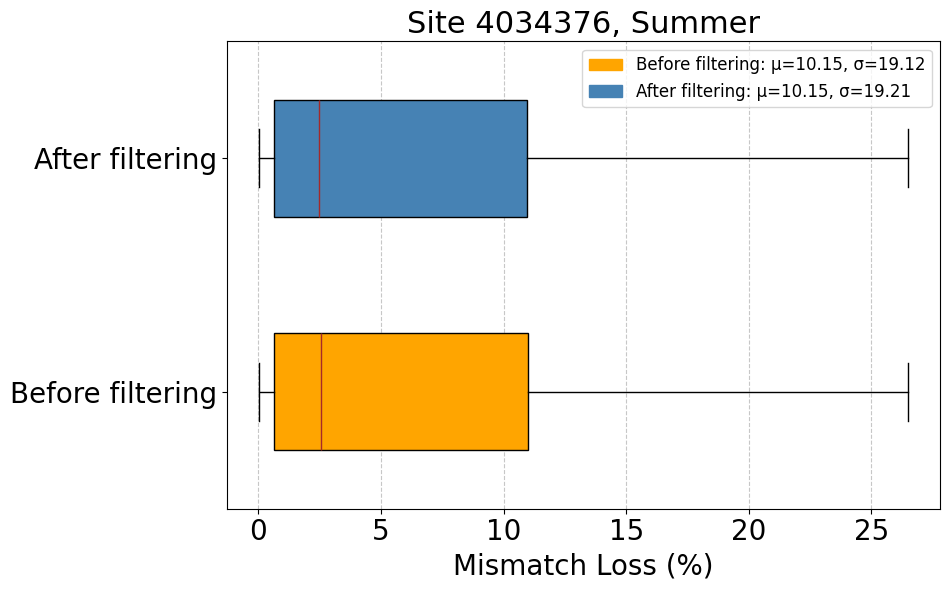

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4034376_winter_20250519_105712
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4034376_winter_20250519_105712\module_param_df.csv
df_pivot shape: (1213, 98)
2024-06-16 09:50:00 → 253276332_diode_activation=-1.0, Voc_253276332_outlier_label=1.0, Isc_253276332_outlier_label=-1.0
2024-06-16 11:40:00 → 253276335_diode_activation=-1.0, Voc_253276335_outlier_label=1.0, Isc_253276335_outlier_label=-1.0
2024-06-16 11:45:00 → 253276335_diode_activation=-1.0, Voc_253276335_outlier_label=1.0, Isc_253276335_outlier_label=-1.0
2024-06-16 11:50:00 → 253276329_diode_activation=-1.0, Voc_253276329_outlier_label=1.0, Isc_253276329_outlier_label=-1.0
2024-06-16 11:55:00 → 253276329_diode_activation=-1.0, Voc_253276329_outlier_label=1.0, Isc_253276329_outlier_label=-1.0
2024-06-16 15:20:00 → 253

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4034376_autumn_20250516_162258
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4034376_autumn_20250516_162258\module_param_df.csv
df_pivot shape: (1501, 98)
2024-03-15 11:00:00 → 253276338_diode_activation=-1.0, Voc_253276338_outlier_label=1.0, Isc_253276338_outlier_label=-1.0
2024-03-16 09:50:00 → 253276335_diode_activation=-1.0, Voc_253276335_outlier_label=1.0, Isc_253276335_outlier_label=-1.0
2024-03-16 09:55:00 → 253276335_diode_activation=-1.0, Voc_253276335_outlier_label=1.0, Isc_253276335_outlier_label=-1.0
2024-03-18 09:55:00 → 253276335_diode_activation=-1.0, Voc_253276335_outlier_label=1.0, Isc_253276335_outlier_label=-1.0
2024-03-18 12:25:00 → 253276329_diode_activation=-1.0, Voc_253276329_outlier_label=1.0, Isc_253276329_outlier_label=-1.0
2024-03-18 16:15:00 → 253

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\3455043_spring_20250516_110219
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\3455043_spring_20250516_110219\module_param_df.csv
df_pivot shape: (1498, 168)


C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:55: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_pivot.index = pd.to_datetime(df_pivot.index)


2024-09-20 14:30:00 → 226780740_diode_activation=-1.0, Voc_226780740_outlier_label=1.0, Isc_226780740_outlier_label=-1.0
2024-09-20 14:55:00 → 226780742_diode_activation=-1.0, Voc_226780742_outlier_label=1.0, Isc_226780742_outlier_label=-1.0
2024-09-20 16:25:00 → 226780326_diode_activation=-1.0, Voc_226780326_outlier_label=1.0, Isc_226780326_outlier_label=-1.0
2024-09-21 15:25:00 → 226780734_diode_activation=-1.0, Voc_226780734_outlier_label=1.0, Isc_226780734_outlier_label=-1.0
2024-09-21 16:35:00 → 226780736_diode_activation=-1.0, Voc_226780736_outlier_label=1.0, Isc_226780736_outlier_label=-1.0
2024-09-22 14:10:00 → 226780742_diode_activation=-1.0, Voc_226780742_outlier_label=1.0, Isc_226780742_outlier_label=-1.0
2024-09-23 15:50:00 → 226780735_diode_activation=-1.0, Voc_226780735_outlier_label=1.0, Isc_226780735_outlier_label=-1.0
2024-09-25 14:45:00 → 226782364_diode_activation=-1.0, Voc_226782364_outlier_label=1.0, Isc_226782364_outlier_label=-1.0
2024-09-25 15:25:00 → 226780729_

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


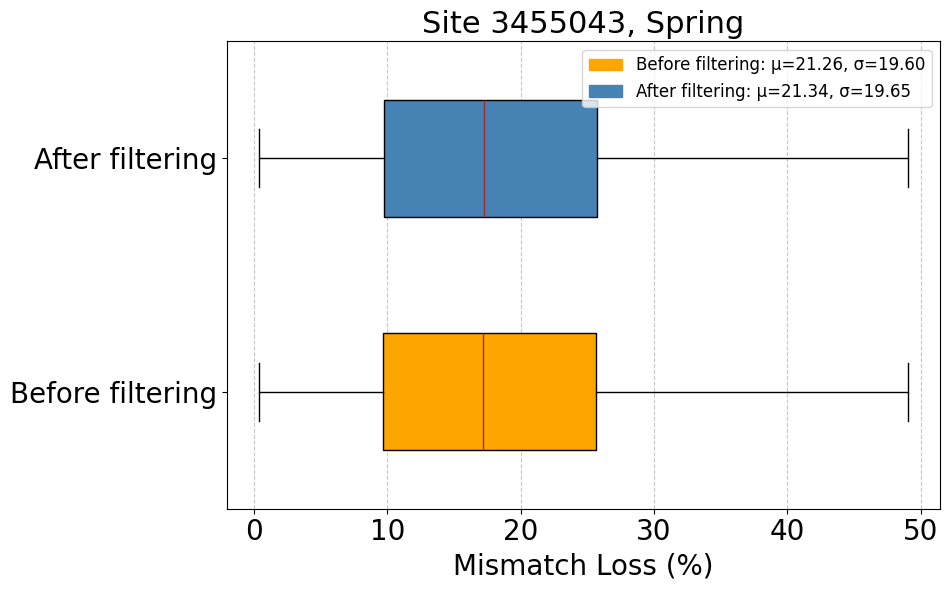

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\3455043_summer_20250516_113123
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\3455043_summer_20250516_113123\module_param_df.csv
df_pivot shape: (1698, 168)
2024-12-15 15:55:00 → 226780735_diode_activation=-1.0, Voc_226780735_outlier_label=1.0, Isc_226780735_outlier_label=-1.0
2024-12-16 10:05:00 → 226780739_diode_activation=-1.0, Voc_226780739_outlier_label=1.0, Isc_226780739_outlier_label=-1.0
2024-12-16 11:50:00 → 226780730_diode_activation=-1.0, Voc_226780730_outlier_label=1.0, Isc_226780730_outlier_label=-1.0
2024-12-19 09:15:00 → 226780325_diode_activation=-1.0, Voc_226780325_outlier_label=1.0, Isc_226780325_outlier_label=-1.0
2024-12-19 09:15:00 → 226782364_diode_activation=-1.0, Voc_226782364_outlier_label=1.0, Isc_226782364_outlier_label=-1.0
2024-12-20 12:35:00 → 22

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


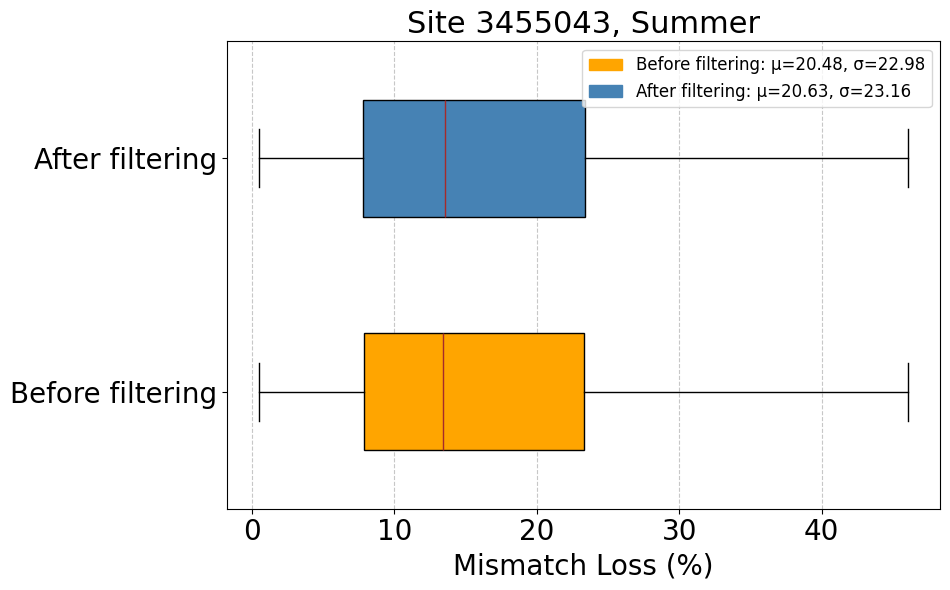

Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\3455043_winter_20250519_103230
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\3455043_winter_20250519_103230\module_param_df.csv
df_pivot shape: (1289, 168)
2024-06-15 15:45:00 → 226780737_diode_activation=-1.0, Voc_226780737_outlier_label=1.0, Isc_226780737_outlier_label=-1.0
2024-06-15 15:45:00 → 226780739_diode_activation=-1.0, Voc_226780739_outlier_label=1.0, Isc_226780739_outlier_label=-1.0
2024-06-16 15:45:00 → 226780737_diode_activation=-1.0, Voc_226780737_outlier_label=1.0, Isc_226780737_outlier_label=-1.0
2024-06-16 15:45:00 → 226780739_diode_activation=-1.0, Voc_226780739_outlier_label=1.0, Isc_226780739_outlier_label=-1.0
2024-06-17 15:45:00 → 226780737_diode_activation=-1.0, Voc_226780737_outlier_label=1.0, Isc_226780737_outlier_label=-1.0
2024-06-17 15:45:00 → 22

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\3455043_autumn_20250516_135200
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\3455043_autumn_20250516_135200\module_param_df.csv
df_pivot shape: (1480, 168)
2024-03-15 10:40:00 → 226780741_diode_activation=-1.0, Voc_226780741_outlier_label=1.0, Isc_226780741_outlier_label=-1.0
2024-03-19 12:00:00 → 226780326_diode_activation=-1.0, Voc_226780326_outlier_label=1.0, Isc_226780326_outlier_label=-1.0
2024-03-19 14:15:00 → 226780324_diode_activation=-1.0, Voc_226780324_outlier_label=1.0, Isc_226780324_outlier_label=-1.0
2024-03-20 07:15:00 → 226780734_diode_activation=-1.0, Voc_226780734_outlier_label=1.0, Isc_226780734_outlier_label=-1.0
2024-03-23 13:40:00 → 226780730_diode_activation=-1.0, Voc_226780730_outlier_label=1.0, Isc_226780730_outlier_label=-1.0
2024-03-23 13:45:00 → 22

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['Mismatch Loss (%)'] = (
C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\3177529913.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


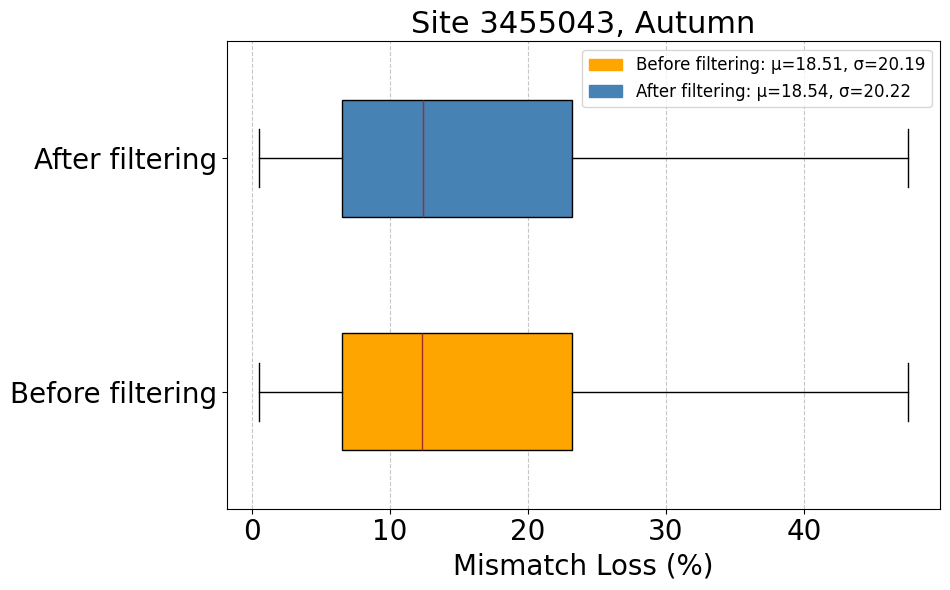

In [ ]:
for site_id in site_ids:
    for season in seasons:

       ######################## Voc outlier detector ########################
       # Find the folder
        target_folder = None
        for name in os.listdir(ResultsFolder):
            path = os.path.join(ResultsFolder, name)
            if not os.path.isdir(path):
                continue
            if site_id in name and season in name.lower():
                target_folder = path
                print(f"Found target folder: {target_folder}")
                break

        if target_folder is not None:
            # List files in the folder
            files = os.listdir(target_folder)
            # look for a csv file that contains the word module
            for file in files:
                if 'module' in file.lower() and file.endswith('.csv'):
                    target_file = os.path.join(target_folder, file)
                    print(f"Found file: {target_file}")
                    # read the csv file
                    df = pd.read_csv(target_file)

                    df = df.dropna(how='all')   # only toss rows that are 100% NaN

                    df_pivot = df.pivot_table(
                        index   ='Timestamp',
                        columns ='Optimizer',
                        values  =['I0','Isc','Voc','FF','Pmp','Imp','Vmp'],
                        aggfunc ='first'
                    )

                    # if you really want to lose only optimizers that never showed up:
                    df_pivot = df_pivot.dropna(axis=1, how='all')

                    print('df_pivot shape:', df_pivot.shape)


                    # ensure the index is datetime
                    df_pivot.index = pd.to_datetime(df_pivot.index)

                    # --- flatten the MultiIndex columns to simple strings ---
                    df_pivot.columns = ['{}_{}'.format(var, opt) for var, opt in df_pivot.columns]

                    # find the flattened Voc columns
                    voc_cols = [c for c in df_pivot.columns if c.startswith('Voc_')]

                    # calculate the median of the Voc rows
                    # voc_median = df_pivot[voc_cols].median(axis=0)

                    # compute three outlier masks row‐wise
                    mask1   = df_pivot[voc_cols].apply(lambda row: outlier_1_identifier(row), axis=1)
                    # mask_n1 = df_pivot[voc_cols].apply(lambda row: outlier_n1_identifier(row), axis=1)
                    # mask_n2 = df_pivot[voc_cols].apply(lambda row: outlier_n2_identifier(row), axis=1)
                    
                    # define mask_n1 & mask_n2 using the median of each row
                    mask_n1 = df_pivot[voc_cols].apply(
                        lambda row: (row < 2/3 * row.quantile(0.75)) & (row > 1/3 * row.quantile(0.75)),
                        axis=1
                    )
                    mask_n2 = df_pivot[voc_cols].apply(
                        lambda row: row < 1/3 * row.quantile(0.75),
                        axis=1
                    )
                    # combine all masks into a single label a single label: 
                    #   1 if mask1, -1 if mask_n1, -2 if mask_n2, else 0
                    for col in voc_cols:
                        df_pivot[f'{col}_outlier_label'] = np.where(
                            mask1[col],   1,
                            np.where(mask_n1[col], -1,
                                    np.where(mask_n2[col], -2, 0))
                        )

                    # print the outlier labels
                    # print(df_pivot[[col for col in df_pivot.columns if col.endswith('_outlier_label')]].head(10))

            
        ######################## Isc outlier detector ########################
        # find all flattened Isc columns
        isc_cols = [c for c in df_pivot.columns if c.startswith('Isc_')]

        # compute high/low masks
        mask_high_isc = df_pivot[isc_cols].apply(outlier_isc_high, axis=1)
        mask_low_isc  = df_pivot[isc_cols].apply(outlier_isc_low,  axis=1)

        # assign labels: 1 if too high, -1 if too low, else 0
        for col in isc_cols:
            df_pivot[f'{col}_outlier_label'] = np.where(
                mask_high_isc[col],  1,
                np.where(mask_low_isc[col], -1, 0)
            )

        # preview the new Isc outlier labels
        # print(df_pivot[[c for c in df_pivot.columns
        #                 if c.startswith('Isc_') and c.endswith('_outlier_label')]].head(10))
        

        ######################## Diode activation detector ########################
        # build lists of your outlier‐label cols
        voc_label_cols = [c for c in df_pivot.columns
                        if c.startswith('Voc_') and c.endswith('_outlier_label')]
        isc_label_cols = [c for c in df_pivot.columns
                        if c.startswith('Isc_') and c.endswith('_outlier_label')]

        # for each Voc_xxx_outlier_label, pick the matching Isc_xxx_outlier_label
        for voc_col in voc_label_cols:
            opt     = voc_col.replace('Voc_', '').replace('_outlier_label', '')
            isc_lab = f'Isc_{opt}_outlier_label'
            act_col = f'{opt}_diode_activation'
            if isc_lab not in df_pivot.columns:
                continue

            # define conditions
            conds   = [
                (df_pivot[voc_col] == -1) & (df_pivot[isc_lab] == 0),
                (df_pivot[voc_col] == -2) & (df_pivot[isc_lab] == 0),
                (df_pivot[voc_col] ==  1) & (df_pivot[isc_lab] == -1)
            ]
            choices = [1, 2, -1]

            # assign activation label
            df_pivot[act_col] = np.select(conds, choices, default=0)

            # if actual Isc < 1 A, force activation to 0
            # df_pivot.loc[df_pivot[f'Isc_{opt}'] < 1, act_col] = 0

        # ensure the index has a name
        df_pivot.index.name = 'Timestamp'

        # build output filename with site_id and season, and save into the matching ResultsFolder sub-folder
        output_filename = f"{site_id}_{season}_outlier_labels.csv"
        output_path     = os.path.join(target_folder or ResultsFolder, output_filename)

        df_pivot.to_csv(
            output_path,
            index=True,
            index_label='Timestamp'
        )

        # # collect all diode‐activation columns
        act_cols = [c for c in df_pivot.columns if c.endswith('_diode_activation')]

        # select rows where any activation ≠ 0
        diode_activation = df_pivot[(df_pivot[act_cols] != 0).any(axis=1)]

        # for each timestamp and each activated optimiser, print the diode‐activation value
        # along with its corresponding Voc and Isc outlier labels
        for ts, row in diode_activation.iterrows():
            for act_col in act_cols:
                act_val = row[act_col]
                if act_val != 0:
                    opt = act_col.replace('_diode_activation','')
                    voc_label = f'Voc_{opt}_outlier_label'
                    isc_label = f'Isc_{opt}_outlier_label'
                    print(f"{ts} → {act_col}={act_val}, "
                          f"{voc_label}={row.get(voc_label,'NA')}, "
                          f"{isc_label}={row.get(isc_label,'NA')}")

        ########################## Filter the power files ##########################
        # find the diode activation timestamps
        diode_activation_timestamps = diode_activation.index

        # ensure it is in datetime format
        diode_activation_timestamps = pd.to_datetime(diode_activation_timestamps)

        # read the file in ResultsFolder that contains the word 'combined' and is an excel file
        for file in os.listdir(target_folder):
            if 'combined' in file and file.endswith('.xlsx'):
                combined_file = os.path.join(target_folder, file)
                break
        else:
            print(f"No combined file found in {target_folder}")

        # from the combined file, read the first sheet
        combined_df = pd.read_excel(combined_file, sheet_name=0)

        # uensure timestamp is in datetime format
        combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'])

        # use it as index
        combined_df.set_index('Timestamp', inplace=True)

        print(f"Original combined data shape: {combined_df.shape}")

        # remove the diode activation timestamps from the combined data
        combined_df_filtered = combined_df[~combined_df.index.isin(diode_activation_timestamps)]

        # create a new file name with '_no_diode_activation' suffix
        new_combined_file = combined_file.replace('.xlsx', '_no_diode_activation.xlsx')
        # save the new combined data to the new file
        combined_df_filtered.to_excel(new_combined_file, index=True)

        # print hte shape before and after filtering
        print(f"New combined data shape (after removing diode activation timestamps): {combined_df_filtered.shape}")

        # plot a comparison of the original and filtered data as boxplot
        # print the columns of the combined_df
        print(f"Columns in combined_df: {combined_df.columns.tolist()}")
        # Calculate mismatch loss for both datasets
        combined_df['Mismatch Loss (%)'] = (
            (combined_df['Sum of I*V (W)'] - combined_df['Pmppt (W)']) / combined_df['Sum of I*V (W)'] * 100
        ).clip(0, 100)
        combined_df_filtered['Mismatch Loss (%)'] = (
            (combined_df_filtered['Sum of I*V (W)'] - combined_df_filtered['Pmppt (W)']) / combined_df_filtered['Sum of I*V (W)'] * 100
        ).clip(0, 100)

        # Prepare data
        data = [
            combined_df['Mismatch Loss (%)'],
            combined_df_filtered['Mismatch Loss (%)']
        ]

        labels = ['Before filtering', 'After filtering']
        colors = ['orange', 'steelblue']

        fig, ax = plt.subplots(figsize=long_hoz_figsize)

        # Horizontal boxplot without outliers
        box = ax.boxplot(
            data,
            vert=False,
            patch_artist=True,
            labels=labels,
            showfliers=False,
            widths=0.5
        )

        # Set box colors
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)

        # Set median line color
        for median in box['medians']:
            median.set_color('brown')

        # Set whisker and cap colors
        for whisker in box['whiskers']:
            whisker.set_color('black')
        for cap in box['caps']:
            cap.set_color('black')

        # Calculate mean and std for legend
        means = [np.mean(d) for d in data]
        stds = [np.std(d) for d in data]
        legend_labels = [
            f"{labels[0]}: μ={means[0]:.2f}, σ={stds[0]:.2f}",
            f"{labels[1]}: μ={means[1]:.2f}, σ={stds[1]:.2f}"
        ]
        legend_patches = [
            mpatches.Patch(color=colors[0], label=legend_labels[0]),
            mpatches.Patch(color=colors[1], label=legend_labels[1])
        ]

        # Set labels and title
        ax.set_xlabel('Mismatch Loss (%)', fontsize=axis_label_size)
        ax.set_title(f'Site {site_id}, {season.capitalize()}', fontsize=title_size)
        ax.tick_params(axis='both', labelsize=axis_num_size)
        ax.grid(axis='x', ls='--', alpha=0.7)
        ax.legend(handles=legend_patches, fontsize=axis_num_size-8, loc='upper right')

        fig.tight_layout(rect=[0, 0, 0.8, 1])
        # Only save if target_folder is not None
        if target_folder is not None:
            output_figure_path = os.path.join(target_folder, f"{site_id}_{season}_mismatch_loss_boxplot.png")
            plt.savefig(output_figure_path, bbox_inches='tight', dpi=300)
        plt.show()

# 5. Mismatch without diode activation

## 5.1. Generate the results

In [66]:
zone_file = os.path.join(ResultsFolder, 'new_and_old_with_climate_zone.xlsx')
if not os.path.exists(zone_file):
    raise FileNotFoundError(f"Cannot find climate zone file: {zone_file}")
print(f"Reading climate zone file: {zone_file}")
zone_df = pd.read_excel(zone_file, sheet_name=0)

# add extra columns into the zone_df: autumn mismatch loss, spring mismatch loss, summer mismatch loss, winter mismatch loss, 
# mean mismatch loss without diode activation
zone_df['autumn Mismatch no diode (%)'] = np.nan
zone_df['spring Mismatch no diode (%)'] = np.nan
zone_df['summer Mismatch no diode (%)'] = np.nan
zone_df['winter Mismatch no diode (%)'] = np.nan
zone_df['mean Mismatch no diode (%)']   = np.nan

# print(zone_df) site id is good

# …within the 5.1 cell, replace the folder‐finding loop with this:

# iterate through the site_ids and seasons
for site_id in site_ids:
    for season in seasons:
        # find the matching sub‐directory (skip any files)
        target_folder = None
        for name in os.listdir(ResultsFolder):
            path = os.path.join(ResultsFolder, name)
            if os.path.isdir(path) and site_id in name and season in name.lower():
                target_folder = path
                print(f"Found target folder: {target_folder}")
                break
        if target_folder is None:
            print(f"No directory for site {site_id} / season {season}, skipping")
            continue

        # now list only inside that directory
        for fname in os.listdir(target_folder):
            if 'no_diode_activation' in fname and fname.endswith('.xlsx'):
                no_diode_activation_file = os.path.join(target_folder, fname)
                print(f"Found no diode activation file: {no_diode_activation_file}")
                no_diode_activation_df = pd.read_excel(no_diode_activation_file)
                break
        else:
            print(f"No no_diode_activation.xlsx in {target_folder}, skipping")
            continue

        # calculate the mismatch loss
        available_power = no_diode_activation_df['Sum of I*V (W)'].sum()
        series_power    = no_diode_activation_df['Pmppt (W)'].sum()
        mismatch_loss   = (available_power - series_power) / available_power * 100 
        print(f"Updating zone_df for site {site_id} in {season} with mismatch loss: {mismatch_loss:.2f}%")

        # find the original mismatch loss location, only add the results if it is not nan
        # if not pd.isna(zone_df.loc[zone_df['Site ID'] == int(site_id), f'{season} Mismatch Loss (%)'].values[0]):
        #     zone_df.loc[zone_df['Site ID'] == int(site_id), f'{season} Mismatch no diode (%)'] = mismatch_loss
        # else:
        #     print(f"Mismatch loss for site {site_id} in {season} was emtpy, not need to compare")
        zone_df.loc[zone_df['Site ID'] == int(site_id), f'{season} Mismatch no diode (%)'] = mismatch_loss


# to correct between south and norht hem hemisphere
# swap the autumn and spring mismatch loss for southern hemisphere for the rows whose country is in the southern hemisphere
# southern_hemisphere_countries = [
#     'Australia', 'New Zealand', 'South Africa', 'Argentina', 'Chile', 'Uruguay'
# ]
# # swap the autumn and spring mismatch loss for the rows whose country is in the southern hemisphere
# zone_df.loc[zone_df['Country'].isin(southern_hemisphere_countries), 
#             ['autumn Mismatch no diode (%)', 'spring Mismatch no diode (%)']] = \
#     zone_df.loc[zone_df['Country'].isin(southern_hemisphere_countries), 
#                 ['spring Mismatch no diode (%)', 'autumn Mismatch no diode (%)']].values
# # swap the summer and winter mismatch loss for southern hemisphere for the rows whose country is in the southern hemisphere
# zone_df.loc[zone_df['Country'].isin(southern_hemisphere_countries),
#             ['summer Mismatch no diode (%)', 'winter Mismatch no diode (%)']] = \
#     zone_df.loc[zone_df['Country'].isin(southern_hemisphere_countries), 
#                 ['winter Mismatch no diode (%)', 'summer Mismatch no diode (%)']].values

# print(zone_df) the site id is still good

# for values in column that contains the word "Mismatch Loss (%)", if the value is NaN
# replace the value in the corresponding column that contains the word "Mismatch no diode (%)" with nan
for col in zone_df.columns:
    if 'Mismatch Loss (%)' in col:
        # find the corresponding column that contains the word "Mismatch no diode (%)"
        no_diode_col = col.replace('Mismatch Loss (%)', 'Mismatch no diode (%)')
        # replace the value in the no_diode_col with NaN if the value in col is NaN
        zone_df.loc[pd.isna(zone_df[col]), no_diode_col] = np.nan

# replace any value in any columns above 60% with nan
num_cols = zone_df.select_dtypes(include='number').columns
# exclude the column named 'Site ID' from num_cols
num_cols = num_cols[num_cols != 'Site ID']
for col in num_cols:
    zone_df.loc[zone_df[col] > 60, col] = np.nan

# calculate the mean mismatch loss without diode activation
zone_df['mean Mismatch no diode (%)'] = zone_df[['autumn Mismatch no diode (%)', 
                                                    'spring Mismatch no diode (%)', 
                                                    'summer Mismatch no diode (%)', 
                                                    'winter Mismatch no diode (%)']].mean(axis=1)

# save the zone_df and export an excel file
output_zone_file = os.path.join(ResultsFolder, 'Mismatch loss without diode activation.xlsx')
zone_df.to_excel(output_zone_file, index=False)

print(zone_df)

Reading climate zone file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\new_and_old_with_climate_zone.xlsx
Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4184502_summer_20250518_155603
Found no diode activation file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4184502_summer_20250518_155603\combined_data_summer_4184502_no_diode_activation.xlsx
Updating zone_df for site 4184502 in summer with mismatch loss: 19.68%
Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4184502_autumn_20250518_160921
Found no diode activation file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4184502_autumn_20250518_160921\combined_data

## 5.2. Visualisation

### 5.2.1. Compare the overall distribution

C:\Users\z5183876\AppData\Local\Temp\ipykernel_3900\2828867942.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot(


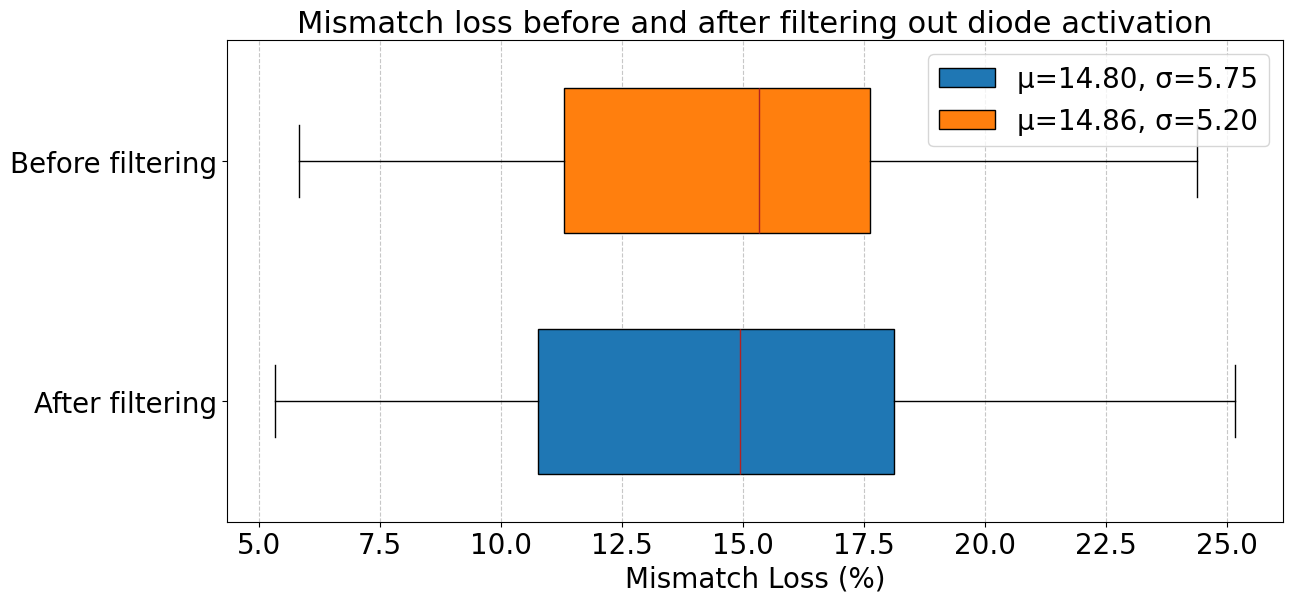

In [67]:
# read the mismatch loss csv file without diode activation
mismatch_loss_df = output_zone_file

# plot the boxplot
# column: mean Mismatch no diode (%)
# column: mean Mismatch Loss (%)
# ...existing code before the boxplot...
plt.figure(figsize=long_hoz_figsize)
data = [
    zone_df['mean Mismatch no diode (%)'].dropna(),
    zone_df['Mean Mismatch Loss (%)'].dropna()
]
labels = ['After filtering', 'Before filtering']
bplot = plt.boxplot(
    data,
    vert=False,
    labels=labels,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(edgecolor='k'),
    medianprops=dict(color='firebrick'),
    whis=1.5  # use default IQR factor for whiskers
)
# colour each box differently
colors = ['C0', 'C1']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# compute mean and std
m1, s1 = data[0].mean(), data[0].std()
m2, s2 = data[1].mean(), data[1].std()

handles = [
    mpatches.Patch(facecolor=colors[0], edgecolor='k',
                   label=f"μ={m1:.2f}, σ={s1:.2f}"),
    mpatches.Patch(facecolor=colors[1], edgecolor='k',
                   label=f"μ={m2:.2f}, σ={s2:.2f}")
]
plt.legend(handles=handles, fontsize=axis_num_size, loc='upper right')

plt.title('Mismatch loss before and after filtering out diode activation', fontsize=title_size)
plt.xlabel('Mismatch Loss (%)', fontsize=axis_label_size)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(fontsize=axis_num_size)
plt.tick_params(axis='both', labelsize=axis_num_size)
plt.show()
# ...existing code after the boxplot...

### 5.2.2. Distribution of the difference

#### 5.2.2.1. Divide by Season

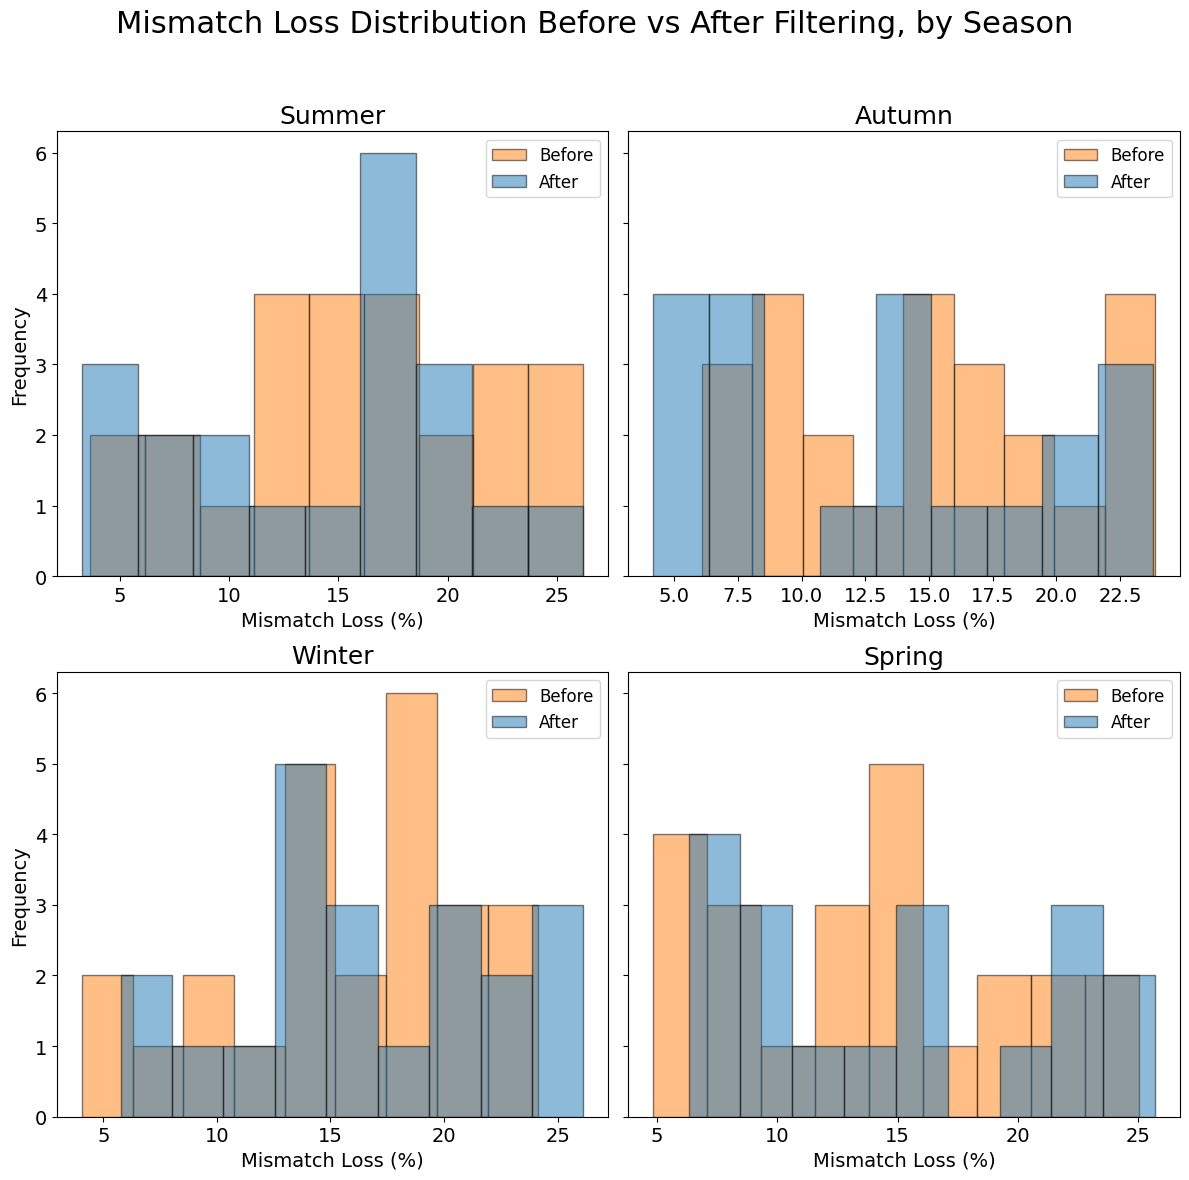

In [68]:
# …existing code after cell “### 5.2.2. Distribution of the difference”…

# 5.2.2. Histogram of Mismatch Loss before vs after filtering, broken down by season
seasons = ['summer','autumn','winter','spring']
fig, axes = plt.subplots(2, 2, figsize=two_by_two_figsize, sharey=True)

for idx, season in enumerate(seasons):
    ax = axes.flatten()[idx]
    before = zone_df[f'{season} Mismatch Loss (%)'].dropna()
    after  = zone_df[f'{season} Mismatch no diode (%)'].dropna()
    ax.hist(before, bins=9, alpha=0.5, label='Before', color='C1', edgecolor='black')
    ax.hist(after,  bins=9, alpha=0.5, label='After',  color='C0', edgecolor='black')
    ax.set_title(season.capitalize(), fontsize=title_size-4)
    ax.set_xlabel('Mismatch Loss (%)', fontsize=axis_label_size-6)
    ax.tick_params(labelsize=axis_num_size-6)
    # only set y-label on first column
    if idx % 2 == 0:
        ax.set_ylabel('Frequency', fontsize=axis_label_size-6)
    ax.legend(fontsize=axis_num_size-8)

plt.suptitle('Mismatch Loss Distribution Before vs After Filtering, by Season', fontsize=title_size)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

#### 5.2.2.2. Together

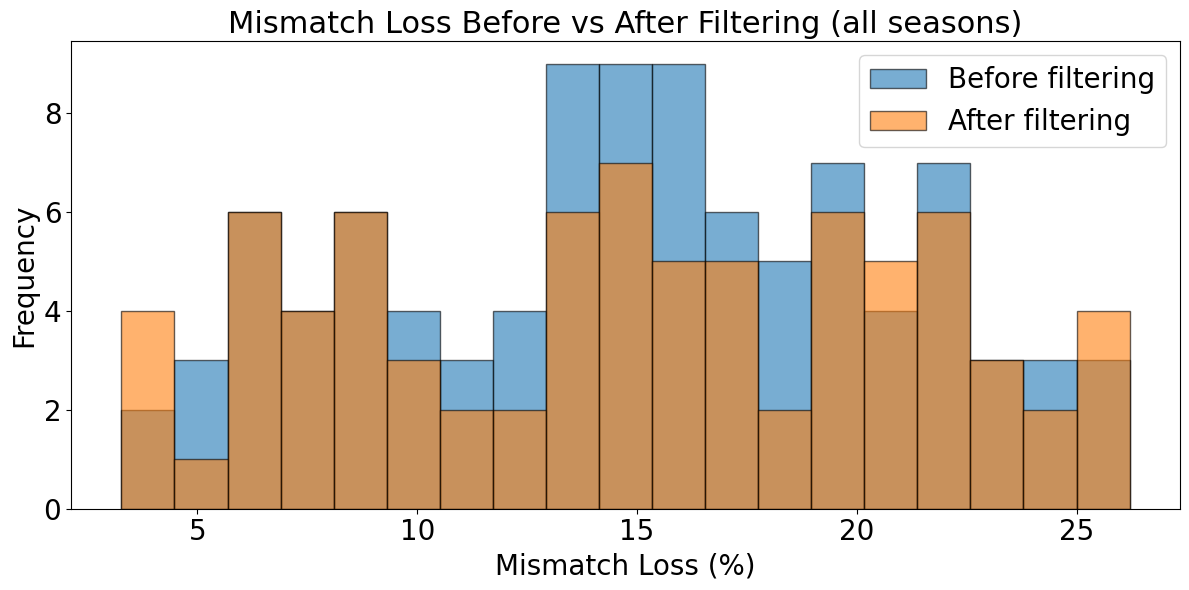

In [69]:
# …existing code after cell “#### 5.2.2.2. Together”…

# 5.2.2. Histogram of Mismatch Loss before vs after filtering: all seasons merged
seasons = ['summer', 'autumn', 'winter', 'spring']
# concatenate all seasons into two series
before_all = pd.concat([
    zone_df[f'{s} Mismatch Loss (%)'] for s in seasons
]).dropna()
after_all  = pd.concat([
    zone_df[f'{s} Mismatch no diode (%)'] for s in seasons
]).dropna()

fig, ax = plt.subplots(figsize=long_hoz_figsize)
# common bins
bins = np.linspace(
    min(before_all.min(), after_all.min()),
    max(before_all.max(), after_all.max()),
    20
)

ax.hist(before_all, bins=bins, alpha=0.6, label='Before filtering', edgecolor='black')
ax.hist(after_all,  bins=bins, alpha=0.6, label='After filtering',  edgecolor='black')

ax.set_xlabel('Mismatch Loss (%)', fontsize=axis_label_size)
ax.set_ylabel('Frequency', fontsize=axis_label_size)
ax.set_title('Mismatch Loss Before vs After Filtering (all seasons)', fontsize=title_size)
ax.tick_params(labelsize=axis_num_size)
ax.legend(fontsize=axis_num_size)
plt.tight_layout()
plt.show()

#### 5.2.2.3. Difference distribution seperating the season

This huge difference in different season comes from the wrong seasonal indexing

Zone DataFrame before filtering:
      No  Site ID        Country       State     kWp    Opt  \
0    1.0  3455043      Australia         QLD   9.960   S440   
2    3.0  4034376      Australia          SA   6.650   S500   
3    4.0  4140175      Australia         NSW   6.600  S500B   
4    5.0  4186157  North America       Texas  10.695   S440   
5    6.0  4172746  North America     Arizona   7.290   S440   
6    7.0  4111846  North America      Nevada   6.400   S440   
7    8.0  4123602  North America  California   7.000   S440   
8    9.0  4111492  North America        Iowa  13.800  S550B   
9   10.0  4184502  North America       Texas   5.200   S500   
10  11.0  4093266  North America        Ohio   7.500   S440   
11  12.0  4111800  North America  California   7.200   S440   
12  13.0  4118327  North America       Texas  12.800   S440   
13  14.0  4112053    Netherlands         NaN   8.400   S440   
16  17.0  4122216    Netherlands         NaN   5.740   S440   
17  18.0  4153809    N

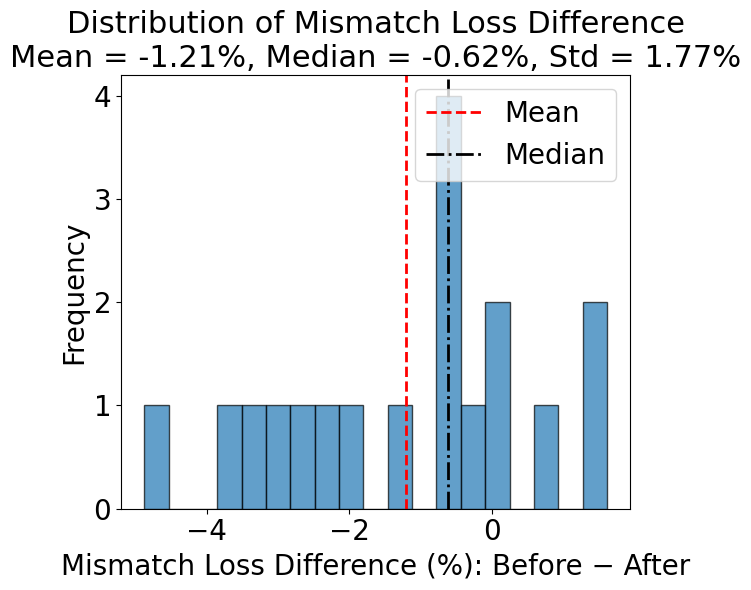

Sites with significant difference (more than 5%):
Site ID: 4034376, Mean Mismatch no diode: 7.48%, Mean Mismatch Loss: 7.43%
Site ID: 4140175, Mean Mismatch no diode: 25.17%, Mean Mismatch Loss: 24.37%
Site ID: 4186157, Mean Mismatch no diode: 10.77%, Mean Mismatch Loss: 10.53%
Site ID: 4123602, Mean Mismatch no diode: 16.33%, Mean Mismatch Loss: 15.93%
Site ID: 4111492, Mean Mismatch no diode: 21.97%, Mean Mismatch Loss: 21.68%
Site ID: 4184502, Mean Mismatch no diode: 14.94%, Mean Mismatch Loss: 14.08%
Site ID: 4093266, Mean Mismatch no diode: 14.61%, Mean Mismatch Loss: 14.16%


In [ ]:
# print the zone_df before filtering
print("Zone DataFrame before filtering:")
print(zone_df)

# remove any unnamed columns from zone_df
zone_df = zone_df.loc[:, ~zone_df.columns.str.contains('^Unnamed')]
# remove any columns that are all nan
zone_df = zone_df.dropna(axis=1, how='all')
# remove any rows that contains any nan except the column 'State'
zone_df = zone_df.dropna(subset=zone_df.columns.difference(['State']), how='any')

# print hte zone_df after filtering
print("Zone DataFrame after filtering:")
print(zone_df)


# 5.2.2.3. Histogram of the difference (Before − After) across all seasons
seasons   = ['summer', 'autumn', 'winter', 'spring']
# seasons = ['summer']
# seasons = ['autumn']
# seasons = ['winter']
# seasons = ['spring']
diff_all  = pd.concat([
    zone_df[f'{s} Mismatch Loss (%)'] - zone_df[f'{s} Mismatch no diode (%)']
    for s in seasons
]).dropna()

# compute statistics
mean_diff   = diff_all.mean()
median_diff = diff_all.median()
std_diff    = diff_all.std()

# ...existing code...
fig, ax = plt.subplots(figsize=figure_size)
bins = np.linspace(diff_all.min(), diff_all.max(), 20)
ax.hist(diff_all, bins=bins, edgecolor='black', alpha=0.7)

# annotate mean and median lines
ax.axvline(mean_diff,   color='red',   linestyle='--', linewidth=2)
ax.axvline(median_diff, color='black', linestyle='-.', linewidth=2)

# Remove mean/median from legend, just show line styles
ax.legend(
    [
        plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2),
        plt.Line2D([0], [0], color='black', linestyle='-.', linewidth=2)
    ],
    [
        "Mean", "Median"
    ],
    fontsize=axis_num_size, loc='upper right'
)

ax.set_xlabel('Mismatch Loss Difference (%): Before − After', fontsize=axis_label_size)
ax.set_ylabel('Frequency', fontsize=axis_label_size)
ax.tick_params(labelsize=axis_num_size)
ax.set_title(
    f'Distribution of Mismatch Loss Difference\n'
    f'Mean = {mean_diff:.2f}%, Median = {median_diff:.2f}%, Std = {std_diff:.2f}%',
    fontsize=title_size
)

plt.tight_layout()
plt.show()
# ...existing code...

# look up the print the site id whose difference is larger than 5%
high_diff_sites = zone_df[zone_df['mean Mismatch no diode (%)'] - zone_df['Mean Mismatch Loss (%)'] > 5/100]
# print(zone_df)
if not high_diff_sites.empty:
    print("Sites with significant difference (more than 5%):")
    for idx, row in high_diff_sites.iterrows():
        print(f"Site ID: {row['Site ID']}, "
            #   f"Season: {row['season']}, "
              f"Mean Mismatch no diode: {row['mean Mismatch no diode (%)']:.2f}%, "
              f"Mean Mismatch Loss: {row['Mean Mismatch Loss (%)']:.2f}%")

#### 5.2.2.4. Difference with merged season

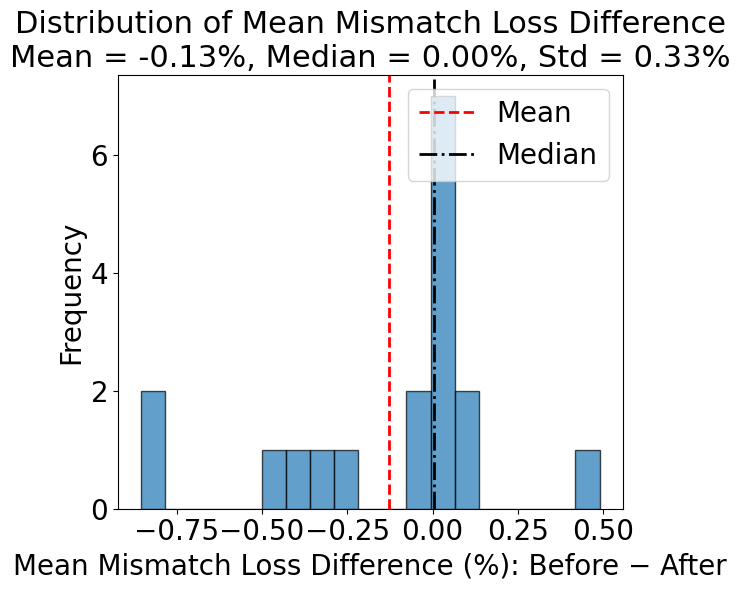

In [71]:
# ...existing code...

# Calculate the difference between mean mismatch loss before and after filtering
diff_mean = zone_df['Mean Mismatch Loss (%)'] - zone_df['mean Mismatch no diode (%)']
diff_mean = diff_mean.dropna()

# Compute statistics
mean_diff   = diff_mean.mean()
median_diff = diff_mean.median()
std_diff    = diff_mean.std()

fig, ax = plt.subplots(figsize=figure_size)
bins = np.linspace(diff_mean.min(), diff_mean.max(), 20)
ax.hist(diff_mean, bins=bins, edgecolor='black', alpha=0.7)

# Annotate mean and median lines
ax.axvline(mean_diff,   color='red',   linestyle='--', linewidth=2)
ax.axvline(median_diff, color='black', linestyle='-.', linewidth=2)

# Only show line styles in legend
ax.legend(
    [
        plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2),
        plt.Line2D([0], [0], color='black', linestyle='-.', linewidth=2)
    ],
    [
        "Mean", "Median"
    ],
    fontsize=axis_num_size, loc='upper right'
)

ax.set_xlabel('Mean Mismatch Loss Difference (%): Before − After', fontsize=axis_label_size)
ax.set_ylabel('Frequency', fontsize=axis_label_size)
ax.tick_params(labelsize=axis_num_size)
ax.set_title(
    f'Distribution of Mean Mismatch Loss Difference\n'
    f'Mean = {mean_diff:.2f}%, Median = {median_diff:.2f}%, Std = {std_diff:.2f}%',
    fontsize=title_size
)

plt.tight_layout()
plt.show()
# ...existing code...